In [1]:
%reload_ext autoreload
%autoreload 2

import mlflow.tracking
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
from os import getcwd, listdir, makedirs
from os.path import join, isdir, dirname
import ast
from typing import Any
from argparse import ArgumentParser
from glob import glob
from IPython.display import display
import shap

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 

sys.path.insert(0, join(getcwd(), "../module_code"))

import cli_utils 
import main
import exp.static_learning

sys.argv = [sys.argv[0]]
cli_utils.load_cli_args("../options.yml")
args = cli_utils.init_cli_args()

# path to mlflow directory (not mlruns)
mlflow_path = "/radraid/jeffreyfeng/CRRT_Project/mlflow/"

makedirs('./posthoc', exist_ok=True)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
#copy tff to ~/mambaforge/envs/crrtenv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf
# rm -rf ~/.cache/matplotlib

# from matplotlib import font_manager
# for item in font_manager.fontManager.ttflist:
#     print(str(item.name))

from matplotlib import rcParams
rcParams['font.family'] = 'Roboto'

# Helper functions

In [3]:
def get_client_from_id(mlflow_path, run):
    client_path = None
    for directory in listdir(mlflow_path):
        if 'mlruns' == directory:
            runs = glob(join(mlflow_path, directory,"*" ,run))
            if len(runs) > 0:
                client_path = join(mlflow_path, directory)
                break 
                    
        elif isdir(join(mlflow_path,directory)):
            runs = glob(join(mlflow_path, directory,'mlruns',"*" ,run))
            
            if len(runs) > 0:
                client_path = join(mlflow_path, directory, 'mlruns')
                break 
    
    return client_path

In [4]:
def better_search_runs(client, exp_path, filter):
    run_ = None
    filter = filter.split('and')
    
    for run in listdir(exp_path):
        run_path = join(exp_path,run)
    
        if 'trash' not in run and isdir(run_path):
        
            meets_criteria = 0
            for filt in filter:
                var = filt.split('tags.')[-1].split('=')[0]
                val = filt.split('=')[-1].strip('\'')
                with open(join(run_path,'tags',var), 'r') as f:
                    if f.read() == val:
                        meets_criteria+=1
            
            if meets_criteria == len(filter):
                run_ = client.get_run(run)
                break
    return run_

In [5]:
def get_run_from_name(mlflow_path, run_name, filter, from_id=None):
       
    if isdir(join(mlflow_path,run_name)):
        client_path = join(mlflow_path, run_name, 'mlruns')
    else:
        client_path = join(mlflow_path, 'mlruns')
        
    client =  mlflow.tracking.MlflowClient(f"file://{client_path}")
    
    exp_path = join(client_path,client.get_experiment_by_name('static_learning').experiment_id)
    
    if from_id is not None:
        run = client.get_run(from_id)
        return run, exp_path
    
    # run = client.search_runs(client.get_experiment_by_name('static_learning').experiment_id, 
    #                          filter_string=filter,
    #                         order_by=["attributes.start_time DESC"],
    # )[0]
    run = better_search_runs(client, exp_path, filter=filter)
        
    return run, exp_path 

In [6]:
def get_original_probabilities(exp_path, run_id, run_name, prefix, filter=None):
    # get all probabilities                 
    predict_probas_path = join(exp_path, run_id, "artifacts", run_name, "predict_probas", f"{prefix}__{run_name}","predict_probas.pkl")
    predict_probas = pickle.load(open(predict_probas_path, 'rb'))
    
    # get all labels
    labels_path = join(exp_path, run_id, "artifacts", run_name, "labels", f"{prefix}__{run_name}","labels.pkl")
    labels = pickle.load(open(labels_path, 'rb'))

    # align probabilities and labels
    try:
        aligned_df = pd.merge(predict_probas.to_frame(),labels.to_frame(),how='inner', on=['IP_PATIENT_ID','Start Date'])
    except:
        aligned_df = pd.merge(predict_probas,labels,how='inner', on=['IP_PATIENT_ID','Start Date'])
        
    if filter is not None:
        other_runs, other_exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter}_8 best'")
        other_run_id = other_runs.info.run_id
        # get all probabilities                 
        predict_probas_path = join(other_exp_path, other_run_id, "artifacts", run_name, "predict_probas", f"{prefix}__{run_name}","predict_probas.pkl")
        predict_probas = pickle.load(open(predict_probas_path, 'rb'))
        # get all labels
        labels_path = join(other_exp_path, other_run_id, "artifacts", run_name, "labels", f"{prefix}__{run_name}","labels.pkl")
        labels = pickle.load(open(labels_path, 'rb'))
        # align probabilities and labels
        try:
            other_aligned_df = pd.merge(predict_probas.to_frame(),labels.to_frame(),how='inner', on=['IP_PATIENT_ID','Start Date'])
        except:
            other_aligned_df = pd.merge(predict_probas,labels,how='inner', on=['IP_PATIENT_ID','Start Date'])
        aligned_df = pd.concat([aligned_df, other_aligned_df])
        
        
    labels = aligned_df['recommend_crrt']
    pred_probas = aligned_df[0].values
    
    return aligned_df, labels, pred_probas
                    

In [7]:
def get_control_probabilities(exp_path, run, run_name, prefix, slide=0, filter=None):

    # assumes run is from control
    control_prob_df, _, _ = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix)
                        
    # GET THIS FOR UCLA 
    if 'ucla' in run_name:
        if slide == 0:
            ucla_run, exp_path  = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")
        else:
            # run, _ = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name}' and tags.slide_window_by='{slide}'")
            ucla_run, exp_path  = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // rolling window: {slide}'")
    else:
        if slide == 0:
            ucla_run, exp_path  = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_ucla_crrt best'")
        else:
            # run, _ = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name}' and tags.slide_window_by='{slide}'")
            ucla_run, exp_path  = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_ucla_crrt rolling window: {slide}'")
    ucla_prob_df, _, _ = get_original_probabilities(exp_path, ucla_run.info.run_id, run_name, prefix, filter=filter)
    
    #CONCATENATE
    total = pd.concat([control_prob_df, ucla_prob_df])

    labels = total['recommend_crrt']
    pred_probas = total[0].values
                
    return labels, pred_probas

In [8]:
from evaluate.utils import eval_metric

def get_point_estimate(boostrap_mean, labels, pred_probas, metric_name, metric_fn, bootstrap_point=True):
    
    if bootstrap_point:
        point_estimate = boostrap_mean
    else:
        point_estimate = eval_metric(labels, pred_probas, metric_name, metric_fn, decision_threshold=0.5)
        
    return point_estimate

# Experiment grid

In [9]:
# Experiment grid
TRIALS=50
ucla_train=f'ucla_to_ucla_tune{TRIALS}_v3'
cedars_train=f'cedars_to_cedars_tune{TRIALS}_v3'
uclapluscedars_train=f'uclapluscedars_to_uclapluscedars_tune{TRIALS}_v3'
all_train=f'all_to_all_tune50_v3'

ucla_preselectall=f'ucla_to_ucla_preselectall_tune{TRIALS}_v3'
ucla_preselectcrrt=f'ucla_to_ucla_preselectcrrt_tune{TRIALS}_v3'
cedars_preselectall=f'cedars_to_cedars_preselectall_tune{TRIALS}_v3'
cedars_preselectcrrt=f'cedars_to_cedars_preselectcrrt_tune{TRIALS}_v3'
uclapluscedars_preselectall=f'uclapluscedars_to_uclapluscedars_preselectall_tune{TRIALS}_v3'
uclapluscedars_preselectcrrt=f'uclapluscedars_to_uclapluscedars_preselectcrrt_tune{TRIALS}_v3'
all_preselectall=f'all_to_all_preselectall_tune{TRIALS}_v3'

In [10]:
from data.load import load_outcomes

OUTCOMES_CEDARS = load_outcomes(args.cedars_crrt_data_dir, ["IP_PATIENT_ID", "Start Date"])
OUTCOMES_UCLA = load_outcomes(args.ucla_crrt_data_dir, ["IP_PATIENT_ID", "Start Date"])

UCLA_IDS = OUTCOMES_UCLA.index.get_level_values('IP_PATIENT_ID')
CEDARS_IDS = OUTCOMES_CEDARS.index.get_level_values('IP_PATIENT_ID')

mealy | INFO - *****Loading Outcomes...*****


mealy | INFO - *****Loading Outcomes...*****


# Run post-hoc evaluation

Given any evaluation run, rerun evaluation. Can set new options such as:
1. Running rolling window if it wasn't done before
2. Running with explanations if it wasn't done before 

In [11]:
import yaml

def get_best_run(run_name):
    
    run, _ = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")
    
    try:
        best_run_id = run.data.tags['best_run_id']
    except:
        best_run_id = run.data.tags['best_model_path'].split('/artifacts')[0].split('/')[-1]
    
    best_run, _ = get_run_from_name(mlflow_path, run_name, None, from_id=best_run_id)
    
    return best_run

def reinit_param_from_string(args: ArgumentParser, param_name:str, param_val: Any) -> Any:
    if param_val == "None":
        return None
    elif param_name in args.__dict__.keys():
        if type(args.__dict__[param_name]) in [int, str, float]:
            return type(args.__dict__[param_name])(param_val)
        else:
            return ast.literal_eval(param_val)
    else:
        return param_val
    
def update_metayaml(mlflow_path, run_name):     
    if isdir(join(mlflow_path,run_name)):
        client_path = join(mlflow_path, run_name, 'mlruns')
    else:
        client_path = join(mlflow_path, 'mlruns')
        
    client =  mlflow.tracking.MlflowClient(f"file://{client_path}")
    
    exp_path = join(client_path,client.get_experiment_by_name('static_learning').experiment_id, 'meta.yaml')
    
    with open(exp_path) as f:
        list_doc = yaml.safe_load(f)
        list_doc['artifact_location'] = list_doc['artifact_location'].replace('/workspace/jeffreyfeng/mlflow/',mlflow_path)
    
    with open(exp_path, "w") as f:
        yaml.dump(list_doc, f)

In [23]:
def load_and_run_evaluation(run, eval_cohort):
    # Update with best params and with the run id.
    best_model_path = join(mlflow_path,main.get_mlflow_model_uri(run).split('mlflow/')[-1])
    modeln = run.data.tags["modeln"]

    # split the best params into the ones that should be in model_kwargs and not
    top_level_params = {}
    model_kwargs = {}
    for param_name, param_val in run.data.tags.items():
        if param_name.startswith(modeln):
            # exclude the rf_ if modeln is rf
            raw_name = param_name[len(f"{args.modeln}") :]
            model_kwargs[raw_name] = param_val
        elif param_name.startswith('mlflow'):
            pass
        else:
            top_level_params[param_name] = reinit_param_from_string(args, param_name, param_val)
    model_kwargs.update(run.data.params)
    
    top_level_params['ucla_control_data_dir'] = '/radraid/jeffreyfeng/CRRT_Project/Data/Controls'
    top_level_params['ucla_crrt_data_dir'] = '/radraid/jeffreyfeng/CRRT_Project/Data/UCLA'
    top_level_params['cedars_crrt_data_dir'] = '/radraid/jeffreyfeng/CRRT_Project/Data/Cedars'
    top_level_params['local_log_path']= join(mlflow_path,top_level_params['local_log_path'].split('mlflow/')[-1])
    
    dargs = vars(args)
    dargs.update(
        {
            **top_level_params,
            # modeln is selected outside of optuna so it wont be in params
            "modeln": modeln,
            # model_kwargs in best_trial.params but flattened out
            # "model_kwargs": model_kwargs,
            # "best_run_id": run.info.run_id,
            "best_model_path": best_model_path,
            "stage": "eval",
            "rolling_evaluation": True,
            "reference_window": True,
            "slide_window_by": 0,
            "tune_n_trials": 0,
            
            # remove for explanation run
            # "plot_names": [],  
            "new_eval_cohort": True,
            "max_days_on_crrt": 200,
            "min_days_on_crrt": 0,
            "eval_cohort": eval_cohort if eval_cohort is not None else args.eval_cohort,
            "train_val_cohort": 'cedars_crrt' if 'ucla_control' in args.train_val_cohort else args.train_val_cohort, # doesn't matter, so just use cedars which is fastest

            # use for explanation run
            "plot_names": ["shap_explain", "randomness", "error_viz"],
            # "plot_names": ["randomness"],
        }
    )
    
    # run
    main.run_experiment(args)

def rerun_evaluation(run_name, eval_cohort=None):
    best_run = get_best_run(run_name)
    update_metayaml(mlflow_path, run_name)
    load_and_run_evaluation(best_run, eval_cohort=eval_cohort)

In [ ]:
# Over 7 days
# Note - don't need to do controls! 
runs = [
        # ucla_train,
        # ucla_train,
        # cedars_train,
        # cedars_train,
        # uclapluscedars_train,
        # all_train,
        # ucla_preselectall,
        # ucla_preselectall,
        # ucla_preselectcrrt,
        # ucla_preselectcrrt,
        # cedars_preselectall,
        # cedars_preselectall,
        # cedars_preselectcrrt,
        # cedars_preselectcrrt,
        # uclapluscedars_preselectall,
        # uclapluscedars_preselectcrrt,
        all_preselectall
        ]
eval_cohorts = [
            # 'ucla_crrt',
            # 'cedars_crrt',
            # 'cedars_crrt',
            # 'ucla_crrt',
            # 'ucla_crrt+cedars_crrt',
        #     'ucla_crrt+cedars_crrt',
            # "ucla_crrt",
            # "cedars_crrt",
            # "ucla_crrt",
            # "cedars_crrt",
            # 'cedars_crrt',
            # 'ucla_crrt',
            # 'cedars_crrt',
            # 'ucla_crrt',
            # 'ucla_crrt+cedars_crrt',
            # 'ucla_crrt+cedars_crrt',
            'ucla_crrt+cedars_crrt+ucla_control'
            ]

for run, eval_cohort in zip(runs, eval_cohorts):
    rerun_evaluation(run, eval_cohort)

In [ ]:
# Explanations for main 
rerun_evaluation(all_preselectall)

In [ ]:
# dargs.update(
#         {
#             "rolling_evaluation": True,
#             "reference_window": False,
#         }
#     )

#################### only limit 7 days
# windows = [(0,7)]
# for window in windows:
#     dargs.update({"min_days_on_crrt": window[0],
#                 "max_days_on_crrt": window[1]})
#     main.run_experiment(args)

#################### slide forward
# num_days_to_slide = 7
# for i in range(1,num_days_to_slide):
#     dargs.update({"slide_window_by": i})
#     main.run_experiment(args)

#################### slide backward
# num_days_to_slide = 3
# for i in range(1,num_days_to_slide+1):
#     dargs.update({"slide_window_by": -i})
#     main.run_experiment(args)

#################### multiple windows and slides
# num_days_to_slide = 7
# windows = [(0,7),(8,14), (15,200)]
# for window in windows:
#     dargs.update({"min_days_on_crrt": window[0],
#                 "max_days_on_crrt": window[1]})

#     for i in range(0,num_days_to_slide):
#         dargs.update({"slide_window_by": i})
#         main.run_experiment(args)

# Main metric curves

## Helper functions

In [12]:
from models.static_models import METRIC_MAP
from evaluate.utils import bootstrap_metric, confidence_interval, eval_metric
from tqdm import tqdm

def plot_metrics(curve_names, curve_fns, curve_params, 
                 runs, filters, plt_labels, 
                 subgroups, subgroup_labels, colors,
                 bootstrap_point=True):
    
    # For each type of curve (roc, pr, calibration)
    for curve_name, curve, curve_param in zip(
            curve_names,
            curve_fns,
            curve_params
        ):
            
            # metric associated with the curve
            metric_name = curve_param['metric']
            metric_fn = METRIC_MAP[metric_name]

            # track for multiple curves
            x_axis_values = []
            y_axis_values = []
            legend = []

            # iterate through different experiments
            for i in range(len(runs)):
                
                # get run
                if len(filters[i]) > 0:
                    run, exp_path = get_run_from_name(mlflow_path, runs[i], filter=f"tags.mlflow.runName='{runs[i]} // post_eval_{filters[i]} best'")
                else:
                    run, exp_path = get_run_from_name(mlflow_path, runs[i], filter=f"tags.mlflow.runName='{runs[i]} // eval best'")
                
                # iterate through subgroups within an experiment
                for j in range(len(subgroups)):
                    
                    # tag for filename
                    prefix = f"{run.data.tags['modeln']}_test{subgroups[j]}"

                    if 'control' not in filters[i]:
                        _, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, runs[i], prefix)

                        # get curve
                        figure = curve.from_predictions(labels.values, pred_probas)
                        
                        # obtain the data from curve
                        x_axis, y_axis = getattr(figure, curve_param["labels"][0]), getattr(figure, curve_param["labels"][1])
                        
                        # save the data in a larger list
                        x_axis_values.append(x_axis)
                        y_axis_values.append(y_axis)
                        
                        # save legend in a list
                        metrics = run.data.metrics
                        point_estimate = get_point_estimate(metrics[prefix+'__'+metric_name], labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)                       
                        legend_txt = f"{subgroup_labels[j]} {plt_labels[i]} ({metric_name.upper()}={point_estimate:.3f})\n95% CI = {metrics[prefix+'__'+metric_name+'_CI_low']:.3f}-{metrics[prefix+'__'+metric_name+'_CI_high']:.3f}"
                        legend.append(legend_txt.strip())
                        plt.close()
                        
                        if ('plus' in runs[i] or 'all_to_all' in runs[i]) and len(subgroups)<2:
                            prob_df, _, _ = get_original_probabilities(exp_path, run.info.run_id, runs[i], prefix)
                            
                            # ISOLATE UCLA
                            ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)]
                            labels = ucla_prob_df['recommend_crrt']
                            pred_probas = ucla_prob_df[0].values
                            
                            figure = curve.from_predictions(labels.values, pred_probas)
                            x_axis, y_axis = getattr(figure, curve_param["labels"][0]), getattr(figure, curve_param["labels"][1])
                        
                            # save the data in a larger list
                            x_axis_values.append(x_axis)
                            y_axis_values.append(y_axis)
                            
                            bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                            point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)  
                            ci_low, ci_high = confidence_interval(bootstrapped_metrics)                            
                            legend_txt = f"{subgroup_labels[j]} \
                                {plt_labels[i]} Strat. UCLA ({metric_name.upper()}={point_estimate:.3f})\n95% CI = {ci_low:.3f}-{ci_high:.3f}"
                            legend.append(legend_txt.strip())
                            plt.close()
                        
                            
                            # ISOLATE CEDARS
                            cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)]
                            labels = cedars_prob_df['recommend_crrt']
                            pred_probas = cedars_prob_df[0].values
                            figure = curve.from_predictions(labels.values, pred_probas)
                            x_axis, y_axis = getattr(figure, curve_param["labels"][0]), getattr(figure, curve_param["labels"][1])
                        
                            # save the data in a larger list
                            x_axis_values.append(x_axis)
                            y_axis_values.append(y_axis)
                            
                            bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                            point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)  
                            ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                            legend_txt = f"{subgroup_labels[j]} \
                                {plt_labels[i]} Strat. Cedars ({metric_name.upper()}={point_estimate:.3f})\n95% CI = {ci_low:.3f}-{ci_high:.3f}"
                            legend.append(legend_txt.strip())
                            plt.close()
                        
                    else:
                        # GET THE CONTROL
                        labels, pred_probas = get_control_probabilities(exp_path, run, runs[i], prefix)

                        # get curve
                        figure = curve.from_predictions(labels.values, pred_probas)
                        
                        # obtain the data from curve
                        x_axis, y_axis = getattr(figure, curve_param["labels"][0]), getattr(figure, curve_param["labels"][1])
                        
                        # save the data in a larger list
                        x_axis_values.append(x_axis)
                        y_axis_values.append(y_axis)
                        
                        # GET METRIC
                        bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                        point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)
                        ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                        legend_txt = f"{subgroup_labels[j]} {plt_labels[i]} ({metric_name.upper()}={point_estimate:.3f})\n95% CI = {ci_low:.3f}-{ci_high:.3f}"
                        legend.append(legend_txt.strip())
                        plt.close()
                
            # create empty canvas for curves
            figure = curve.from_predictions(labels, pred_probas)
            for artist in plt.gca().lines + plt.gca().collections:
                artist.remove()
            name = f"{runs[0]}_{subgroup_labels[0]}_{curve_name}"
            print(name)

            # add straight line 
            if "calibration_curve" in curve_name:
                legend.insert(0, 'Perfect Classifier')
                figure.ax_.plot([0, 1], [0, 1], ":k")

            # plot all curves on canvas
            for i in range(len(x_axis_values)):
                figure.ax_.plot(x_axis_values[i], y_axis_values[i], color=colors[i])
            
            # add in legend
            if 'roc_curve' in curve_name:
                figure.ax_.legend(legend,loc="upper left", bbox_to_anchor=(-0.05, -0.15),frameon=False)
                
            elif 'pr_curve' in curve_name:
                figure.ax_.legend(legend,loc="upper left", bbox_to_anchor=(-0.05, -0.15),frameon=False)
            else:
                figure.ax_.legend(legend,loc="upper left", bbox_to_anchor=(-0.05, -0.15),frameon=False)
                
            figure.ax_.set_xlabel(str(figure.ax_.xaxis.get_label().get_text()).split(' (')[0])
            figure.ax_.set_ylabel(str(figure.ax_.yaxis.get_label().get_text()).split(' (')[0])
                
            # save figure
            fig = plt.gcf()
            fig.set_size_inches(3.75, 3.75)
            plt.savefig(f'./posthoc/{name}.svg', format='svg',  bbox_inches="tight")

## Plot metric curves

all_to_all_preselectall_tune50_v3__calibration_curve
all_to_all_preselectall_tune50_v3__roc_curve
all_to_all_preselectall_tune50_v3__pr_curve


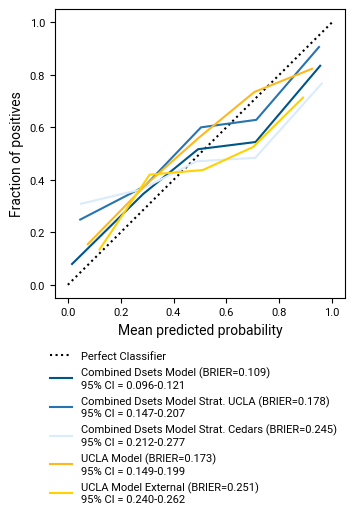

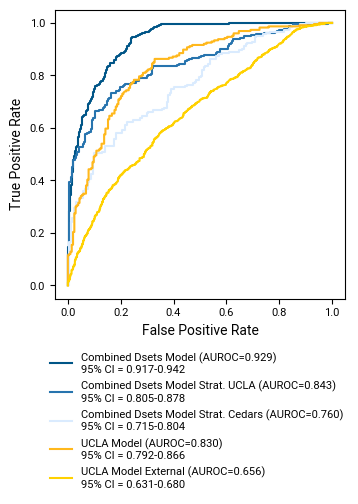

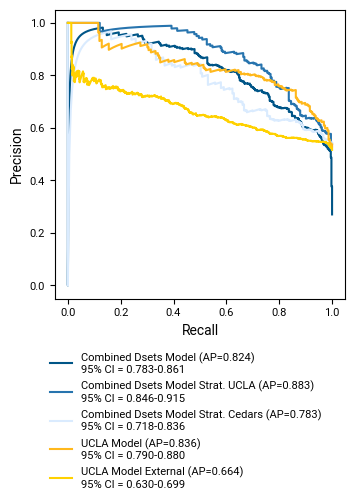

In [23]:
from models.static_models import CURVE_MAP

CURVE_PARAMS = {
    "calibration_curve": {
        "labels": ("prob_pred", "prob_true"),
        "limits": None,
        "metric": "brier",
    },
    "roc_curve": {"labels": ("fpr", "tpr"), "limits": (0, 1), "metric": "auroc"},
    "pr_curve": {"labels": ("recall", "precision"), "limits": None, "metric": "ap"},
    "det_curve": {"labels": ("fpr", "fnr"), "limits": None, "metric": "accuracy"},
}
curve_names = args.curve_names
curve_fns = [CURVE_MAP[metric] for metric in curve_names]
curve_params = [CURVE_PARAMS[metric] for metric in curve_names]

plt_labels = ['Combined Dsets Model', 'UCLA Model', "UCLA Model External"]
runs = [all_preselectall, ucla_train, ucla_train]
filters = ['', '', 'cedars_crrt']

subgroups = [""]
subgroup_labels = [""]
colors = ['#005587','#2774AE', '#DAEBFE', '#FFB81C', '#FFD100']
plot_metrics(curve_names, curve_fns, curve_params, 
             runs, filters, plt_labels, 
             subgroups, subgroup_labels, colors, 
             bootstrap_point=True)

# plt_labels = ['Combined Dsets Model', 'UCLA Model', "UCLA Model External"]
# runs = [all_preselectall, ucla_train, ucla_train]
# filters = ['', '', 'cedars_crrt']
# subgroups = ["_heart", "_liver", "_infection"]
# subgroup_labels = ["Heart", "Liver", "Infection"]
# colors = ['#446D00','#66A400', '#8ED000', '#56005D', '#9D00F1','#CD6FFF','#AF0000','#FF0000','#FF8787']
# plot_metrics(curve_names, curve_fns, curve_params, 
#              runs, filters, plt_labels, 
#              subgroups, subgroup_labels, colors, 
#              bootstrap_point=True)

uclapluscedars_to_uclapluscedars_preselectcrrt_tune50_v3__calibration_curve
uclapluscedars_to_uclapluscedars_preselectcrrt_tune50_v3__roc_curve
uclapluscedars_to_uclapluscedars_preselectcrrt_tune50_v3__pr_curve
cedars_to_cedars_tune50_v3__calibration_curve
cedars_to_cedars_tune50_v3__roc_curve
cedars_to_cedars_tune50_v3__pr_curve


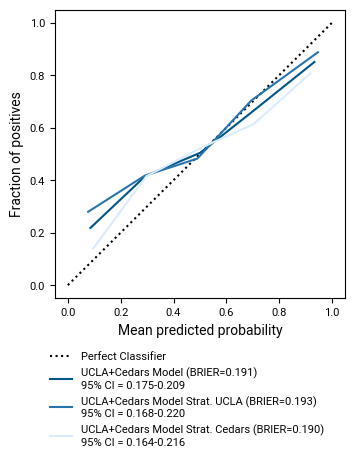

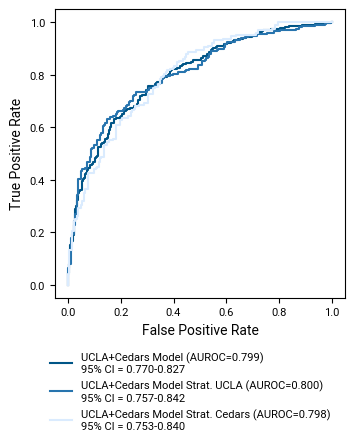

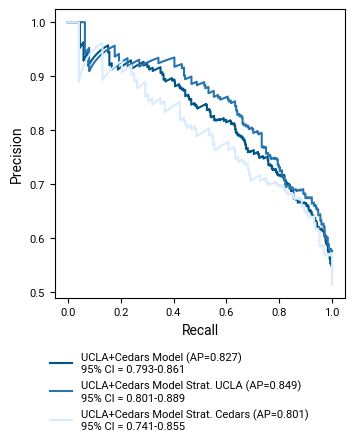

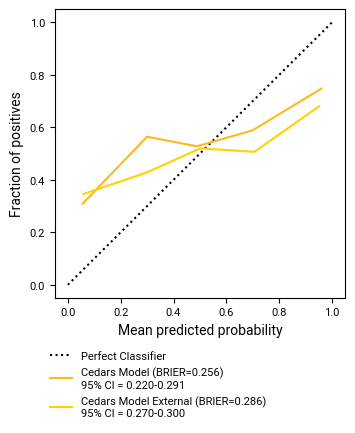

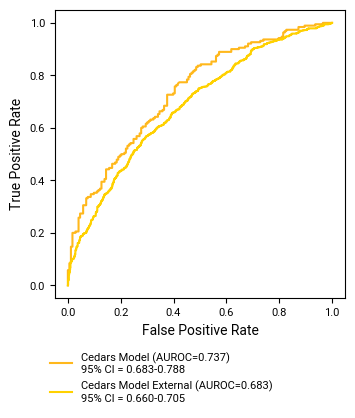

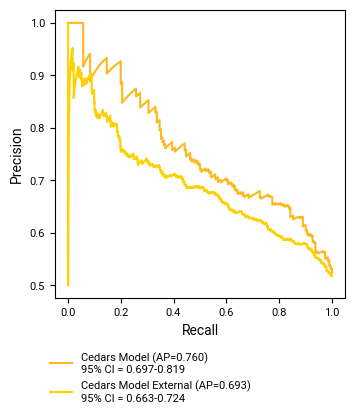

In [13]:
from models.static_models import CURVE_MAP

CURVE_PARAMS = {
    "calibration_curve": {
        "labels": ("prob_pred", "prob_true"),
        "limits": None,
        "metric": "brier",
    },
    "roc_curve": {"labels": ("fpr", "tpr"), "limits": (0, 1), "metric": "auroc"},
    "pr_curve": {"labels": ("recall", "precision"), "limits": None, "metric": "ap"},
    "det_curve": {"labels": ("fpr", "fnr"), "limits": None, "metric": "accuracy"},
}
curve_names = args.curve_names
curve_fns = [CURVE_MAP[metric] for metric in curve_names]
curve_params = [CURVE_PARAMS[metric] for metric in curve_names]

plt_labels = ['UCLA+Cedars Model']
runs = [uclapluscedars_preselectcrrt]
filters = ['']

subgroups = [""]
subgroup_labels = [""]
colors = ['#005587','#2774AE', '#DAEBFE', '#FFB81C', '#FFD100']
plot_metrics(curve_names, curve_fns, curve_params, 
             runs, filters, plt_labels, 
             subgroups, subgroup_labels, colors, 
             bootstrap_point=True)



plt_labels = ['Cedars Model', "Cedars Model External"]
runs = [cedars_train, cedars_train]
filters = ['', 'ucla_crrt']

subgroups = [""]
subgroup_labels = [""]
colors = [ '#FFB81C', '#FFD100']
plot_metrics(curve_names, curve_fns, curve_params, 
             runs, filters, plt_labels, 
             subgroups, subgroup_labels, colors, 
             bootstrap_point=True)

# Subgroups

## Helper functions

In [14]:
from models.static_models import METRIC_MAP
from evaluate.utils import bootstrap_metric, confidence_interval, eval_metric
from tqdm import tqdm
from collections import defaultdict
import matplotlib.colors as mcolors

def subgroup_tables(metric_names,
                    runs, filters,
                    subgroups, subgroup_labels,
                    eval_cohorts=None,
                    bootstrap_point=True):
    
    if eval_cohorts is None:
        for run,filter in zip(runs, filters):
            table = get_subgroup_table(metric_names, run, filter, subgroups, subgroup_labels, bootstrap_point=bootstrap_point)
            display(pd.DataFrame(table))
    else:
        for run,filter, eval_cohort in zip(runs, filters, eval_cohorts):
            table = get_subgroup_table(metric_names, run, filter, subgroups, subgroup_labels, bootstrap_point=bootstrap_point, eval_cohort=eval_cohort)
            display(pd.DataFrame(table))
        
def get_subgroup_table(metric_names, 
              run_name, filter,
              subgroups, subgroup_labels, 
              bootstrap_point=True,
              eval_cohort=None):
    
    table = {'counts': {}}

    if len(filter) > 0:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
    else:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")

    metrics = run.data.metrics

    for metric_name in tqdm(metric_names):
        
        metric_fn = METRIC_MAP[metric_name]
        table[metric_name] = {}
        
        for subgroup, subgroup_label in zip(subgroups, subgroup_labels):
            
            prefix = f"{run.data.tags['modeln']}_test{subgroup}"
            
            if 'control' not in filter:
                if f"{prefix}__{metric_name}" in metrics.keys() and (metrics[prefix+'__'+metric_name]==metrics[prefix+'__'+metric_name]):
                    _, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix, filter=eval_cohort)
                    
                    if eval_cohort is not None:
                        bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                        point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                        ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                    else:
                        point_estimate = get_point_estimate(metrics[prefix+'__'+metric_name], labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                        ci_low = metrics[f"{prefix}__{metric_name}_CI_low"]
                        ci_high = metrics[f"{prefix}__{metric_name}_CI_high"]
                    table[metric_name][subgroup_label] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                    
                    if len(labels.value_counts()) > 1:
                        table['counts'][subgroup_label] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                    else:
                        table['counts'][subgroup_label] = f"{len(labels)} (0%)"
                else:
                    try:
                        _, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix, filter=eval_cohort)
                        bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                        point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                        ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                        table[metric_name][subgroup_label] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                        if len(labels.value_counts()) > 1:
                            table['counts'][subgroup_label] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                        else:
                            table['counts'][subgroup_label] = f"{len(labels)} (0%)"
                    except:  
                        table[metric_name][subgroup_label] = "0.0 (0.0-0.0)"
                        table['counts'][subgroup_label] = "0 (0%)"
                    
                if 'plus' in run_name or 'all_to_all' in run_name:
                    try:          
                        prob_df, _, _ = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix, filter=eval_cohort)
                        
                        # ISOLATE UCLA
                        ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)]
                        labels = ucla_prob_df['recommend_crrt']
                        pred_probas = ucla_prob_df[0].values
                        
                        try:
                            bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                            point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                            ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                            table[metric_name][f"{subgroup_label} ucla_crrt"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                            
                            if len(labels.value_counts()) > 1:
                                table['counts'][f"{subgroup_label} ucla_crrt"] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                            else:
                                table['counts'][f"{subgroup_label} ucla_crrt"] = f"{len(labels)} (0%)"
                        except:
                            table[metric_name][f"{subgroup_label} ucla_crrt"] = "0.0 (0.0-0.0)"
                            table['counts'][f"{subgroup_label} ucla_crrt"] = "0 (0%)"
                        
                        # ISOLATE CEDARS
                        cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)]
                        labels = cedars_prob_df['recommend_crrt']
                        pred_probas = cedars_prob_df[0].values
                        try:
                            bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                            point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                            ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                            table[metric_name][f"{subgroup_label} cedars_crrt"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                            if len(labels.value_counts()) > 1:
                                table['counts'][f"{subgroup_label} cedars_crrt"] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                            else:
                                table['counts'][f"{subgroup_label} cedars_crrt"] = f"{len(labels)} (0%)"   
                        except:
                            table[metric_name][f"{subgroup_label} cedars_crrt"] = "0.0 (0.0-0.0)"
                            table['counts'][f"{subgroup_label} cedars_crrt"] = "0 (0%)"
                    except:
                        table[metric_name][f"{subgroup_label} ucla_crrt"] = "0.0 (0.0-0.0)"
                        table['counts'][f"{subgroup_label} ucla_crrt"] = "0 (0%)"
                        table[metric_name][f"{subgroup_label} cedars_crrt"] = "0.0 (0.0-0.0)"
                        table['counts'][f"{subgroup_label} cedars_crrt"] = "0 (0%)"
                                 
            else:
                # GET THE CONTROL
                try:
                    labels, pred_probas = get_control_probabilities(exp_path, run, run_name, prefix, filter=eval_cohort)
                    
                    # GET METRIC
                    bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)

                    point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)
                    ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                    table[metric_name][subgroup_label] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                    if len(labels.value_counts()) > 1:
                        table['counts'][subgroup_label] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                    else:
                        table['counts'][subgroup_label] = f"{len(labels)} (0%)"
                except:
                    table[metric_name][subgroup_label] = "0.0 (0.0-0.0)"
                    table['counts'][subgroup_label] = "0 (0%)"
    
    eval_cohort_str = ''
    if eval_cohort is not None:
        eval_cohort_str = f'_{eval_cohort}'
        
    with open(f'./posthoc/{run_name}_{filter}{eval_cohort_str}_subgroups.pkl', 'wb') as f:
        pickle.dump(table,f)   
         
    return table

def report_as_is(metric_names,
                    runs, filters,
                    subgroup_labels,
                    eval_cohorts=None):
    
    if eval_cohorts is None:
        eval_cohorts = [None]*len(runs)
        
    for run, filter, eval_cohort in zip(runs, filters,eval_cohorts):
        
        eval_cohort_str = ''
        if eval_cohort is not None:
            eval_cohort_str = f'_{eval_cohort}'
        
        with open(f'./posthoc/{run}_{filter}{eval_cohort_str}_subgroups.pkl', 'rb') as f:
            table = pickle.load(f)
                
        metric_table = {}    
        
        for metric_name in metric_names:
            metric_table[metric_name] = {}
                
            for subgroup_label in subgroup_labels:
                metric_table[metric_name][subgroup_label] = table[metric_name][subgroup_label]
    
                if ('plus' in run or 'all_to_all' in run) and 'control' not in filter:
                    metric_table[metric_name][f'{subgroup_label} ucla_crrt'] = table[metric_name][f'{subgroup_label} ucla_crrt']
                    metric_table[metric_name][f'{subgroup_label} cedars_crrt'] = table[metric_name][f'{subgroup_label} cedars_crrt']
                    
        display(pd.DataFrame(metric_table))

def report_subgroup_metrics(metric_names,
                    runs, filters,
                    subgroup_labels,
                    eval_cohorts=None):
    
    if eval_cohorts is None:
        eval_cohorts = [None]*len(runs)
        
    for metric_name in metric_names:
        metric_table = {}
        
        
        for subgroup_label in subgroup_labels:
            metric_table[subgroup_label] = {}
            
            for run, filter, eval_cohort in zip(runs, filters,eval_cohorts):
            
                eval_cohort_str = ''
                if eval_cohort is not None:
                    eval_cohort_str = f'_{eval_cohort}'
                
                with open(f'./posthoc/{run}_{filter}{eval_cohort_str}_subgroups.pkl', 'rb') as f:
                    table = pickle.load(f)
                
                metric_table[subgroup_label][f'{run} {filter}'] = table[metric_name][subgroup_label]
    
                if ('plus' in run or 'all_to_all' in run) and 'control' not in filter:
                    metric_table[subgroup_label][f'{run} {filter} ucla_crrt'] = table[metric_name][f'{subgroup_label} ucla_crrt']
                    metric_table[subgroup_label][f'{run} {filter} cedars_crrt'] = table[metric_name][f'{subgroup_label} cedars_crrt']
                    
        display(pd.DataFrame(metric_table))
    
def plot_subgroup(metric_names,
                    runs, filters, plt_labels,
                    subgroup_labels, subgroup_categories,
                    eval_cohorts=None,
                    strat=None,):
    
    if eval_cohorts is None:
        eval_cohorts = [None]*len(runs)
        
    for metric_name in metric_names:
        metric_table = defaultdict(list)
        ci_low_table = defaultdict(list)
        ci_high_table = defaultdict(list)
        
        for run, filter, eval_cohort in zip(runs, filters,eval_cohorts):      
            eval_cohort_str = ''
            if eval_cohort is not None:
                eval_cohort_str = f'_{eval_cohort}' 
            
            with open(f'./posthoc/{run}_{filter}{eval_cohort_str}_subgroups.pkl', 'rb') as f:
                table = pickle.load(f)
                
            for subgroup_label in subgroup_labels:
                metric_table[f'{run} {filter}'].append(float(table[metric_name][subgroup_label].split(' (')[0]))
                ci_low_table[f'{run} {filter}'].append(float(table[metric_name][subgroup_label].split('(')[-1].split('-')[0]))
                ci_high_table[f'{run} {filter}'].append(float(table[metric_name][subgroup_label].split('-')[-1].split(')')[0]))

                if ('plus' in run or 'all_to_all' in run) and 'control' not in filter and strat:
                    metric_table[f'{run} {filter} ucla_crrt'].append(float(table[metric_name][f'{subgroup_label} ucla_crrt'].split(' (')[0]))
                    ci_low_table[f'{run} {filter} ucla_crrt'].append(float(table[metric_name][f'{subgroup_label} ucla_crrt'].split('(')[-1].split('-')[0]))
                    ci_high_table[f'{run} {filter} ucla_crrt'].append(float(table[metric_name][f'{subgroup_label} ucla_crrt'].split('-')[-1].split(')')[0]))
                
                    metric_table[f'{run} {filter} cedars_crrt'].append(float(table[metric_name][f'{subgroup_label} cedars_crrt'].split(' (')[0]))
                    ci_low_table[f'{run} {filter} cedars_crrt'].append(float(table[metric_name][f'{subgroup_label} cedars_crrt'].split('(')[-1].split('-')[0]))
                    ci_high_table[f'{run} {filter} cedars_crrt'].append(float(table[metric_name][f'{subgroup_label} cedars_crrt'].split('-')[-1].split(')')[0]))
                        
        for key_ in metric_table.keys():
            ci_low_table[key_] = np.absolute(np.array(metric_table[key_]) - np.array(ci_low_table[key_]))
            ci_high_table[key_] = np.absolute(np.array(ci_high_table[key_]) - np.array(metric_table[key_]))
            
        # organize subgroups into broader categories (eg. age, race)
        x = []
        category_x = []
        category_labels = []
        prev_category = None
        current_category = None
        index = len(subgroup_labels) + len(np.unique(subgroup_categories)) - 1
        for i in range(len(subgroup_labels)):
            current_category = subgroup_categories[i]
            if current_category != prev_category:
                category_x.append(index)
                category_labels.append(current_category)
                index -= 1
                prev_category = current_category
            x.append(index)
            index -= 1
        x = np.array(x)
        
        # plotting
        fig, ax = plt.subplots()
        width = 0.25
        multiplier = 0
        
        for i, key_ in enumerate(metric_table.keys()):
            
            offset = width * multiplier
            
            # Horizontal
            # ax.bar(x + offset, grouped_metric_vals[i], width, label=plt_labels[i], yerr=[errors_low[i], errors_high[i]])
            # plt.errorbar(x + offset, grouped_metric_vals[i], yerr=[errors_low[i], errors_high[i]], marker="D", capsize=5, elinewidth=2,label=plt_labels[i])
            
            # Vertical
            ax.barh(x + offset, metric_table[key_], width, label=plt_labels[i], xerr=[ci_low_table[key_], ci_high_table[key_]],capsize=3)
            # plt.errorbar(metric_table[key_], x + offset, xerr=[ci_low_table[key_], ci_high_table[key_]], marker="D", 
            #              capsize=3, elinewidth=1,label=plt_labels[i], linestyle='none')
        
            
            # Plot a vertical line for main value (metric on all patients)
            # ax.plot([0., x[-1]], [grouped_metric_vals[0][0], grouped_metric_vals[0][0]], "k--")
            # ax.plot([0., x[-1]], [grouped_metric_vals[1][0], grouped_metric_vals[1][0]], "k--")
            ax.plot([metric_table[key_][0], metric_table[key_][0]], [0., x[0]], "k--", linewidth=1)
            
            multiplier += 1
        
        # Subgroup category labels
        ax.set_yticks(category_x, category_labels, minor=False, fontweight='bold')
        # Subgroup labels
        ax.set_yticks(x + width, subgroup_labels, minor=True)
        
        if metric_name not in ['TP', 'FP', 'TN', 'FN']:
            ax.set_xlim([0,1])
        ax.tick_params(axis='y', which='major', length=0)
        # plt.yticks(ha='left')
        # ax.set_title(name)
        ax.set_xlabel(metric_name.upper())
        ax.legend(loc="upper left", bbox_to_anchor=(-0.1, -0.05))
        
        # save figure
        name = f"{metric_name}_subgroup" 
        print(name)
        fig = plt.gcf()
        fig.set_size_inches(3, 10)
        plt.savefig(f'./posthoc/{name}_forestplot.svg', format='svg',  bbox_inches="tight")

def plot_subgroup_onerun(metric_names,
                    run, filter,
                    subgroup_labels, subgroup_categories,
                    eval_cohort=None,
                    strat=None,):
    
    # organize subgroups into broader categories (eg. age, race)
    x = []
    category_x = []
    category_labels = []
    prev_category = None
    current_category = None
    index = len(subgroup_labels) + len(np.unique(subgroup_categories)) - 1
    for i in range(len(subgroup_labels)):
        current_category = subgroup_categories[i]
        if current_category != prev_category:
            category_x.append(index)
            category_labels.append(current_category)
            index -= 1
            prev_category = current_category
        x.append(index)
        index -= 1
    x = np.array(x)
    
    # plotting
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set2.colors)

    fig, ax = plt.subplots()
    width = 0.3
    multiplier = 0
        
    metric_table = defaultdict(list)
    ci_low_table = defaultdict(list)
    ci_high_table = defaultdict(list)
    
    eval_cohort_str = ''
    if eval_cohort is not None:
        eval_cohort_str = f'_{eval_cohort}' 
    
    with open(f'./posthoc/{run}_{filter}{eval_cohort_str}_subgroups.pkl', 'rb') as f:
        table = pickle.load(f)
            
    subgroup_labels_with_counts = []
    for subgroup_label in subgroup_labels:
        lab_ = subgroup_label.replace('\ninfection','infection')
        subgroup_labels_with_counts.append(f"{lab_}\n N={table['counts'][subgroup_label]}")
        
    for metric_name in metric_names:
            
        for subgroup_label in subgroup_labels:
            metric_table[metric_name].append(float(table[metric_name][subgroup_label].split(' (')[0]))
            ci_low_table[metric_name].append(float(table[metric_name][subgroup_label].split('(')[-1].split('-')[0]))
            ci_high_table[metric_name].append(float(table[metric_name][subgroup_label].split('-')[-1].split(')')[0]))
            
            if ('plus' in run or 'all_to_all' in run) and 'control' not in filter and strat:
                metric_table[f'{metric_name} ucla_crrt'].append(float(table[metric_name][f'{subgroup_label} ucla_crrt'].split(' (')[0]))
                ci_low_table[f'{metric_name} ucla_crrt'].append(float(table[metric_name][f'{subgroup_label} ucla_crrt'].split('(')[-1].split('-')[0]))
                ci_high_table[f'{metric_name} ucla_crrt'].append(float(table[metric_name][f'{subgroup_label} ucla_crrt'].split('-')[-1].split(')')[0]))
            
                metric_table[f'{metric_name} cedars_crrt'].append(float(table[metric_name][f'{subgroup_label} cedars_crrt'].split(' (')[0]))
                ci_low_table[f'{metric_name} cedars_crrt'].append(float(table[metric_name][f'{subgroup_label} cedars_crrt'].split('(')[-1].split('-')[0]))
                ci_high_table[f'{metric_name} cedars_crrt'].append(float(table[metric_name][f'{subgroup_label} cedars_crrt'].split('-')[-1].split(')')[0]))
                        
    for key_ in metric_table.keys():
        ci_low_table[key_] = np.absolute(np.array(metric_table[key_]) - np.array(ci_low_table[key_]))
        ci_high_table[key_] = np.absolute(np.array(ci_high_table[key_]) - np.array(metric_table[key_]))
    
    # plt.rcParams['image.cmap'] = 'Set2'
    colors = ['#FF00A5','#00FFFF']
    for i, key_ in enumerate(metric_table.keys()):
        
        offset = width * multiplier
        
        # Horizontal
        # ax.bar(x + offset, grouped_metric_vals[i], width, label=plt_labels[i], yerr=[errors_low[i], errors_high[i]])
        # plt.errorbar(x + offset, grouped_metric_vals[i], yerr=[errors_low[i], errors_high[i]], marker="D", capsize=5, elinewidth=2,label=plt_labels[i])
        
        # Vertical
        ax.barh(x + offset, metric_table[key_], width, label=metric_names[i].upper(), xerr=[ci_low_table[key_], ci_high_table[key_]],capsize=2,color=colors[i])
        # plt.errorbar(metric_table[key_], x + offset, xerr=[ci_low_table[key_], ci_high_table[key_]], marker="D", 
        #              capsize=3, elinewidth=1,label=metric_names[i].upper(), linestyle='none')
    
        
        # Plot a vertical line for main value (metric on all patients)
        # ax.plot([0., x[-1]], [grouped_metric_vals[0][0], grouped_metric_vals[0][0]], "k--")
        # ax.plot([0., x[-1]], [grouped_metric_vals[1][0], grouped_metric_vals[1][0]], "k--")
        ax.plot([metric_table[key_][0], metric_table[key_][0]], [0., x[0]], "k--", linewidth=1, alpha=0.5)
        
        multiplier += 1
        
    # Subgroup category labels
    ax.set_yticks(category_x, category_labels, minor=False, fontweight='bold')
    # Subgroup labels
    ax.set_yticks(x + width*(multiplier-1)/2, subgroup_labels_with_counts, minor=True)
    
    if metric_name not in ['TP', 'FP', 'TN', 'FN']:
        ax.set_xlim([0,1])
    ax.tick_params(axis='y', which='major', length=0)
    # plt.yticks(ha='left')
    # ax.set_title(name)
    ax.set_xlabel('Value')
    ax.legend(loc="upper left", bbox_to_anchor=(0.0, 0.03),ncol=len(metric_table.keys()),
              frameon=False, columnspacing=0.5,handlelength=1,handletextpad=0.25)
    
    # save figure
    name = f"{run}{filter}_subgroup" 
    print(name)
    fig = plt.gcf()
    fig.set_size_inches(3, 10)
    plt.savefig(f'./posthoc/{name}_forestplot.svg', format='svg',  bbox_inches="tight")
    plt.show()
    plt.close()
                    

## Process subgroups

### No intersection

In [ ]:
metric_names = args.metric_names + ['specificity']

runs = [
        # ucla_train,
        # ucla_train,
        # ucla_train,
        # cedars_train,
        # cedars_train,
        # cedars_train,
        # uclapluscedars_train,
        # uclapluscedars_train,
        all_train
        ]
filters = [
            # '',
            # 'cedars_crrt',
            # 'ucla_control',
            # '',
            # 'ucla_crrt',
            # 'ucla_control',
            # '',
            # 'ucla_control',
            ''
            ]

subgroups = [
              "", "_heart", "_liver", "_infection",'_no_heart_liver_infection',
              '_female','_male', 
              '_American Indian or Alaska Native','_Asian','_Black or African American','_Native Hawaiian or Other Pacific Islander','_Multiple Races','_Unknown','_White or Caucasian',
              '_Hispanic or Latino','_Not Hispanic or Latino',
              '_age_20_to_30', '_age_30_to_40', '_age_40_to_50', '_age_50_to_60', '_age_60_to_70', '_age_70_to_80','_age_80_to_90','_age_90_to_100'
            ]
subgroup_labels = [
              "all", "heart", "liver", "infection","no heart,liver,\ninfection",
              'female','male', 
              'American Indian\nor Alaska Native','Asian','Black or African American','Native Hawaiian or\nOther Pacific Islander','Multiple Races','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino',
              '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100'
              ]

subgroup_categories = [
              "indicator", "indicator", "indicator", "indicator","indicator",
              'sex','sex', 
              'race','race','race','race','race','race','race',
              'ethnicity','ethnicity',
              'age','age','age','age','age','age','age','age'
              ]

subgroup_tables(metric_names,
                runs, filters,
                subgroups, subgroup_labels,
                bootstrap_point=True)


### Intersection

In [ ]:
runs = [
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectcrrt,
        ucla_preselectcrrt,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectcrrt,
        cedars_preselectcrrt,
        uclapluscedars_preselectall,
        uclapluscedars_preselectall,
        uclapluscedars_preselectcrrt,
        all_preselectall
]
filters = [
            "",
            "cedars_crrt",
            "ucla_control",
            "",
            "cedars_crrt",
            '',
            'ucla_crrt',
            'ucla_control',
            '',
            'ucla_crrt',
            '',
            'ucla_control',
            '',
            ''
            ]

subgroups = [
              "", "_heart", "_liver", "_infection",'_no_heart_liver_infection',
              '_female','_male', 
              '_American Indian or Alaska Native','_Asian','_Black or African American','_Native Hawaiian or Other Pacific Islander','_Multiple Races','_Unknown','_White or Caucasian',
              '_Hispanic or Latino','_Not Hispanic or Latino',
              '_age_20_to_30', '_age_30_to_40', '_age_40_to_50', '_age_50_to_60', '_age_60_to_70', '_age_70_to_80','_age_80_to_90','_age_90_to_100'
            ]
subgroup_labels = [
              "all", "heart", "liver", "infection","no heart,liver,\ninfection",
              'female','male', 
              'American Indian\nor Alaska Native','Asian','Black or African American','Native Hawaiian or\nOther Pacific Islander','Multiple Races','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino',
              '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100'
              ]

subgroup_categories = [
              "indicator", "indicator", "indicator", "indicator","indicator",
              'sex','sex', 
              'race','race','race','race','race','race','race',
              'ethnicity','ethnicity',
              'age','age','age','age','age','age','age','age'
              ]


subgroup_tables(metric_names,
                runs, filters,
                subgroups, subgroup_labels,
                bootstrap_point=True)

### CRRT Total Days > 7 included

In [ ]:
metric_names = args.metric_names + ['specificity']


runs = [
        # ucla_train,
        # ucla_train,
        # ucla_train,
        # cedars_train,
        # cedars_train,
        # cedars_train,
        # uclapluscedars_train,
        # uclapluscedars_train,
        all_train,
        # ucla_preselectall,
        # ucla_preselectall,
        # ucla_preselectall,
        # ucla_preselectcrrt,
        # ucla_preselectcrrt,
        # cedars_preselectall,
        # cedars_preselectall,
        # cedars_preselectall,
        # cedars_preselectcrrt,
        # cedars_preselectcrrt,
        # uclapluscedars_preselectall,
        # uclapluscedars_preselectall,
        # uclapluscedars_preselectcrrt,
        # all_preselectall
        ]
filters = [
            # '',
            # 'cedars_crrt',
            # 'ucla_control',
            # '',
            # 'ucla_crrt',
            # 'ucla_control',
            # '',
            # 'ucla_control',
            '',
            # "",
            # "cedars_crrt",
            # "ucla_control",
            # "",
            # "cedars_crrt",
            # '',
            # 'ucla_crrt',
            # 'ucla_control',
            # '',
            # 'ucla_crrt',
            # '',
            # 'ucla_control',
            # '',
            # ''
            ]
eval_cohorts = [
        #     'ucla_crrt',
        #     'cedars_crrt',
        #     'ucla_crrt',
        #     'cedars_crrt',
        #     'ucla_crrt',
        #     'ucla_crrt',
        #     'ucla_crrt+cedars_crrt',
        #     'ucla_crrt+cedars_crrt',
            'ucla_crrt+cedars_crrt',
            
            # "ucla_crrt",
            # "cedars_crrt",
            # "ucla_crrt",
            # 'ucla_crrt',
            # 'cedars_crrt',
            
            # "cedars_crrt",
            # "ucla_crrt",
            # "ucla_crrt",
            # 'cedars_crrt',
            # 'ucla_crrt',
            
            # 'ucla_crrt+cedars_crrt',
            # 'ucla_crrt+cedars_crrt',
            # 'ucla_crrt+cedars_crrt',
            # 'ucla_crrt+cedars_crrt'
            ]

subgroups = [
              "", "_heart", "_liver", "_infection",'_no_heart_liver_infection',
              '_female','_male', 
              '_American Indian or Alaska Native','_Asian','_Black or African American','_Native Hawaiian or Other Pacific Islander','_Multiple Races','_Unknown','_White or Caucasian',
              '_Hispanic or Latino','_Not Hispanic or Latino',
              '_age_20_to_30', '_age_30_to_40', '_age_40_to_50', '_age_50_to_60', '_age_60_to_70', '_age_70_to_80','_age_80_to_90','_age_90_to_100'
            ]
subgroup_labels = [
              "all", "heart", "liver", "infection","no heart,liver,\ninfection",
              'female','male', 
              'American Indian\nor Alaska Native','Asian','Black or African American','Native Hawaiian or\nOther Pacific Islander','Multiple Races','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino',
              '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100'
              ]

subgroup_categories = [
              "indicator", "indicator", "indicator", "indicator","indicator",
              'sex','sex', 
              'race','race','race','race','race','race','race',
              'ethnicity','ethnicity',
              'age','age','age','age','age','age','age','age'
              ]

subgroup_tables(metric_names,
                runs, filters,
                subgroups, subgroup_labels,
                bootstrap_point=True,
                eval_cohorts=eval_cohorts
                )


## Visualize subgroups

### All patients (CRRT Total Days > 7 included)

In [43]:
runs = [
        ucla_train,
        ucla_train,
        ucla_train,
        cedars_train,
        cedars_train,
        cedars_train,
        uclapluscedars_train,
        uclapluscedars_train,
        all_train,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectcrrt,
        ucla_preselectcrrt,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectcrrt,
        cedars_preselectcrrt,
        uclapluscedars_preselectall,
        uclapluscedars_preselectall,
        uclapluscedars_preselectcrrt,
        all_preselectall
        ]
filters = [
            '',
            'cedars_crrt',
            'ucla_control',
            '',
            'ucla_crrt',
            'ucla_control',
            '',
            'ucla_control',
            '',
            "",
            "cedars_crrt",
            "ucla_control",
            "",
            "cedars_crrt",
            '',
            'ucla_crrt',
            'ucla_control',
            '',
            'ucla_crrt',
            '',
            'ucla_control',
            '',
            ''
            ]
eval_cohorts = [
            'ucla_crrt',
            'cedars_crrt',
            'ucla_crrt',
            'cedars_crrt',
            'ucla_crrt',
            'ucla_crrt',
            'ucla_crrt+cedars_crrt',
            'ucla_crrt+cedars_crrt',
            'ucla_crrt+cedars_crrt',
            
            "ucla_crrt",
            "cedars_crrt",
            "ucla_crrt",
            'ucla_crrt',
            'cedars_crrt',
            
            "cedars_crrt",
            "ucla_crrt",
            "ucla_crrt",
            'cedars_crrt',
            'ucla_crrt',
            
            'ucla_crrt+cedars_crrt',
            'ucla_crrt+cedars_crrt',
            'ucla_crrt+cedars_crrt',
            'ucla_crrt+cedars_crrt'
            ]
subgroup_labels = [
              "all", "heart", "liver", "infection","no heart,liver,\ninfection",
              'female','male', 
              'American Indian\nor Alaska Native','Asian','Black or African American','Native Hawaiian or\nOther Pacific Islander','Multiple Races','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino',
              '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100'
              ]

report_subgroup_metrics(['counts','auroc', 'ap', 'brier'],
                runs, filters,
                subgroup_labels,
                eval_cohorts=eval_cohorts)

all  \
ucla_to_ucla_tune50_v3                              1956 (56.5%)   
ucla_to_ucla_tune50_v3 cedars_crrt                  2870 (54.3%)   
ucla_to_ucla_tune50_v3 ucla_control                 5372 (20.6%)   
cedars_to_cedars_tune50_v3                          1443 (57.0%)   
cedars_to_cedars_tune50_v3 ucla_crrt                3650 (54.2%)   
cedars_to_cedars_tune50_v3 ucla_control             7150 (27.7%)   
uclapluscedars_to_uclapluscedars_tune50_v3          3427 (57.2%)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...  1975 (57.5%)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...  1452 (56.7%)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  7126 (27.5%)   
all_to_all_tune50_v3                                4099 (45.9%)   
all_to_all_tune50_v3  ucla_crrt                     1947 (55.3%)   
all_to_all_tune50_v3  cedars_crrt                   1425 (56.5%)   
ucla_to_ucla_preselectall_tune50_v3                 1956 (56.5%)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     2870 (54.3%)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    5372 (20.6%)   
ucla_to_ucla_preselectcrrt_tune50_v3                1956 (56.5%)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    2870 (54.3%)   
cedars_to_cedars_preselectall_tune50_v3             1443 (57.0%)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   3650 (54.2%)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  7150 (27.7%)   
cedars_to_cedars_preselectcrrt_tune50_v3            1447 (57.6%)   
cedars_to_cedars_preselectcrrt_tune50_v3 ucla_crrt  3697 (54.2%)   
uclapluscedars_to_uclapluscedars_preselectall_t...  3427 (57.2%)   
uclapluscedars_to_uclapluscedars_preselectall_t...  1975 (57.5%)   
uclapluscedars_to_uclapluscedars_preselectall_t...  1452 (56.7%)   
uclapluscedars_to_uclapluscedars_preselectall_t...  7126 (27.5%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  3427 (57.2%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  1975 (57.5%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  1452 (56.7%)   
all_to_all_preselectall_tune50_v3                   4159 (46.5%)   
all_to_all_preselectall_tune50_v3  ucla_crrt        1974 (56.7%)   
all_to_all_preselectall_tune50_v3  cedars_crrt      1434 (56.9%)   

                                                           heart  \
ucla_to_ucla_tune50_v3                               677 (54.8%)   
ucla_to_ucla_tune50_v3 cedars_crrt                  1647 (50.6%)   
ucla_to_ucla_tune50_v3 ucla_control                 1605 (23.1%)   
cedars_to_cedars_tune50_v3                           861 (53.5%)   
cedars_to_cedars_tune50_v3 ucla_crrt                1526 (53.2%)   
cedars_to_cedars_tune50_v3 ucla_control             2511 (32.3%)   
uclapluscedars_to_uclapluscedars_tune50_v3          2034 (55.5%)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...   967 (56.8%)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...  1067 (54.3%)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  3402 (33.2%)   
all_to_all_tune50_v3                                1956 (48.2%)   
all_to_all_tune50_v3  ucla_crrt                      800 (55.0%)   
all_to_all_tune50_v3  cedars_crrt                    928 (54.1%)   
ucla_to_ucla_preselectall_tune50_v3                  677 (54.8%)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     1647 (50.6%)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    1605 (23.1%)   
ucla_to_ucla_preselectcrrt_tune50_v3                 677 (54.8%)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    1647 (50.6%)   
cedars_to_cedars_preselectall_tune50_v3              861 (53.5%)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   1526 (53.2%)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  2511 (32.3%)   
cedars_to_cedars_preselectcrrt_tune50_v3            1184 (56.0%)   
cedars_to_cedars_preselectcrrt_tune50_v3 ucla_crrt  2129 (53.9%)   
uclapluscedars_to_uclapluscedars_preselectall_t...  2034 (55.5%)   
uclapluscedars_to_uclapluscedars_preselectall_t.

all  \
ucla_to_ucla_tune50_v3                              0.67 (0.65-0.69)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.63 (0.61-0.65)   
ucla_to_ucla_tune50_v3 ucla_control                 0.62 (0.61-0.64)   
cedars_to_cedars_tune50_v3                          0.69 (0.66-0.72)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.65 (0.63-0.67)   
cedars_to_cedars_tune50_v3 ucla_control             0.57 (0.56-0.59)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.72 (0.70-0.74)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...  0.72 (0.70-0.74)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...  0.72 (0.70-0.75)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.64 (0.63-0.65)   
all_to_all_tune50_v3                                0.78 (0.76-0.79)   
all_to_all_tune50_v3  ucla_crrt                     0.67 (0.64-0.69)   
all_to_all_tune50_v3  cedars_crrt                   0.69 (0.66-0.71)   
ucla_to_ucla_preselectall_tune50_v3                 0.65 (0.63-0.68)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.64 (0.61-0.66)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.59 (0.57-0.61)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.65 (0.63-0.68)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.64 (0.61-0.66)   
cedars_to_cedars_preselectall_tune50_v3             0.68 (0.65-0.71)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.65 (0.63-0.67)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.57 (0.55-0.58)   
cedars_to_cedars_preselectcrrt_tune50_v3            0.74 (0.72-0.77)   
cedars_to_cedars_preselectcrrt_tune50_v3 ucla_crrt  0.70 (0.68-0.72)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.71 (0.70-0.73)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.71 (0.69-0.73)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.72 (0.69-0.75)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.64 (0.63-0.65)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.71 (0.70-0.73)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.70 (0.68-0.73)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.73 (0.70-0.76)   
all_to_all_preselectall_tune50_v3                   0.80 (0.79-0.82)   
all_to_all_preselectall_tune50_v3  ucla_crrt        0.70 (0.68-0.72)   
all_to_all_preselectall_tune50_v3  cedars_crrt      0.72 (0.69-0.74)   

                                                               heart  \
ucla_to_ucla_tune50_v3                              0.73 (0.69-0.77)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.68 (0.66-0.71)   
ucla_to_ucla_tune50_v3 ucla_control                 0.64 (0.61-0.67)   
cedars_to_cedars_tune50_v3                          0.72 (0.69-0.75)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.77 (0.74-0.79)   
cedars_to_cedars_tune50_v3 ucla_control             0.66 (0.64-0.68)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.75 (0.73-0.77)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...  0.76 (0.73-0.79)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...  0.75 (0.72-0.78)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.66 (0.64-0.68)   
all_to_all_tune50_v3                                0.79 (0.77-0.81)   
all_to_all_tune50_v3  ucla_crrt                     0.75 (0.71-0.78)   
all_to_all_tune50_v3  cedars_crrt                   0.72 (0.69-0.75)   
ucla_to_ucla_preselectall_tune50_v3                 0.73 (0.69-0.76)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.70 (0.68-0.73)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.62 (0.59-0.65)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.73 (0.69-0.76)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.70 (0.68-0.73)   
cedars_to_cedars_preselectall_tune50_v3             0.72 (0.69-0.75)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.75 (0.73-0.78)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.64 (0.62-0.66)   
cedars_to_cedars_preselectcrrt_t

all  \
ucla_to_ucla_tune50_v3                              0.70 (0.67-0.73)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.65 (0.63-0.68)   
ucla_to_ucla_tune50_v3 ucla_control                 0.27 (0.26-0.29)   
cedars_to_cedars_tune50_v3                          0.74 (0.71-0.77)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.68 (0.65-0.70)   
cedars_to_cedars_tune50_v3 ucla_control             0.33 (0.31-0.35)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.76 (0.74-0.78)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...  0.76 (0.74-0.79)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...  0.76 (0.73-0.79)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.36 (0.34-0.38)   
all_to_all_tune50_v3                                0.71 (0.69-0.74)   
all_to_all_tune50_v3  ucla_crrt                     0.71 (0.68-0.74)   
all_to_all_tune50_v3  cedars_crrt                   0.72 (0.69-0.76)   
ucla_to_ucla_preselectall_tune50_v3                 0.70 (0.67-0.73)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.66 (0.63-0.68)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.27 (0.25-0.29)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.70 (0.67-0.73)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.66 (0.63-0.68)   
cedars_to_cedars_preselectall_tune50_v3             0.73 (0.70-0.76)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.66 (0.64-0.69)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.33 (0.31-0.34)   
cedars_to_cedars_preselectcrrt_tune50_v3            0.80 (0.77-0.82)   
cedars_to_cedars_preselectcrrt_tune50_v3 ucla_crrt  0.73 (0.71-0.75)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.76 (0.74-0.78)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.75 (0.73-0.78)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.77 (0.74-0.80)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.37 (0.35-0.39)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.76 (0.73-0.78)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.75 (0.72-0.78)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.77 (0.74-0.80)   
all_to_all_preselectall_tune50_v3                   0.76 (0.74-0.78)   
all_to_all_preselectall_tune50_v3  ucla_crrt        0.76 (0.73-0.78)   
all_to_all_preselectall_tune50_v3  cedars_crrt      0.77 (0.75-0.80)   

                                                               heart  \
ucla_to_ucla_tune50_v3                              0.72 (0.67-0.78)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.67 (0.63-0.70)   
ucla_to_ucla_tune50_v3 ucla_control                 0.30 (0.26-0.33)   
cedars_to_cedars_tune50_v3                          0.76 (0.72-0.80)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.79 (0.76-0.82)   
cedars_to_cedars_tune50_v3 ucla_control             0.46 (0.43-0.50)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.78 (0.75-0.80)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...  0.79 (0.75-0.83)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...  0.77 (0.73-0.80)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.44 (0.41-0.47)   
all_to_all_tune50_v3                                0.76 (0.73-0.79)   
all_to_all_tune50_v3  ucla_crrt                     0.77 (0.73-0.82)   
all_to_all_tune50_v3  cedars_crrt                   0.75 (0.71-0.78)   
ucla_to_ucla_preselectall_tune50_v3                 0.74 (0.70-0.79)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.69 (0.66-0.72)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.30 (0.26-0.33)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.74 (0.70-0.79)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.69 (0.66-0.72)   
cedars_to_cedars_preselectall_tune50_v3             0.75 (0.70-0.79)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.77 (0.75-0.80)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.43 (0.40-0.47)   
cedars_to_cedars_preselectcrrt_t

all  \
ucla_to_ucla_tune50_v3                              0.26 (0.24-0.27)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.26 (0.25-0.27)   
ucla_to_ucla_tune50_v3 ucla_control                 0.36 (0.35-0.37)   
cedars_to_cedars_tune50_v3                          0.28 (0.26-0.30)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.30 (0.29-0.31)   
cedars_to_cedars_tune50_v3 ucla_control             0.41 (0.40-0.41)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.23 (0.22-0.24)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...  0.24 (0.22-0.25)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...  0.23 (0.21-0.24)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.34 (0.34-0.35)   
all_to_all_tune50_v3                                0.21 (0.20-0.22)   
all_to_all_tune50_v3  ucla_crrt                     0.27 (0.26-0.28)   
all_to_all_tune50_v3  cedars_crrt                   0.24 (0.23-0.26)   
ucla_to_ucla_preselectall_tune50_v3                 0.27 (0.26-0.29)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.26 (0.25-0.27)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.39 (0.38-0.40)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.27 (0.26-0.29)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.26 (0.25-0.27)   
cedars_to_cedars_preselectall_tune50_v3             0.29 (0.27-0.31)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.31 (0.29-0.32)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.40 (0.39-0.41)   
cedars_to_cedars_preselectcrrt_tune50_v3            0.22 (0.20-0.23)   
cedars_to_cedars_preselectcrrt_tune50_v3 ucla_crrt  0.23 (0.23-0.24)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.24 (0.23-0.24)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.24 (0.23-0.26)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.23 (0.21-0.24)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.34 (0.33-0.34)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.24 (0.23-0.25)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.24 (0.23-0.26)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.22 (0.21-0.24)   
all_to_all_preselectall_tune50_v3                   0.22 (0.21-0.23)   
all_to_all_preselectall_tune50_v3  ucla_crrt        0.27 (0.26-0.29)   
all_to_all_preselectall_tune50_v3  cedars_crrt      0.26 (0.24-0.28)   

                                                               heart  \
ucla_to_ucla_tune50_v3                              0.24 (0.21-0.26)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.25 (0.24-0.26)   
ucla_to_ucla_tune50_v3 ucla_control                 0.39 (0.37-0.41)   
cedars_to_cedars_tune50_v3                          0.27 (0.25-0.30)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.23 (0.21-0.24)   
cedars_to_cedars_tune50_v3 ucla_control             0.33 (0.32-0.35)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.22 (0.21-0.24)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...  0.22 (0.20-0.24)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...  0.22 (0.20-0.24)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.34 (0.32-0.35)   
all_to_all_tune50_v3                                0.20 (0.19-0.21)   
all_to_all_tune50_v3  ucla_crrt                     0.22 (0.20-0.24)   
all_to_all_tune50_v3  cedars_crrt                   0.23 (0.22-0.25)   
ucla_to_ucla_preselectall_tune50_v3                 0.24 (0.22-0.27)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.24 (0.23-0.26)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.42 (0.40-0.43)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.24 (0.22-0.27)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.24 (0.23-0.26)   
cedars_to_cedars_preselectall_tune50_v3             0.27 (0.24-0.29)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.25 (0.23-0.26)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.32 (0.31-0.34)   
cedars_to_cedars_preselectcrrt_t

### CRRT Total Days < 7

In [44]:
runs = [
        ucla_train,
        ucla_train,
        ucla_train,
        cedars_train,
        cedars_train,
        cedars_train,
        uclapluscedars_train,
        uclapluscedars_train,
        all_train,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectcrrt,
        ucla_preselectcrrt,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectcrrt,
        cedars_preselectcrrt,
        uclapluscedars_preselectall,
        uclapluscedars_preselectall,
        uclapluscedars_preselectcrrt,
        all_preselectall
        ]
filters = [
            '',
            'cedars_crrt',
            'ucla_control',
            '',
            'ucla_crrt',
            'ucla_control',
            '',
            'ucla_control',
            '',
            "",
            "cedars_crrt",
            "ucla_control",
            "",
            "cedars_crrt",
            '',
            'ucla_crrt',
            'ucla_control',
            '',
            'ucla_crrt',
            '',
            'ucla_control',
            '',
            ''
            ]

report_subgroup_metrics(['counts','auroc', 'ap','brier'],
                runs, filters,
                subgroup_labels)

all  \
ucla_to_ucla_tune50_v3                               430 (52.6%)   
ucla_to_ucla_tune50_v3 cedars_crrt                  1790 (51.6%)   
ucla_to_ucla_tune50_v3 ucla_control                  3846 (5.9%)   
cedars_to_cedars_tune50_v3                           363 (52.3%)   
cedars_to_cedars_tune50_v3 ucla_crrt                2122 (51.7%)   
cedars_to_cedars_tune50_v3 ucla_control             5622 (19.5%)   
uclapluscedars_to_uclapluscedars_tune50_v3           803 (54.7%)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...   431 (57.5%)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...   372 (51.3%)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...   4502 (9.8%)   
all_to_all_tune50_v3                                1485 (24.4%)   
all_to_all_tune50_v3  ucla_crrt                      413 (46.2%)   
all_to_all_tune50_v3  cedars_crrt                    345 (49.9%)   
ucla_to_ucla_preselectall_tune50_v3                  430 (52.6%)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     1790 (51.6%)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control     3846 (5.9%)   
ucla_to_ucla_preselectcrrt_tune50_v3                 430 (52.6%)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    1790 (51.6%)   
cedars_to_cedars_preselectall_tune50_v3              363 (52.3%)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   2122 (51.7%)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  5622 (19.5%)   
cedars_to_cedars_preselectcrrt_tune50_v3             366 (54.6%)   
cedars_to_cedars_preselectcrrt_tune50_v3 ucla_crrt  2148 (51.8%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   803 (54.7%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   431 (57.5%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   372 (51.3%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   4502 (9.8%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   803 (54.7%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   431 (57.5%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   372 (51.3%)   
all_to_all_preselectall_tune50_v3                   1535 (27.0%)   
all_to_all_preselectall_tune50_v3  ucla_crrt         430 (54.0%)   
all_to_all_preselectall_tune50_v3  cedars_crrt       354 (51.7%)   

                                                           heart  \
ucla_to_ucla_tune50_v3                               157 (47.8%)   
ucla_to_ucla_tune50_v3 cedars_crrt                  1048 (48.3%)   
ucla_to_ucla_tune50_v3 ucla_control                  1085 (6.9%)   
cedars_to_cedars_tune50_v3                           217 (47.9%)   
cedars_to_cedars_tune50_v3 ucla_crrt                 959 (51.0%)   
cedars_to_cedars_tune50_v3 ucla_control             1944 (25.2%)   
uclapluscedars_to_uclapluscedars_tune50_v3           519 (51.8%)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...   239 (54.0%)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...   280 (50.0%)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  1887 (14.3%)   
all_to_all_tune50_v3                                 654 (31.7%)   
all_to_all_tune50_v3  ucla_crrt                      192 (46.9%)   
all_to_all_tune50_v3  cedars_crrt                    234 (50.0%)   
ucla_to_ucla_preselectall_tune50_v3                  157 (47.8%)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     1048 (48.3%)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control     1085 (6.9%)   
ucla_to_ucla_preselectcrrt_tune50_v3                 157 (47.8%)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    1048 (48.3%)   
cedars_to_cedars_preselectall_tune50_v3              217 (47.9%)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt    959 (51.0%)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  1944 (25.2%)   
cedars_to_cedars_preselectcrrt_tune50_v3             298 (51.7%)   
cedars_to_cedars_preselectcrrt_tune50_v3 ucla_crrt  1313 (50.9%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   519 (51.8%)   
uclapluscedars_to_uclapluscedars_preselectall_t.

all  \
ucla_to_ucla_tune50_v3                              0.83 (0.79-0.87)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.66 (0.63-0.68)   
ucla_to_ucla_tune50_v3 ucla_control                 0.64 (0.60-0.68)   
cedars_to_cedars_tune50_v3                          0.74 (0.68-0.79)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.68 (0.66-0.70)   
cedars_to_cedars_tune50_v3 ucla_control             0.57 (0.55-0.59)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.81 (0.78-0.84)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...  0.83 (0.79-0.86)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...  0.78 (0.74-0.83)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.62 (0.59-0.65)   
all_to_all_tune50_v3                                0.92 (0.90-0.93)   
all_to_all_tune50_v3  ucla_crrt                     0.80 (0.76-0.84)   
all_to_all_tune50_v3  cedars_crrt                   0.75 (0.70-0.80)   
ucla_to_ucla_preselectall_tune50_v3                 0.79 (0.75-0.83)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.66 (0.64-0.69)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.58 (0.54-0.62)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.79 (0.75-0.83)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.66 (0.64-0.69)   
cedars_to_cedars_preselectall_tune50_v3             0.72 (0.66-0.77)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.68 (0.66-0.70)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.57 (0.55-0.59)   
cedars_to_cedars_preselectcrrt_tune50_v3            0.78 (0.74-0.83)   
cedars_to_cedars_preselectcrrt_tune50_v3 ucla_crrt  0.73 (0.71-0.75)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.80 (0.77-0.83)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.81 (0.76-0.84)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.79 (0.74-0.83)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.62 (0.60-0.65)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.80 (0.77-0.83)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.80 (0.76-0.84)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.80 (0.75-0.84)   
all_to_all_preselectall_tune50_v3                   0.93 (0.92-0.94)   
all_to_all_preselectall_tune50_v3  ucla_crrt        0.84 (0.81-0.88)   
all_to_all_preselectall_tune50_v3  cedars_crrt      0.76 (0.72-0.80)   

                                                               heart  \
ucla_to_ucla_tune50_v3                              0.91 (0.86-0.95)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.71 (0.68-0.74)   
ucla_to_ucla_tune50_v3 ucla_control                 0.62 (0.57-0.68)   
cedars_to_cedars_tune50_v3                          0.77 (0.71-0.83)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.79 (0.76-0.81)   
cedars_to_cedars_tune50_v3 ucla_control             0.63 (0.60-0.66)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.82 (0.79-0.86)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...  0.86 (0.81-0.90)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...  0.79 (0.73-0.84)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.61 (0.58-0.64)   
all_to_all_tune50_v3                                0.91 (0.89-0.93)   
all_to_all_tune50_v3  ucla_crrt                     0.84 (0.79-0.89)   
all_to_all_tune50_v3  cedars_crrt                   0.81 (0.75-0.86)   
ucla_to_ucla_preselectall_tune50_v3                 0.87 (0.82-0.92)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.73 (0.70-0.76)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.58 (0.52-0.64)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.87 (0.82-0.92)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.73 (0.70-0.76)   
cedars_to_cedars_preselectall_tune50_v3             0.78 (0.72-0.84)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.78 (0.75-0.81)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.63 (0.60-0.66)   
cedars_to_cedars_preselectcrrt_t

all  \
ucla_to_ucla_tune50_v3                              0.84 (0.79-0.88)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.66 (0.63-0.70)   
ucla_to_ucla_tune50_v3 ucla_control                 0.10 (0.08-0.12)   
cedars_to_cedars_tune50_v3                          0.76 (0.70-0.82)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.69 (0.66-0.72)   
cedars_to_cedars_tune50_v3 ucla_control             0.24 (0.22-0.26)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.84 (0.80-0.87)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...  0.87 (0.82-0.91)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...  0.80 (0.74-0.85)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.13 (0.12-0.15)   
all_to_all_tune50_v3                                0.77 (0.72-0.81)   
all_to_all_tune50_v3  ucla_crrt                     0.81 (0.75-0.85)   
all_to_all_tune50_v3  cedars_crrt                   0.73 (0.66-0.81)   
ucla_to_ucla_preselectall_tune50_v3                 0.81 (0.77-0.86)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.67 (0.63-0.70)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.09 (0.07-0.11)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.81 (0.77-0.86)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.67 (0.63-0.70)   
cedars_to_cedars_preselectall_tune50_v3             0.74 (0.67-0.80)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.68 (0.66-0.72)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.24 (0.22-0.26)   
cedars_to_cedars_preselectcrrt_tune50_v3            0.81 (0.75-0.86)   
cedars_to_cedars_preselectcrrt_tune50_v3 ucla_crrt  0.74 (0.71-0.76)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.83 (0.80-0.86)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.86 (0.82-0.90)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.80 (0.73-0.85)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.14 (0.12-0.16)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.83 (0.79-0.86)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.85 (0.80-0.89)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.80 (0.74-0.85)   
all_to_all_preselectall_tune50_v3                   0.82 (0.78-0.86)   
all_to_all_preselectall_tune50_v3  ucla_crrt        0.88 (0.85-0.91)   
all_to_all_preselectall_tune50_v3  cedars_crrt      0.78 (0.72-0.84)   

                                                               heart  \
ucla_to_ucla_tune50_v3                              0.91 (0.85-0.95)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.68 (0.64-0.73)   
ucla_to_ucla_tune50_v3 ucla_control                 0.09 (0.07-0.12)   
cedars_to_cedars_tune50_v3                          0.78 (0.71-0.85)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.80 (0.76-0.84)   
cedars_to_cedars_tune50_v3 ucla_control             0.36 (0.32-0.40)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.84 (0.80-0.88)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...  0.88 (0.82-0.93)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...  0.80 (0.74-0.86)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.18 (0.15-0.20)   
all_to_all_tune50_v3                                0.81 (0.76-0.86)   
all_to_all_tune50_v3  ucla_crrt                     0.83 (0.77-0.90)   
all_to_all_tune50_v3  cedars_crrt                   0.80 (0.73-0.87)   
ucla_to_ucla_preselectall_tune50_v3                 0.87 (0.80-0.93)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.69 (0.65-0.74)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.10 (0.07-0.14)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.87 (0.80-0.93)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.69 (0.65-0.74)   
cedars_to_cedars_preselectall_tune50_v3             0.78 (0.70-0.85)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.79 (0.76-0.83)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.34 (0.30-0.38)   
cedars_to_cedars_preselectcrrt_t

all  \
ucla_to_ucla_tune50_v3                              0.17 (0.15-0.20)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.25 (0.24-0.26)   
ucla_to_ucla_tune50_v3 ucla_control                 0.39 (0.38-0.40)   
cedars_to_cedars_tune50_v3                          0.26 (0.22-0.29)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.29 (0.27-0.30)   
cedars_to_cedars_tune50_v3 ucla_control             0.43 (0.42-0.44)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.18 (0.17-0.20)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...  0.17 (0.15-0.20)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...  0.20 (0.17-0.22)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.40 (0.39-0.41)   
all_to_all_tune50_v3                                0.10 (0.09-0.11)   
all_to_all_tune50_v3  ucla_crrt                     0.19 (0.16-0.21)   
all_to_all_tune50_v3  cedars_crrt                   0.21 (0.19-0.24)   
ucla_to_ucla_preselectall_tune50_v3                 0.20 (0.17-0.23)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.25 (0.24-0.26)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.42 (0.41-0.43)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.20 (0.17-0.23)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.25 (0.24-0.26)   
cedars_to_cedars_preselectall_tune50_v3             0.26 (0.23-0.30)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.29 (0.28-0.31)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.42 (0.41-0.43)   
cedars_to_cedars_preselectcrrt_tune50_v3            0.20 (0.17-0.23)   
cedars_to_cedars_preselectcrrt_tune50_v3 ucla_crrt  0.22 (0.21-0.23)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.19 (0.18-0.21)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.19 (0.17-0.22)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.20 (0.17-0.22)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.39 (0.38-0.40)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.19 (0.17-0.21)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.19 (0.17-0.22)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.19 (0.16-0.22)   
all_to_all_preselectall_tune50_v3                   0.11 (0.10-0.12)   
all_to_all_preselectall_tune50_v3  ucla_crrt        0.18 (0.15-0.21)   
all_to_all_preselectall_tune50_v3  cedars_crrt      0.24 (0.21-0.28)   

                                                               heart  \
ucla_to_ucla_tune50_v3                              0.13 (0.09-0.16)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.24 (0.22-0.25)   
ucla_to_ucla_tune50_v3 ucla_control                 0.45 (0.42-0.47)   
cedars_to_cedars_tune50_v3                          0.24 (0.19-0.28)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.22 (0.20-0.24)   
cedars_to_cedars_tune50_v3 ucla_control             0.36 (0.34-0.38)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.18 (0.16-0.20)   
uclapluscedars_to_uclapluscedars_tune50_v3  ucl...  0.16 (0.12-0.19)   
uclapluscedars_to_uclapluscedars_tune50_v3  ced...  0.20 (0.17-0.23)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.42 (0.40-0.43)   
all_to_all_tune50_v3                                0.12 (0.10-0.14)   
all_to_all_tune50_v3  ucla_crrt                     0.17 (0.13-0.21)   
all_to_all_tune50_v3  cedars_crrt                   0.19 (0.16-0.22)   
ucla_to_ucla_preselectall_tune50_v3                 0.15 (0.11-0.19)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.23 (0.21-0.25)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.49 (0.46-0.51)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.15 (0.11-0.19)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.23 (0.21-0.25)   
cedars_to_cedars_preselectall_tune50_v3             0.22 (0.18-0.26)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.23 (0.21-0.25)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.33 (0.32-0.35)   
cedars_to_cedars_preselectcrrt_t

### Plot subgroups

all_to_all_preselectall_tune50_v3_subgroup


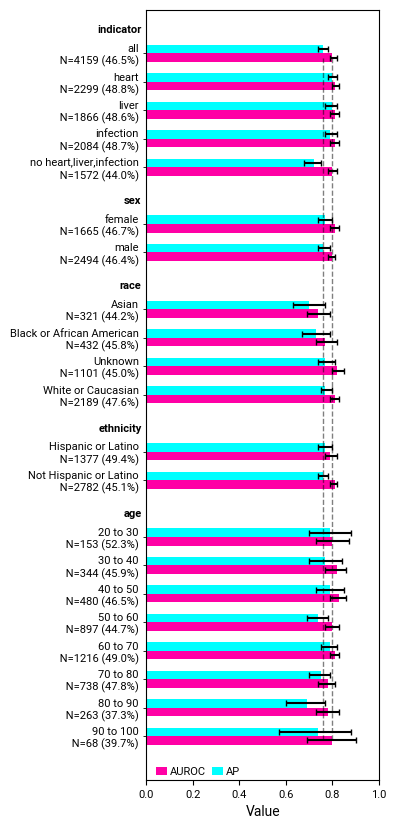

In [16]:
metric_names = ['auroc', 'ap']

run =  all_preselectall
filter = ''
eval_cohort = 'ucla_crrt+cedars_crrt'

subgroup_labels = [
              "all", "heart", "liver", "infection","no heart,liver,\ninfection",
              'female','male', 
        #       'American Indian\nor Alaska Native','Native Hawaiian or\nOther Pacific Islander','Multiple Races',
              'Asian','Black or African American','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino',
              '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100'
              ]
subgroup_categories = [
              "indicator", "indicator", "indicator", "indicator","indicator",
              'sex','sex', 
        #       'race','race','race',
              'race','race','race','race',
              'ethnicity','ethnicity',
              'age','age','age','age','age','age','age','age'
              ]
plot_subgroup_onerun(metric_names,
                run, filter,
                subgroup_labels, subgroup_categories,
                eval_cohort=eval_cohort,
                strat=False)

ucla_to_ucla_tune50_v3_subgroup


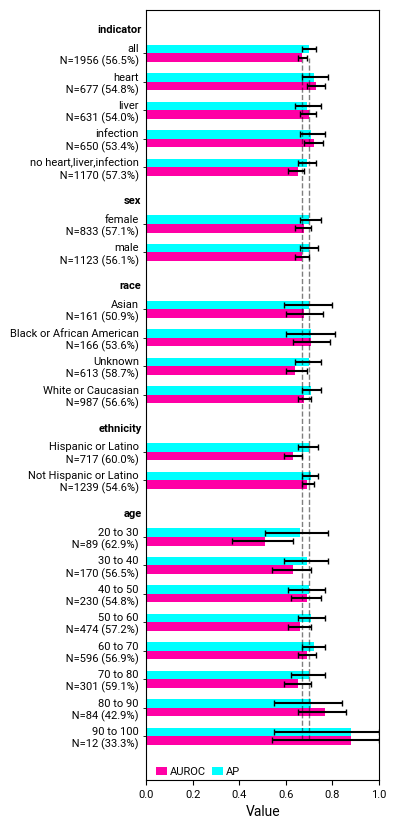

ucla_to_ucla_tune50_v3cedars_crrt_subgroup


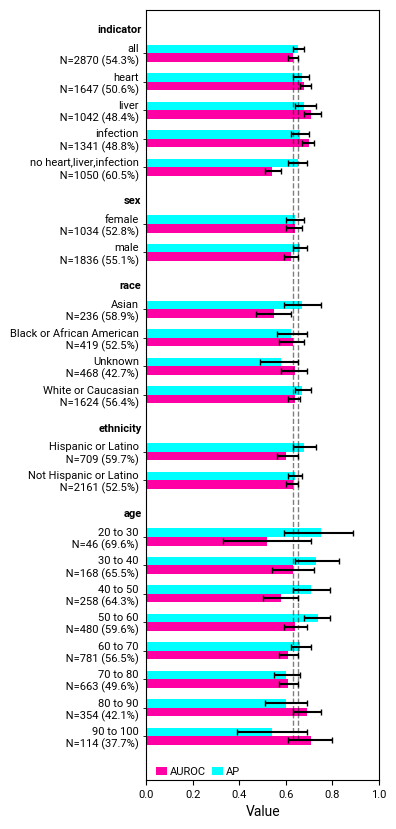

cedars_to_cedars_tune50_v3_subgroup


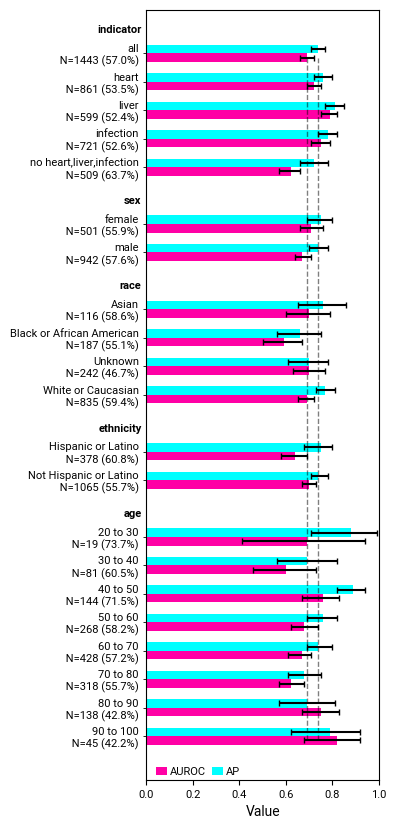

cedars_to_cedars_tune50_v3ucla_crrt_subgroup


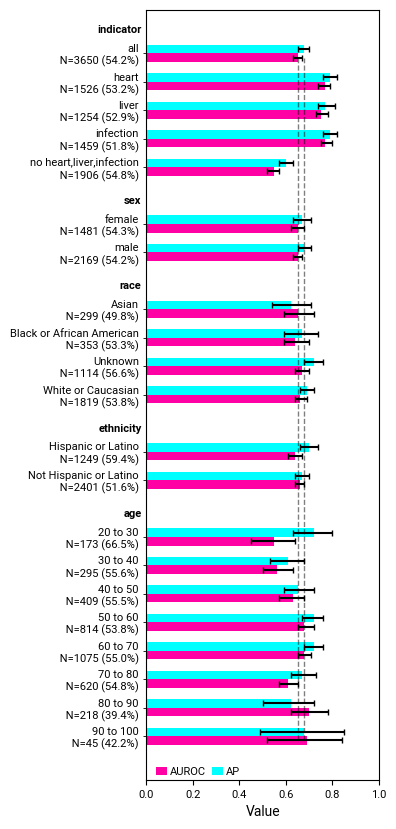

uclapluscedars_to_uclapluscedars_preselectcrrt_tune50_v3_subgroup


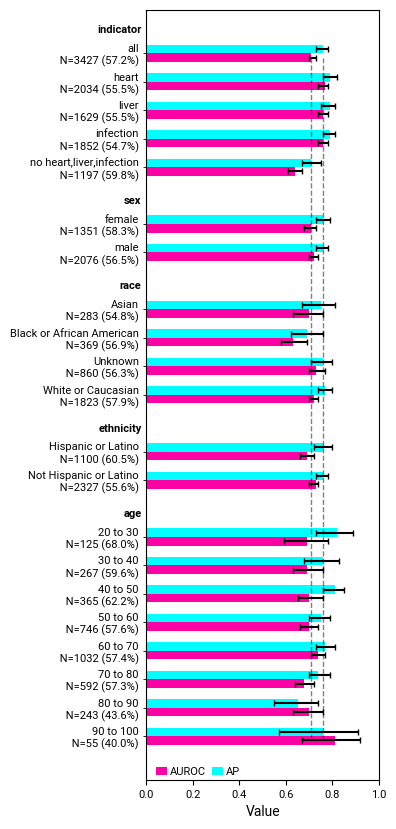

In [18]:
run =  ucla_train
filter = ''
eval_cohort = 'ucla_crrt'
plot_subgroup_onerun(metric_names,
                run, filter,
                subgroup_labels, subgroup_categories,
                eval_cohort=eval_cohort,
                strat=False)

run =  ucla_train
filter = 'cedars_crrt'
eval_cohort = 'cedars_crrt'
plot_subgroup_onerun(metric_names,
                run, filter,
                subgroup_labels, subgroup_categories,
                eval_cohort=eval_cohort,
                strat=False)

run =  cedars_train
filter = ''
eval_cohort = 'cedars_crrt'
plot_subgroup_onerun(metric_names,
                run, filter,
                subgroup_labels, subgroup_categories,
                eval_cohort=eval_cohort,
                strat=False)

run =  cedars_train
filter = 'ucla_crrt'
eval_cohort = 'ucla_crrt'
plot_subgroup_onerun(metric_names,
                run, filter,
                subgroup_labels, subgroup_categories,
                eval_cohort=eval_cohort,
                strat=False)

run =  uclapluscedars_preselectcrrt
filter = ''
eval_cohort = 'ucla_crrt+cedars_crrt'
plot_subgroup_onerun(metric_names,
                run, filter,
                subgroup_labels, subgroup_categories,
                eval_cohort=eval_cohort,
                strat=False)

# Rolling window

## Helper functions

In [19]:
from models.static_models import METRIC_MAP
from evaluate.utils import bootstrap_metric, confidence_interval, eval_metric
from tqdm import tqdm
from collections import defaultdict

def rolling_count(runs, filters, slides):
    
    table = {}

    # get run
    for j in range(len(runs)):
        for k in tqdm(slides):
            
            if len(filters[j]) > 0:
                if k == 0:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // post_eval_{filters[j]} best'")
                else:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // post_eval_{filters[j]} rolling window: {k}'")
            else:
                if k == 0:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // eval best'")
                else:
                    # run, _ = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]}' and tags.slide_window_by='{k}'")
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // rolling window: {k}'")
                        
            if k not in table.keys():
                table[k] = {}
            
            prefix = f"{run.data.tags['modeln']}_test"
            
            if 'control' not in filters[j]:
                
                prob_df, labels, _ = get_original_probabilities(exp_path, run.info.run_id, runs[j], prefix)
                total_len = len(labels)
                # total_len = len(prob_df.index.get_level_values('IP_PATIENT_ID').unique())
                table[k][f"{runs[j]} {filters[j]}"] = f"{total_len} ({labels.value_counts()[1]/total_len*100:.2f}%)"
                    
                if 'plus' in runs[j] or 'all_to_all' in runs[j]:
                    prob_df, _, _ = get_original_probabilities(exp_path, run.info.run_id, runs[j], prefix)
                    
                    # ISOLATE UCLA
                    ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)]
                    labels = ucla_prob_df['recommend_crrt']
                    total_len = len(labels)
                    # total_len = len(ucla_prob_df.index.get_level_values('IP_PATIENT_ID').unique())
                    table[k][f"{runs[j]} ucla_crrt"] = f"{total_len} ({labels.value_counts()[1]/total_len*100:.2f}%)"
                    
                    # ISOLATE CEDARS
                    cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)]
                    labels = cedars_prob_df['recommend_crrt']
                    total_len = len(labels)
                    # total_len = len(cedars_prob_df.index.get_level_values('IP_PATIENT_ID').unique())
                    table[k][f"{runs[j]} cedars_crrt"] = f"{total_len} ({labels.value_counts()[1]/total_len*100:.2f}%)"
                             
            else:
                labels, _ = get_control_probabilities(exp_path, run, runs[j], prefix, slide=k)
                table[k][f"{runs[j]} {filters[j]}"] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.2f}%)"
                
    return table

def rolling_tables(metric_names,
                    runs, filters, 
                     slides, 
                     subgroups,
                     bootstrap_point=True,
                     tag=''):

    for metric_name in metric_names:
        for subgroup in subgroups:
            table = get_rolling_table(metric_name, runs, filters, slides, subgroup=subgroup, bootstrap_point=bootstrap_point, tag=tag)
            display(pd.DataFrame(table))

def get_rolling_table(metric_name,
                     runs, filters, 
                     slides, 
                     subgroup="",
                     bootstrap_point=True,
                     tag=''):
    
    metric_fn = METRIC_MAP[metric_name]
    table = {}

    # get run
    for j in range(len(runs)):
        for k in tqdm(slides):
            
            if len(filters[j]) > 0:
                if k == 0:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // post_eval_{filters[j]} best'")
                else:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // post_eval_{filters[j]} rolling window: {k}'")
            else:
                if k == 0:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // eval best'")
                else:
                    # run, _ = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]}' and tags.slide_window_by='{k}'")
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // rolling window: {k}'")
                        
            if k not in table.keys():
                table[k] = {}
            
            metrics = run.data.metrics            
            prefix = f"{run.data.tags['modeln']}_test{subgroup}"
            
            if 'control' not in filters[j]:
            
                if f"{prefix}__{metric_name}" in metrics.keys():
                    _, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, runs[j], prefix)
                    point_estimate = get_point_estimate(metrics[prefix+'__'+metric_name], labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                    ci_low = metrics[f"{prefix}__{metric_name}_CI_low"]
                    ci_high = metrics[f"{prefix}__{metric_name}_CI_high"]
                    table[k][f"{runs[j]} {filters[j]}"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                else:
                    table[k][f"{runs[j]} {filters[j]}"] = "0.0 (0.0-0.0)"
                    
                if 'plus' in runs[j] or 'all_to_all' in runs[j]:
                    prob_df, _, _ = get_original_probabilities(exp_path, run.info.run_id, runs[j], prefix)
                    
                    # ISOLATE UCLA
                    ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)]
                    labels = ucla_prob_df['recommend_crrt']
                    pred_probas = ucla_prob_df[0].values
                    bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                    point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)  
                    ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                    table[k][f"{runs[j]} ucla_crrt"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                    
                    # ISOLATE CEDARS
                    cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)]
                    labels = cedars_prob_df['recommend_crrt']
                    pred_probas = cedars_prob_df[0].values
                    bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                    point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)  
                    ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                    table[k][f"{runs[j]} cedars_crrt"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                             
            else:
                # GET THE CONTROL
                # try:
                labels, pred_probas = get_control_probabilities(exp_path, run, runs[j], prefix, slide=k)
                
                # GET METRIC
                bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)  
                ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                table[k][f"{runs[j]} {filters[j]}"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                # except:
                #     table[k][f"{runs[j]} {filters[j]}"] = "0.0 (0.0-0.0)"
        
    with open(f'./posthoc/{tag}{subgroup}{metric_name}_rolling.pkl', 'wb') as f:
        pickle.dump(table,f)    
        
    return table

def plot_rolling(metric_names,
                runs, filters, plt_labels,
                slides, 
                subgroups, subgroup_labels,
                colors=None,
                strat=True,
                tag=''):
    
    for metric_name in metric_names:
                
        # Iterate through each subgroup
        for subgroup, subgroup_label in zip(subgroups, subgroup_labels):
            
            metric_table = defaultdict(list)
            ci_low_table = defaultdict(list)
            ci_high_table = defaultdict(list)
            
            with open(f'./posthoc/{tag}{subgroup}{metric_name}_rolling.pkl', 'rb') as f:
                table = pickle.load(f)  
                
            print(table)
           
            for run, filter in zip(runs,filters):
                for k in slides:
                    metric_table[f"{run} {filter}"].append(float(table[k][f"{run} {filter}"].split(' (')[0]))                
                    ci_low_table[f'{run} {filter}'].append(float(table[k][f"{run} {filter}"].split('(')[-1].split('-')[0]))
                    ci_high_table[f'{run} {filter}'].append(float(table[k][f"{run} {filter}"].split('-')[-1].split(')')[0]))
    
                    if ('plus' in run or 'all_to_all' in run) and 'control' not in filter and strat:
                        metric_table[f'{run} {filter} ucla_crrt'].append(float(table[k][f'{run} ucla_crrt'].split(' (')[0]))
                        ci_low_table[f'{run} {filter} ucla_crrt'].append(float(table[k][f'{run} ucla_crrt'].split('(')[-1].split('-')[0]))
                        ci_high_table[f'{run} {filter} ucla_crrt'].append(float(table[k][f'{run} ucla_crrt'].split('-')[-1].split(')')[0]))
                    
                        metric_table[f'{run} {filter} cedars_crrt'].append(float(table[k][f'{run} cedars_crrt'].split(' (')[0]))
                        ci_low_table[f'{run} {filter} cedars_crrt'].append(float(table[k][f'{run} cedars_crrt'].split('(')[-1].split('-')[0]))
                        ci_high_table[f'{run} {filter} cedars_crrt'].append(float(table[k][f'{run} cedars_crrt'].split('-')[-1].split(')')[0]))
                        
            
            # difference between value and CI bounds
            for key_ in metric_table.keys():
                ci_low_table[key_] = np.array(metric_table[key_]) - np.array(ci_low_table[key_])
                ci_high_table[key_] = np.array(ci_high_table[key_]) - np.array(metric_table[key_])
                
            
            # plot combined plots
            fig, ax = plt.subplots()
            
            width = 0.1
            multiplier = 0
            
            x = np.arange(len(slides))

            for i, key_ in enumerate(metric_table.keys()):                
                offset = width * multiplier

                # ax.bar(x + offset, grouped_metric_vals[i], width, label=plt_labels[i], yerr=[errors_low[i], errors_high[i]])

                if colors is not None:
                    plt.errorbar(x + offset, metric_table[key_], yerr=[ci_low_table[key_], ci_high_table[key_]], marker="d", linestyle='--', capsize=3, elinewidth=2,label=plt_labels[i], color=colors[i])
                else:
                    plt.errorbar(x + offset, metric_table[key_], yerr=[ci_low_table[key_], ci_high_table[key_]], marker="d", linestyle='--', capsize=3, elinewidth=2,label=plt_labels[i])
                
                multiplier += 1
            
            ax.set_xticks(x + width, slides)
            ax.set_ylabel(metric_name.upper())
            ax.set_xlabel('Days relative to start date')
            ax.set_ylim([0,1.05])
            ax.legend(loc="lower left", bbox_to_anchor=(0, 0), frameon=False)
            
            # Save figures
            name = f"{metric_name}_{subgroup_label}"
            print(name)
            fig = plt.gcf()
            fig.set_size_inches(5, 3)
            plt.savefig(f'./posthoc/{name}_rolling.svg', format='svg',  bbox_inches="tight")
            plt.show()
            plt.close()

## Window counts

In [46]:
# table = rolling_count([
#                           ucla_train,
#                           ucla_train,
#                           ucla_train,
#                           cedars_train,
#                           cedars_train,
#                           cedars_train,
#                           uclapluscedars_train,
#                           uclapluscedars_train,
#                           all_train
#                           ], 
#                          [
#                           '',
#                           'cedars_crrt',
#                           'ucla_control',
#                           '',
#                           'ucla_crrt',
#                           'ucla_control',
#                           '',
#                           'ucla_control',
#                           ''
#                           ],
#                          [-3,-2,-1,0,1,2,3,4,5,6])
# display(pd.DataFrame(table))

table = rolling_count([
                        # ucla_preselectall,
                        #   ucla_preselectall,
                        #   ucla_preselectall,
                        #   ucla_preselectcrrt,
                        #   ucla_preselectcrrt,
                        #   cedars_preselectall,
                        #   cedars_preselectall,
                        #   cedars_preselectall,
                        #   cedars_preselectcrrt,
                        #   cedars_preselectcrrt,
                        #   uclapluscedars_preselectall,
                        #   uclapluscedars_preselectall,
                        #   uclapluscedars_preselectcrrt,
                          all_preselectall],
                         [
                        #      "",
                        #   "cedars_crrt",
                        #   "ucla_control",
                        #   "",
                        #   "cedars_crrt",
                        #   '',
                        #   'ucla_crrt',
                        #   'ucla_control',
                        #   '',
                        #   'ucla_crrt',
                        #   '',
                        #   'ucla_control',
                        #   '',
                          ''],
                         [-3,-2,-1,0,1,2,3,4,5,6])
display(pd.DataFrame(table))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


-3             -2  \
all_to_all_preselectall_tune50_v3              1102 (26.86%)  1158 (27.20%)   
all_to_all_preselectall_tune50_v3 ucla_crrt     333 (55.56%)   348 (55.17%)   
all_to_all_preselectall_tune50_v3 cedars_crrt   218 (50.92%)   237 (51.90%)   

                                                          -1              0  \
all_to_all_preselectall_tune50_v3              1254 (27.99%)  1535 (27.04%)   
all_to_all_preselectall_tune50_v3 ucla_crrt     376 (55.59%)   430 (53.95%)   
all_to_all_preselectall_tune50_v3 cedars_crrt   275 (51.64%)   354 (51.69%)   

                                                           1              2  \
all_to_all_preselectall_tune50_v3              1428 (26.89%)  1265 (25.14%)   
all_to_all_preselectall_tune50_v3 ucla_crrt     367 (58.31%)   279 (63.80%)   
all_to_all_preselectall_tune50_v3 cedars_crrt   310 (54.84%)   235 (59.57%)   

                                                           3             4  \
all_to_all_preselectall_tune50_v3              1109 (20.20%)  985 (15.03%)   
all_to_all_preselectall_tune50_v3 ucla_crrt     197 (62.44%)  129 (66.67%)   
all_to_all_preselectall_tune50_v3 cedars_crrt   161 (62.73%)  105 (59.05%)   

                                                          5            6  
all_to_all_preselectall_tune50_v3              897 (10.48%)  809 (3.96%)  
all_to_all_preselectall_tune50_v3 ucla_crrt     65 (67.69%)  27 (51.85%)  
all_to_all_preselectall_tune50_v3 cedars_crrt   81 (61.73%)  31 (58.06%)

## Process windows

In [24]:

metric_names = ['auroc','ap']
runs = [
        ucla_train,
        ucla_train,
        ucla_train,
        cedars_train,
        cedars_train,
        cedars_train,
        uclapluscedars_train,
        uclapluscedars_train,
        all_train,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectcrrt,
        ucla_preselectcrrt,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectcrrt,
        cedars_preselectcrrt,
        uclapluscedars_preselectall,
        uclapluscedars_preselectall,
        uclapluscedars_preselectcrrt,
        all_preselectall
        ]
filters = [
        '',
        'cedars_crrt',
        'ucla_control',
        '',
        'ucla_crrt',
        'ucla_control',
        '',
        'ucla_control',
        '',
        "",
        "cedars_crrt",
        "ucla_control",
        "",
        "cedars_crrt",
        '',
        'ucla_crrt',
        'ucla_control',
        '',
        'ucla_crrt',
        '',
        'ucla_control',
        '',
        ''
        ]
slides = [-3,-2,-1,0,1,2,3,4,5,6]
subgroups =  [""]
subgroup_labels = ["all"]
# subgroups = ["", "_heart"]
plt_labels = ["Test", "External test"]

rolling_tables(metric_names,
                runs, filters, 
                slides, 
                subgroups,
                bootstrap_point=True,
                tag='tune5')
                    

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:52<00:00,  5.24s/it]


-3  \
ucla_to_ucla_tune50_v3                              0.71 (0.66-0.76)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.60 (0.56-0.63)   
ucla_to_ucla_tune50_v3 ucla_control                 0.57 (0.53-0.62)   
cedars_to_cedars_tune50_v3                          0.66 (0.59-0.72)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.61 (0.58-0.63)   
cedars_to_cedars_tune50_v3 ucla_control             0.53 (0.51-0.55)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.71 (0.66-0.75)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.73 (0.68-0.78)   
uclapluscedars_to_uclapluscedars_tune50_v3 ceda...  0.69 (0.62-0.76)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.59 (0.56-0.62)   
all_to_all_tune50_v3                                0.89 (0.87-0.91)   
all_to_all_tune50_v3 ucla_crrt                      0.68 (0.62-0.74)   
all_to_all_tune50_v3 cedars_crrt                    0.74 (0.68-0.80)   
ucla_to_ucla_preselectall_tune50_v3                 0.68 (0.62-0.73)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.59 (0.56-0.63)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.54 (0.49-0.58)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.68 (0.62-0.73)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.59 (0.56-0.63)   
cedars_to_cedars_preselectall_tune50_v3             0.67 (0.60-0.74)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.60 (0.57-0.62)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.54 (0.52-0.56)   
cedars_to_cedars_preselectcrrt_tune50_v3            0.72 (0.65-0.79)   
cedars_to_cedars_preselectcrrt_tune50_v3 ucla_crrt  0.68 (0.65-0.70)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.69 (0.65-0.73)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.70 (0.64-0.76)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.69 (0.62-0.76)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.59 (0.55-0.62)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.70 (0.65-0.74)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.70 (0.64-0.75)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.70 (0.64-0.77)   
all_to_all_preselectall_tune50_v3                   0.88 (0.86-0.90)   
all_to_all_preselectall_tune50_v3 ucla_crrt         0.68 (0.62-0.74)   
all_to_all_preselectall_tune50_v3 cedars_crrt       0.70 (0.63-0.76)   

                                                                  -2  \
ucla_to_ucla_tune50_v3                              0.73 (0.68-0.79)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.62 (0.58-0.65)   
ucla_to_ucla_tune50_v3 ucla_control                 0.57 (0.53-0.61)   
cedars_to_cedars_tune50_v3                          0.67 (0.60-0.74)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.61 (0.58-0.64)   
cedars_to_cedars_tune50_v3 ucla_control             0.54 (0.52-0.56)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.71 (0.67-0.75)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.71 (0.66-0.77)   
uclapluscedars_to_uclapluscedars_tune50_v3 ceda...  0.72 (0.65-0.78)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.57 (0.54-0.60)   
all_to_all_tune50_v3                                0.89 (0.87-0.91)   
all_to_all_tune50_v3 ucla_crrt                      0.72 (0.66-0.77)   
all_to_all_tune50_v3 cedars_crrt                    0.72 (0.66-0.78)   
ucla_to_ucla_preselectall_tune50_v3                 0.70 (0.64-0.75)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.62 (0.58-0.65)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.55 (0.51-0.59)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.70 (0.64-0.75)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.62 (0.58-0.65)   
cedars_to_cedars_preselectall_tune50_v3             0.66 (0.59-0.73)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.60 (0.57-0.62)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.54 (0.52-0.56)   
cedars_to_cedars_preselectcrrt_tu

100%|██████████| 10/10 [00:43<00:00,  4.40s/it]


-3  \
ucla_to_ucla_tune50_v3                              0.76 (0.69-0.82)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.63 (0.58-0.67)   
ucla_to_ucla_tune50_v3 ucla_control                 0.08 (0.07-0.11)   
cedars_to_cedars_tune50_v3                          0.73 (0.65-0.81)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.64 (0.60-0.67)   
cedars_to_cedars_tune50_v3 ucla_control             0.24 (0.22-0.26)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.74 (0.68-0.79)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.77 (0.71-0.83)   
uclapluscedars_to_uclapluscedars_tune50_v3 ceda...  0.68 (0.58-0.77)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.12 (0.10-0.13)   
all_to_all_tune50_v3                                0.72 (0.66-0.77)   
all_to_all_tune50_v3 ucla_crrt                      0.70 (0.62-0.77)   
all_to_all_tune50_v3 cedars_crrt                    0.77 (0.69-0.85)   
ucla_to_ucla_preselectall_tune50_v3                 0.74 (0.67-0.80)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.63 (0.59-0.67)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.08 (0.06-0.10)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.74 (0.67-0.80)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.63 (0.59-0.67)   
cedars_to_cedars_preselectall_tune50_v3             0.74 (0.66-0.82)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.62 (0.58-0.65)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.24 (0.22-0.26)   
cedars_to_cedars_preselectcrrt_tune50_v3            0.77 (0.68-0.84)   
cedars_to_cedars_preselectcrrt_tune50_v3 ucla_crrt  0.71 (0.68-0.74)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.72 (0.66-0.78)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.75 (0.68-0.81)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.68 (0.58-0.77)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.12 (0.10-0.13)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.73 (0.67-0.78)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.76 (0.69-0.81)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.69 (0.59-0.78)   
all_to_all_preselectall_tune50_v3                   0.71 (0.65-0.76)   
all_to_all_preselectall_tune50_v3 ucla_crrt         0.76 (0.69-0.81)   
all_to_all_preselectall_tune50_v3 cedars_crrt       0.71 (0.62-0.80)   

                                                                  -2  \
ucla_to_ucla_tune50_v3                              0.76 (0.69-0.82)   
ucla_to_ucla_tune50_v3 cedars_crrt                  0.65 (0.61-0.69)   
ucla_to_ucla_tune50_v3 ucla_control                 0.08 (0.06-0.09)   
cedars_to_cedars_tune50_v3                          0.73 (0.65-0.80)   
cedars_to_cedars_tune50_v3 ucla_crrt                0.65 (0.61-0.68)   
cedars_to_cedars_tune50_v3 ucla_control             0.24 (0.22-0.26)   
uclapluscedars_to_uclapluscedars_tune50_v3          0.75 (0.70-0.79)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.77 (0.71-0.83)   
uclapluscedars_to_uclapluscedars_tune50_v3 ceda...  0.72 (0.63-0.80)   
uclapluscedars_to_uclapluscedars_tune50_v3 ucla...  0.12 (0.10-0.13)   
all_to_all_tune50_v3                                0.72 (0.67-0.78)   
all_to_all_tune50_v3 ucla_crrt                      0.71 (0.64-0.78)   
all_to_all_tune50_v3 cedars_crrt                    0.76 (0.68-0.83)   
ucla_to_ucla_preselectall_tune50_v3                 0.74 (0.68-0.81)   
ucla_to_ucla_preselectall_tune50_v3 cedars_crrt     0.65 (0.61-0.69)   
ucla_to_ucla_preselectall_tune50_v3 ucla_control    0.07 (0.06-0.09)   
ucla_to_ucla_preselectcrrt_tune50_v3                0.74 (0.68-0.81)   
ucla_to_ucla_preselectcrrt_tune50_v3 cedars_crrt    0.65 (0.61-0.69)   
cedars_to_cedars_preselectall_tune50_v3             0.73 (0.65-0.80)   
cedars_to_cedars_preselectall_tune50_v3 ucla_crrt   0.62 (0.59-0.66)   
cedars_to_cedars_preselectall_tune50_v3 ucla_co...  0.25 (0.23-0.27)   
cedars_to_cedars_preselectcrrt_tu

## Plot rolling windows

{-3: {'ucla_to_ucla_tune50_v3 ': '0.76 (0.69-0.82)', 'ucla_to_ucla_tune50_v3 cedars_crrt': '0.63 (0.58-0.67)', 'ucla_to_ucla_tune50_v3 ucla_control': '0.08 (0.07-0.11)', 'cedars_to_cedars_tune50_v3 ': '0.73 (0.65-0.81)', 'cedars_to_cedars_tune50_v3 ucla_crrt': '0.64 (0.60-0.67)', 'cedars_to_cedars_tune50_v3 ucla_control': '0.24 (0.22-0.26)', 'uclapluscedars_to_uclapluscedars_tune50_v3 ': '0.74 (0.68-0.79)', 'uclapluscedars_to_uclapluscedars_tune50_v3 ucla_crrt': '0.77 (0.71-0.83)', 'uclapluscedars_to_uclapluscedars_tune50_v3 cedars_crrt': '0.68 (0.58-0.77)', 'uclapluscedars_to_uclapluscedars_tune50_v3 ucla_control': '0.12 (0.10-0.13)', 'all_to_all_tune50_v3 ': '0.72 (0.66-0.77)', 'all_to_all_tune50_v3 ucla_crrt': '0.70 (0.62-0.77)', 'all_to_all_tune50_v3 cedars_crrt': '0.77 (0.69-0.85)', 'ucla_to_ucla_preselectall_tune50_v3 ': '0.74 (0.67-0.80)', 'ucla_to_ucla_preselectall_tune50_v3 cedars_crrt': '0.63 (0.59-0.67)', 'ucla_to_ucla_preselectall_tune50_v3 ucla_control': '0.08 (0.06-0.10)'

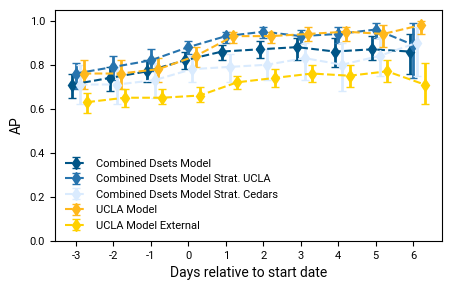

In [21]:
slides = [-3,-2,-1,0,1,2,3,4,5,6]
metric_names = ['ap']
plt_labels = ['Combined Dsets Model','Combined Dsets Model Strat. UCLA','Combined Dsets Model Strat. Cedars', 'UCLA Model', "UCLA Model External"]
colors = ['#005587','#2774AE', '#DAEBFE', '#FFB81C', '#FFD100']
runs = [all_preselectall, ucla_train, ucla_train]
filters = ['', '', 'cedars_crrt']

plot_rolling(metric_names,
                runs, filters, plt_labels,
                slides, 
                [""],subgroup_labels = ["all"],
                colors=colors,
                tag='tune5',
                strat=True)

# plt_labels = ['Combined Dsets Model']
# runs = [all_preselectall]
# filters = ['']

# plot_rolling(metric_names,
#                 runs, filters, plt_labels,
#                 slides, 
#                 [""],subgroup_labels = ["all"],
#                 tag='tune50',
#                 strat=False)

{-3: {'ucla_to_ucla_tune50_v3 ': '0.76 (0.69-0.82)', 'ucla_to_ucla_tune50_v3 cedars_crrt': '0.63 (0.58-0.67)', 'ucla_to_ucla_tune50_v3 ucla_control': '0.08 (0.07-0.11)', 'cedars_to_cedars_tune50_v3 ': '0.73 (0.65-0.81)', 'cedars_to_cedars_tune50_v3 ucla_crrt': '0.64 (0.60-0.67)', 'cedars_to_cedars_tune50_v3 ucla_control': '0.24 (0.22-0.26)', 'uclapluscedars_to_uclapluscedars_tune50_v3 ': '0.74 (0.68-0.79)', 'uclapluscedars_to_uclapluscedars_tune50_v3 ucla_crrt': '0.77 (0.71-0.83)', 'uclapluscedars_to_uclapluscedars_tune50_v3 cedars_crrt': '0.68 (0.58-0.77)', 'uclapluscedars_to_uclapluscedars_tune50_v3 ucla_control': '0.12 (0.10-0.13)', 'all_to_all_tune50_v3 ': '0.72 (0.66-0.77)', 'all_to_all_tune50_v3 ucla_crrt': '0.70 (0.62-0.77)', 'all_to_all_tune50_v3 cedars_crrt': '0.77 (0.69-0.85)', 'ucla_to_ucla_preselectall_tune50_v3 ': '0.74 (0.67-0.80)', 'ucla_to_ucla_preselectall_tune50_v3 cedars_crrt': '0.63 (0.59-0.67)', 'ucla_to_ucla_preselectall_tune50_v3 ucla_control': '0.08 (0.06-0.10)'

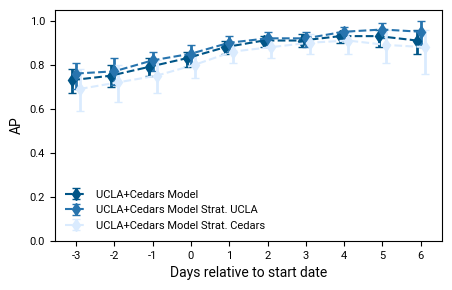

{-3: {'ucla_to_ucla_tune50_v3 ': '0.76 (0.69-0.82)', 'ucla_to_ucla_tune50_v3 cedars_crrt': '0.63 (0.58-0.67)', 'ucla_to_ucla_tune50_v3 ucla_control': '0.08 (0.07-0.11)', 'cedars_to_cedars_tune50_v3 ': '0.73 (0.65-0.81)', 'cedars_to_cedars_tune50_v3 ucla_crrt': '0.64 (0.60-0.67)', 'cedars_to_cedars_tune50_v3 ucla_control': '0.24 (0.22-0.26)', 'uclapluscedars_to_uclapluscedars_tune50_v3 ': '0.74 (0.68-0.79)', 'uclapluscedars_to_uclapluscedars_tune50_v3 ucla_crrt': '0.77 (0.71-0.83)', 'uclapluscedars_to_uclapluscedars_tune50_v3 cedars_crrt': '0.68 (0.58-0.77)', 'uclapluscedars_to_uclapluscedars_tune50_v3 ucla_control': '0.12 (0.10-0.13)', 'all_to_all_tune50_v3 ': '0.72 (0.66-0.77)', 'all_to_all_tune50_v3 ucla_crrt': '0.70 (0.62-0.77)', 'all_to_all_tune50_v3 cedars_crrt': '0.77 (0.69-0.85)', 'ucla_to_ucla_preselectall_tune50_v3 ': '0.74 (0.67-0.80)', 'ucla_to_ucla_preselectall_tune50_v3 cedars_crrt': '0.63 (0.59-0.67)', 'ucla_to_ucla_preselectall_tune50_v3 ucla_control': '0.08 (0.06-0.10)'

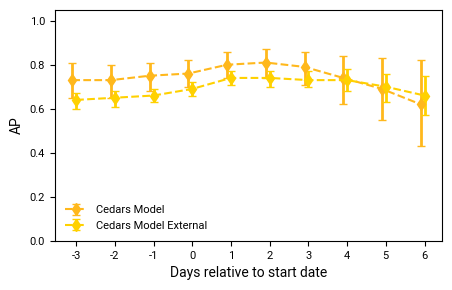

In [24]:
slides = [-3,-2,-1,0,1,2,3,4,5,6]
metric_names = ['ap']
plt_labels = ['UCLA+Cedars Model','UCLA+Cedars Model Strat. UCLA','UCLA+Cedars Model Strat. Cedars', 'UCLA Model', "UCLA Model External"]
colors = ['#005587','#2774AE', '#DAEBFE', '#FFB81C', '#FFD100']
runs = [uclapluscedars_preselectcrrt]
filters = ['']

plot_rolling(metric_names,
                runs, filters, plt_labels,
                slides, 
                [""],subgroup_labels = ["all"],
                colors=colors,
                tag='tune5',
                strat=True)

slides = [-3,-2,-1,0,1,2,3,4,5,6]
metric_names = ['ap']
plt_labels = ['Cedars Model', "Cedars Model External"]
colors = [ '#FFB81C', '#FFD100']
runs = [cedars_train, cedars_train]
filters = ['','ucla_crrt']

plot_rolling(metric_names,
                runs, filters, plt_labels,
                slides, 
                [""],subgroup_labels = ["all"],
                colors=colors,
                tag='tune5',
                strat=True)



# Clinical impact

In [14]:
from sklearn.metrics import auc, det_curve, confusion_matrix

def get_cost(prob_df, threshold, price=True):
    
    prices = [543, 3486*0.76/7, 5177*0.76/7, 276.70*1.11, 2607*0.76/7,3089*0.76/7,436*1.11, 3629.80, 1100*0.76, 3700*0.76]
    
    # GET FN AND TN patients 
    # labels = prob_df['recommend_crrt']
    # pred_probas = prob_df[0].values
    
    prob_df['pred'] = (prob_df[0] >= threshold).astype(int)
    prob_df['N'] = (prob_df['pred']==0).astype(int)
    
    # GET CRRT_TOTAL_DAYS for the selected patients
    days = pd.merge(prob_df, pd.concat([OUTCOMES_UCLA, OUTCOMES_CEDARS]), how='left', on=['IP_PATIENT_ID','Start Date'])
    days = days[days['N']==1]
    
    # sum total days
    total_days_saved = days['CRRT Total Days'].sum()
    
    # multuply by cost
    if price:
        return total_days_saved*np.mean(prices)
    else:
        return total_days_saved

                    
def create_matrix(metric_names, metric_fns, prob_df, labels, pred_probas,grouping_labels, price):
    conf_matrix_values = {metric: [] for metric in metric_names}
    savings = [np.nan]
    
    # Current clinical practice
    for metric_name, metric_fn in zip(metric_names,metric_fns):
        conf_matrix_values[metric_name].append(metric_fn(labels, labels, 0.5))
    conf_matrix_values['FP'] = conf_matrix_values['TN']
    conf_matrix_values['TN'] = [0]
    
    # Search for good threshold (FN=0 or FN=2)
    fpr, fnr, thresholds = det_curve(labels, pred_probas)
    use_thresh = []
    
    # FNs = [0,2]
    # curr = 0
    # for threshold in sorted(thresholds):
    #     if confusion_matrix(labels, (pred_probas >= threshold).astype(int))[1, 0] >= FNs[curr]:
    #         use_thresh.append(threshold)
    #         curr+=1
        
    #     # if confusion_matrix(labels, (pred_probas >= threshold).astype(int))[1, 0] > FNs[curr] and len(use_thresh) < 2:
    #     #     use_thresh.append(threshold)
            
    #     if len(use_thresh) == 2:
    #         break
        
    use_thresh = [0,0.25,0.5,0.75,1.0]
    grouping_labels = grouping_labels + [str(thresh) for thresh in use_thresh]
    
    for k in range(len(use_thresh)):
        for metric_name, metric_fn in zip(metric_names,metric_fns):
            conf_matrix_values[metric_name].append(metric_fn(labels, pred_probas, use_thresh[k]))
        savings.append(get_cost(prob_df, use_thresh[k], price))

    # Decision threshold = 0.5
    # for metric_name, metric_fn in zip(metric_names,metric_fns):
    #     conf_matrix_values[metric_name].append(metric_fn(labels, pred_probas, 0.5))
    # savings.append(get_cost(prob_df, 0.5, price))
    
    return conf_matrix_values,savings,grouping_labels

def plot_clinical_impact(grouping_labels,
                         conf_matrix_values, savings,
                         plt_label, 
                         subgroup_label, 
                         colors,conf_matrix_label,conf_matrix_baseline_label,
                         price=True):
    fig, ax = plt.subplots()
    bottom = np.zeros(len(grouping_labels)-1)
    bottom_baseline = 0

    for k, metric_name in enumerate(metric_names):
        data = conf_matrix_values[metric_name]
        if data[0] > 0:
            p = ax.bar(grouping_labels[0], data[0], 0.75, label=conf_matrix_baseline_label[k], bottom=bottom_baseline, edgecolor='black',linestyle='--',color=colors[k], alpha=0.5)
            bottom_baseline += data[0]
            labels = [int(v) if v > 2 else "" for v in p.datavalues]    
            ax.bar_label(p, labels=labels, label_type="center")

    for k, metric_name in enumerate(metric_names):
        
        p = ax.bar(grouping_labels[1:], conf_matrix_values[metric_name][1:], 0.75, label=conf_matrix_label[k], bottom=bottom, color=colors[k])
        bottom += conf_matrix_values[metric_name][1:]

        labels = [int(v) if v > 2 else "" for v in p.datavalues]    
        ax.bar_label(p, labels=labels, label_type="center")
    ax.set_xlabel('Clinical ML decision threshold')
    ax.xaxis.set_label_coords(0.6, -0.15)
    ax.set_ylim([0,bottom_baseline+0.05*bottom_baseline])

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    if price:
        ax2.set_ylabel('Total cost savings ($)', color='#FF00A5')  # we already handled the x-label with ax1
    else:
        ax2.set_ylabel('Total CRRT days saved', color='#FF00A5')  # we already handled the x-label with ax1
    print(savings)

    ax2.errorbar(grouping_labels, savings, color='#FF00A5')
    ax2.set_ylim([0, np.nanmax(savings)+0.1*np.nanmax(savings)])
    ax2.tick_params(axis='y', labelcolor='#FF00A5')

    # ax.set_title(f"Clinical impact_{subgroup_labels[i]}_{plt_labels[j]}")
    print(f"Clinical impact_{subgroup_label}_{plt_label}")
    ax.legend(loc='upper left', bbox_to_anchor=(0.05, -0.25),
    fancybox=False, shadow=False, ncol=1, frameon=False)

    ax.set_ylabel("Patient counts")
    fig = plt.gcf()
    fig.set_size_inches(5,3)
    plt.savefig(f'./posthoc/Clinical impact_{subgroup_label}_{plt_label}.svg', format='svg',  bbox_inches="tight")
    plt.show()
    plt.close()
    
def process_and_plot_clinical_impact(metric_names, metric_fns, 
                         runs, filters, eval_cohorts, plt_labels, 
                         subgroups, subgroup_labels, 
                         colors,conf_matrix_label,conf_matrix_baseline_label,
                         price=True, strat=False):

    for subgroup, subgroup_label in zip(subgroups, subgroup_labels):
        print(subgroup)

        for run_name, filter, eval_cohort, plt_label in zip(runs,filters,eval_cohorts,plt_labels):
            
            if len(filter) > 0:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
            else:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")

            prefix = f"{run.data.tags['modeln']}_test{subgroup}"
            
            prob_df, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix, filter=eval_cohort)
            prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(list(UCLA_IDS)+list(CEDARS_IDS))].copy()
            labels = prob_df['recommend_crrt']
            pred_probas = prob_df[0].values
                
            grouping_labels = ['Current\nStandard']
            
            conf_matrix_values,savings,grouping_labels = create_matrix(metric_names, metric_fns, prob_df, labels, pred_probas,grouping_labels, price)
            print(grouping_labels)
            plot_clinical_impact(grouping_labels, conf_matrix_values,savings,
                                 plt_label, 
                                subgroup_label, 
                                colors,conf_matrix_label,conf_matrix_baseline_label,
                                price=price)
        
            if ('plus' in run_name or 'all_to_all' in run_name) and strat:
                
                ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)].copy()
                labels = ucla_prob_df['recommend_crrt']
                pred_probas = ucla_prob_df[0].values
                
                conf_matrix_values,savings = create_matrix(metric_names, metric_fns, ucla_prob_df, labels, pred_probas,grouping_labels, price)
            
                plot_clinical_impact(grouping_labels, conf_matrix_values,savings,
                                    plt_label + ' Strat. UCLA', 
                                    subgroup_label, 
                                    colors,conf_matrix_label,conf_matrix_baseline_label,
                                    price=price)
                         
                cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)].copy()
                labels = cedars_prob_df['recommend_crrt']
                pred_probas = cedars_prob_df[0].values
                
                conf_matrix_values,savings = create_matrix(metric_names, metric_fns, cedars_prob_df, labels, pred_probas,grouping_labels, price)
            
                plot_clinical_impact(grouping_labels, conf_matrix_values,savings,
                                    plt_label+ ' Strat. Cedars', 
                                    subgroup_label, 
                                    colors,conf_matrix_label,conf_matrix_baseline_label,
                                    price=price)

mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


['Current\nStandard', '0', '0.25', '0.5', '0.75', '1.0']
[nan, 0, 12596, 17341, 22930, 50900]
Clinical impact_all_Combined Dsets Model


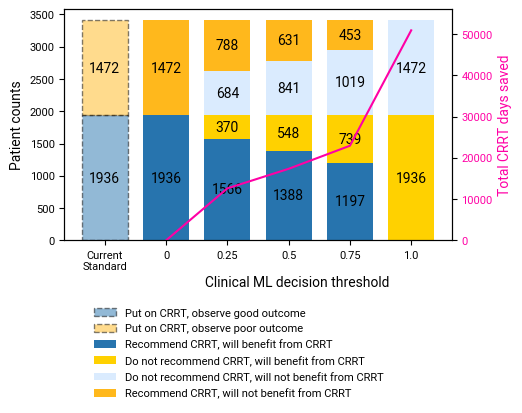

In [15]:
from models.static_models import METRIC_MAP

metric_names = ["TP", "FN", "TN","FP"]
metric_fns = [METRIC_MAP[metric] for metric in metric_names]

plt_labels = ['Combined Dsets Model']#, 'UCLA Model', "UCLA Model External"]
runs = [all_preselectall]#, ucla_train, ucla_train]
filters = ['']#, '', 'cedars_crrt']
eval_cohorts = ['ucla_crrt+cedars_crrt']#, None, None]

subgroups = [""]#, "_heart", "_liver", "_infection"]
subgroup_labels = ["all"]#, "heart", "liver", "infection"]

colors = ['#2774AE','#FFD100','#DAEBFE','#FFB81C']
conf_matrix_label = ['Recommend CRRT, will benefit from CRRT','Do not recommend CRRT, will benefit from CRRT','Do not recommend CRRT, will not benefit from CRRT','Recommend CRRT, will not benefit from CRRT']
conf_matrix_baseline_label = ['Put on CRRT, observe good outcome','','','Put on CRRT, observe poor outcome']

process_and_plot_clinical_impact(metric_names, metric_fns,
                     runs, filters, eval_cohorts, plt_labels,
                     subgroups, subgroup_labels,
                     colors, conf_matrix_label, conf_matrix_baseline_label,
                     strat=False,
                     price=False)

mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


['Current\nStandard', '0', '0.25', '0.5', '0.75', '1.0']
[nan, 0, 4935, 10688, 16280, 32015]
Clinical impact_all_UCLA Model


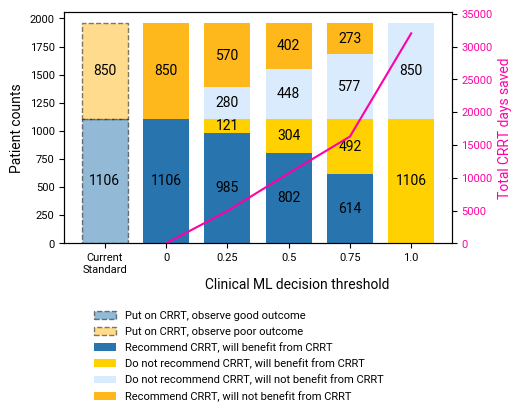

mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


['Current\nStandard', '0', '0.25', '0.5', '0.75', '1.0']
[nan, 0, 918, 5066, 14139, 23778]
Clinical impact_all_UCLA Model External


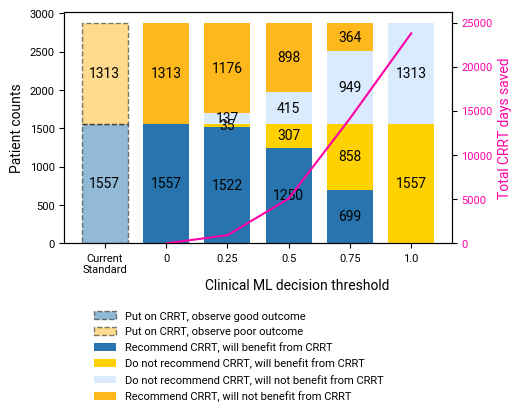

['Current\nStandard', '0', '0.25', '0.5', '0.75', '1.0']


mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[nan, 0, 5522, 7800, 10091, 18605]
Clinical impact_all_Cedars Model


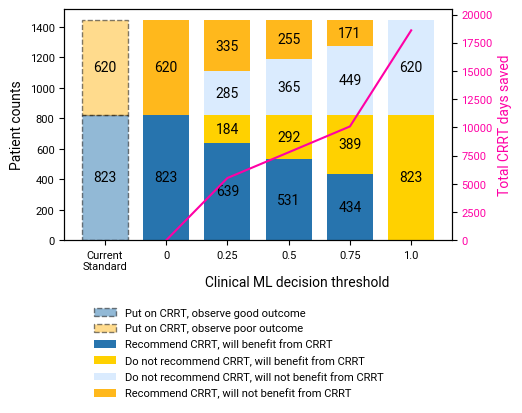

mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


['Current\nStandard', '0', '0.25', '0.5', '0.75', '1.0']
[nan, 0, 9237, 13846, 18614, 37949]
Clinical impact_all_Cedars Model External


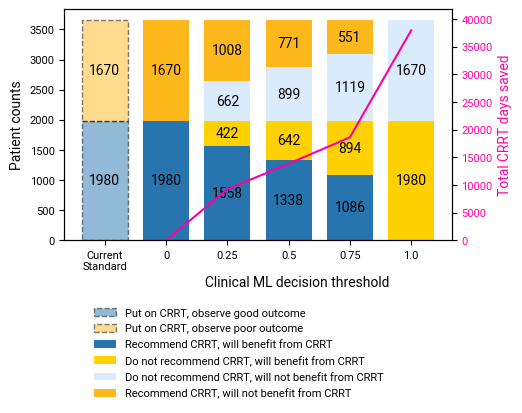

mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


['Current\nStandard', '0', '0.25', '0.5', '0.75', '1.0']
[nan, 0, 8741, 16088, 25781, 51056]
Clinical impact_all_UCLA+Cedars Model


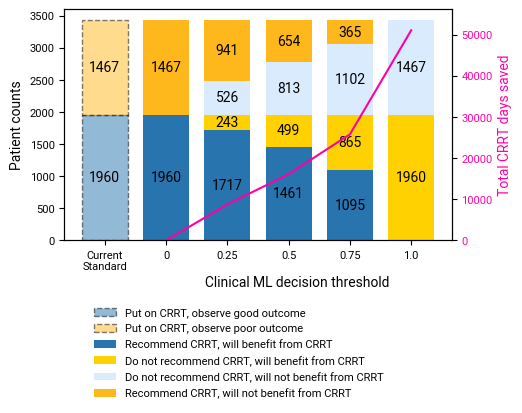

In [16]:
plt_labels = ['UCLA Model', "UCLA Model External", 'Cedars Model', "Cedars Model External",'UCLA+Cedars Model']
runs = [ucla_train, ucla_train, cedars_train, cedars_train, uclapluscedars_preselectcrrt]
filters = ['', 'cedars_crrt', '', 'ucla_crrt' , '']
eval_cohorts = ['ucla_crrt', 'cedars_crrt','cedars_crrt','ucla_crrt','ucla_crrt+cedars_crrt']
process_and_plot_clinical_impact(metric_names, metric_fns,
                     runs, filters, eval_cohorts, plt_labels,
                     subgroups, subgroup_labels,
                     colors, conf_matrix_label, conf_matrix_baseline_label,
                     strat=False,
                     price=False)

In [77]:
from sklearn.metrics import auc, det_curve, confusion_matrix

def get_cost(prob_df, threshold, price=True):
    
    prices = [543, 3486*0.76/7, 5177*0.76/7, 276.70*1.11, 2607*0.76/7,3089*0.76/7,436*1.11, 3629.80, 1100*0.76, 3700*0.76]
    
    # GET FN AND TN patients 
    # labels = prob_df['recommend_crrt']
    # pred_probas = prob_df[0].values
    
    prob_df['pred'] = (prob_df[0] >= threshold).astype(int)
    prob_df['N'] = (prob_df['pred']==0).astype(int)
    
    # GET CRRT_TOTAL_DAYS for the selected patients
    days = pd.merge(prob_df, pd.concat([OUTCOMES_UCLA, OUTCOMES_CEDARS]), how='left', on=['IP_PATIENT_ID','Start Date'])
    days = days[days['N']==1]
    
    # sum total days
    total_days_saved = days['CRRT Total Days'].sum()
    
    # multuply by cost
    if price:
        return total_days_saved*np.mean(prices)
    else:
        return total_days_saved

def create_matrix(metric_names, metric_fns, prob_df, labels, pred_probas,grouping_labels, price):
    conf_matrix_values = {metric: [] for metric in metric_names}
    savings = [np.nan]
    
    # Current clinical practice
    for metric_name, metric_fn in zip(metric_names,metric_fns):
        conf_matrix_values[metric_name].append(metric_fn(labels, labels, 0.5))
    conf_matrix_values['FP'] = conf_matrix_values['TN']
    conf_matrix_values['TN'] = [0]
    
    # Search for good threshold (FN=0 or FN=2)
    fpr, fnr, thresholds = det_curve(labels, pred_probas)
    use_thresh = sorted(thresholds)
    grouping_labels = grouping_labels + [str(thresh) for thresh in use_thresh]
        
    for k in range(len(use_thresh)):
        for metric_name, metric_fn in zip(metric_names,metric_fns):
            conf_matrix_values[metric_name].append(metric_fn(labels, pred_probas, use_thresh[k]))
        savings.append(get_cost(prob_df, use_thresh[k], price))

    # Decision threshold = 0.5
    # for metric_name, metric_fn in zip(metric_names,metric_fns):
    #     conf_matrix_values[metric_name].append(metric_fn(labels, pred_probas, 0.5))
    # savings.append(get_cost(prob_df, 0.5, price))
    
    return conf_matrix_values,savings,grouping_labels

def plot_clinical_impact(grouping_labels,
                         conf_matrix_values, savings,
                         plt_label, 
                         subgroup_label, 
                         colors,conf_matrix_label,conf_matrix_baseline_label,
                         price=True):
    fig, ax = plt.subplots()
    bottom_baseline = 0

    for k, metric_name in enumerate(metric_names):
        data = conf_matrix_values[metric_name]
        if data[0] > 0:
            p = ax.bar(-0.105, data[0], 0.2, label=conf_matrix_baseline_label[k], 
                       bottom=bottom_baseline, edgecolor='black',linestyle='--',
                       color=colors[k], alpha=0.5)
            bottom_baseline += data[0]
            labels = [int(v) if v > 2 else "" for v in p.datavalues]    
            ax.bar_label(p, labels=labels, label_type="center")

    # for k, metric_name in enumerate(metric_names):
    x = [float(thresh) for thresh in grouping_labels[1:]]
    p = ax.stackplot(x, conf_matrix_values[metric_names[0]][1:],
               conf_matrix_values[metric_names[1]][1:],
               conf_matrix_values[metric_names[2]][1:],
               conf_matrix_values[metric_names[3]][1:], 
               labels=conf_matrix_label,colors=colors)
        # bottom += conf_matrix_values[metric_name][1:]

        # labels = [int(v) if v > 2 else "" for v in p.datavalues]    
        # ax.bar_label(p, labels=labels, label_type="center")
    ax.set_xticks([-0.105] + list(np.linspace(0,1,6)))
    labels = ax.set_xticklabels([grouping_labels[0]] + ['0.0','0.2','0.4','0.6','0.8','1.0'])
    labels[0].set_ha('right')
    ax.set_xlabel('Decision threshold')

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    if price:
        ax2.set_ylabel('Total cost savings ($)', color='#FF00A5')  # we already handled the x-label with ax1
    else:
        ax2.set_ylabel('Total CRRT days saved', color='#FF00A5')  # we already handled the x-label with ax1
    print(savings)

    ax2.errorbar(x, savings[1:], color='#FF00A5')
    ax2.set_ylim([0, np.nanmax(savings)+0.1*np.nanmax(savings)])
    ax2.tick_params(axis='y', labelcolor='#FF00A5')

    # ax.set_title(f"Clinical impact_{subgroup_labels[i]}_{plt_labels[j]}")
    print(f"Clinical impact_{subgroup_label}_{plt_label}")
    ax.legend(loc='upper left', bbox_to_anchor=(0.05, -0.25),
    fancybox=False, shadow=False, ncol=1)

    ax.set_ylabel("Patient counts")
    fig = plt.gcf()
    fig.set_size_inches(5,3)
    plt.savefig(f'./posthoc/Clinical impact_{subgroup_label}_{plt_label}v2.svg', format='svg',  bbox_inches="tight")
    plt.show()
    plt.close()
    
def process_and_plot_clinical_impact_v2(metric_names, metric_fns, 
                         runs, filters, eval_cohorts, plt_labels, 
                         subgroups, subgroup_labels, 
                         colors,conf_matrix_label,conf_matrix_baseline_label,
                         price=True, strat=False):

    for subgroup, subgroup_label in zip(subgroups, subgroup_labels):
        print(subgroup)

        for run_name, filter, eval_cohort, plt_label in zip(runs,filters,eval_cohorts,plt_labels):
            
            if len(filter) > 0:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
            else:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")

            prefix = f"{run.data.tags['modeln']}_test{subgroup}"
            
            prob_df, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix, filter=eval_cohort)
            # prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(list(UCLA_IDS)+list(CEDARS_IDS))].copy()
            labels = prob_df['recommend_crrt']
            pred_probas = prob_df[0].values
                
            grouping_labels = ['Current\nStandard']
            
            conf_matrix_values,savings,grouping_labels = create_matrix(metric_names, metric_fns, prob_df, labels, pred_probas,grouping_labels, price)
            
            plot_clinical_impact(grouping_labels, conf_matrix_values,savings,
                                 plt_label, 
                                subgroup_label, 
                                colors,conf_matrix_label,conf_matrix_baseline_label,
                                price=price)
        
            if ('plus' in run_name or 'all_to_all' in run_name) and strat:
                
                ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)].copy()
                labels = ucla_prob_df['recommend_crrt']
                pred_probas = ucla_prob_df[0].values
                
                conf_matrix_values,savings = create_matrix(metric_names, metric_fns, ucla_prob_df, labels, pred_probas,grouping_labels, price)
            
                plot_clinical_impact(grouping_labels, conf_matrix_values,savings,
                                    plt_label + ' Strat. UCLA', 
                                    subgroup_label, 
                                    colors,conf_matrix_label,conf_matrix_baseline_label,
                                    price=price)
                         
                cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)].copy()
                labels = cedars_prob_df['recommend_crrt']
                pred_probas = cedars_prob_df[0].values
                
                conf_matrix_values,savings = create_matrix(metric_names, metric_fns, cedars_prob_df, labels, pred_probas,grouping_labels, price)
            
                plot_clinical_impact(grouping_labels, conf_matrix_values,savings,
                                    plt_label+ ' Strat. Cedars', 
                                    subgroup_label, 
                                    colors,conf_matrix_label,conf_matrix_baseline_label,
                                    price=price)


[nan, 15.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 45.0, 45.0, 45.0, 45.0, 49.0, 49.0, 49.0, 52.0, 52.0, 58.0, 58.0, 58.0, 58.0, 59.0, 59.0, 59.0, 59.0, 59.0, 62.0, 63.0, 63.0, 63.0, 63.0, 63.0, 63.0, 63.0, 63.0, 70.0, 71.0, 71.0, 74.0, 74.0, 74.0, 76.0, 76.0, 76.0, 76.0, 76.0, 76.0, 76.0, 76.0, 78.0, 78.0, 78.0, 81.0, 81.0, 81.0, 81.

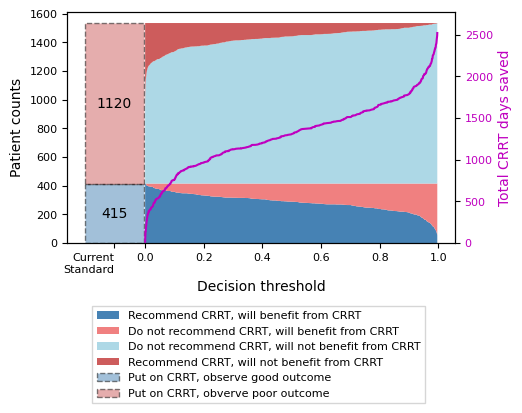


[nan, 0.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 

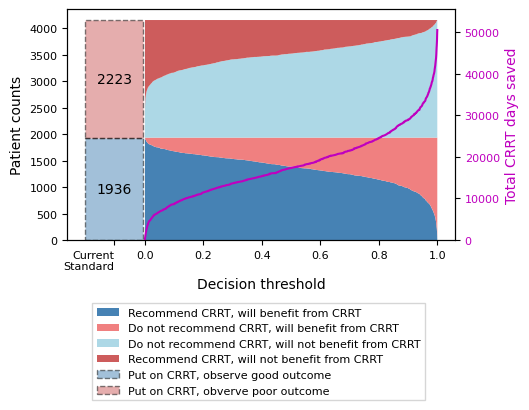

In [78]:
from models.static_models import METRIC_MAP

metric_names = ["TP", "FN", "TN","FP"]
metric_fns = [METRIC_MAP[metric] for metric in metric_names]

plt_labels = ['Combined Dsets Model']#, 'UCLA Model', "UCLA Model External"]
runs = [all_preselectall]#, ucla_train, ucla_train]
filters = ['']#, '', 'cedars_crrt']
eval_cohorts = ['ucla_crrt+cedars_crrt']#, None, None]

subgroups = [""]#, "_heart", "_liver", "_infection"]
subgroup_labels = ["all"]#, "heart", "liver", "infection"]

colors = ['steelblue','lightcoral','lightblue','indianred']
conf_matrix_label = ['Recommend CRRT, will benefit from CRRT','Do not recommend CRRT, will benefit from CRRT','Do not recommend CRRT, will not benefit from CRRT','Recommend CRRT, will not benefit from CRRT']
conf_matrix_baseline_label = ['Put on CRRT, observe good outcome','','','Put on CRRT, obverve poor outcome']

process_and_plot_clinical_impact_v2(metric_names, metric_fns,
                     runs, filters, eval_cohorts, plt_labels,
                     subgroups, subgroup_labels,
                     colors, conf_matrix_label, conf_matrix_baseline_label,
                     strat=False,
                     price=False)

# Bias Analysis

In [12]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

color1 = "#005587"
color2 = "#DAEBFE"


In [144]:
import seaborn as sns
from collections import defaultdict

def bias_analysis(runs, filters,eval_cohorts,
                    subgroup_labels,subgroup_categories):
    
    metric_names = ['TP','TN','FP','FN', 'recall', 'specificity']
    for run, filter, eval_cohort in zip(runs, filters,eval_cohorts):

        metric_table = defaultdict(list)
        ci_low_table = defaultdict(list)
        ci_high_table = defaultdict(list)

        for metric_name in metric_names:
            
            # _ucla_crrt+cedars_crrt
            with open(f'./posthoc/{run}_{filter}_{eval_cohort}_subgroups.pkl', 'rb') as f:
                table = pickle.load(f)
            
            for subgroup_label in subgroup_labels:
                # if float(table['counts'][subgroup_label].split(' (')[0]) < 5:
                #     continue
                
                metric_table[metric_name].append(float(table[metric_name][subgroup_label].split(' (')[0]))
                ci_low_table[metric_name].append(float(table[metric_name][subgroup_label].split(' (')[0]) - float(table[metric_name][subgroup_label].split(' (')[-1].split('-')[0]))
                ci_high_table[metric_name].append(float(table[metric_name][subgroup_label].split('-')[-1].split(')')[0]) - float(table[metric_name][subgroup_label].split(' (')[0]))
                
                # if ('plus' in run or 'all_to_all' in run) and 'controls' not in filter:
                #     metric_table[metric_name][f'{subgroup_label} ucla_crrt'] = table[metric_name][f'{subgroup_label} ucla_crrt']
                #     ci_low_table[metric_name][f'{subgroup_label} ucla_crrt'] = float(table[metric_name][f'{subgroup_label} ucla_crrt'].split(' (')[-1].split('-')[0])
                #     ci_high_table[metric_name][f'{subgroup_label} ucla_crrt'] = float(table[metric_name][f'{subgroup_label} ucla_crrt'].split('-')[-1].split(')')[0])
                
                #     metric_table[metric_name][f'{subgroup_label} cedars_crrt'] = table[metric_name][f'{subgroup_label} cedars_crrt']
                #     ci_low_table[metric_name][f'{subgroup_label} cedars_crrt'] = float(table[metric_name][f'{subgroup_label} cedars_crrt'].split(' (')[-1].split('-')[0])
                #     ci_high_table[metric_name][f'{subgroup_label} cedars_crrt'] = float(table[metric_name][f'{subgroup_label} cedars_crrt'].split('-')[-1].split(')')[0])
        
        metric_table = pd.DataFrame(metric_table)       
        metric_table['FPR'] = 1 - metric_table['specificity']
        ci_low_table['FPR'] = ci_low_table['specificity']
        ci_high_table['FPR'] = ci_high_table['specificity']
        metric_table['FNR'] = 1 - metric_table['recall']
        ci_low_table['FNR'] = ci_low_table['recall']
        ci_high_table['FNR'] = ci_high_table['recall']
        
        for i in range(len(metric_table)):
            plt.figure(figsize=(2,2))
            # plt.subplot(1,len(metric_table),i+1)
            sns.heatmap([[int(np.nan_to_num(metric_table['TP'][i])),int(np.nan_to_num(metric_table['FP'][i]))],
                         [int(np.nan_to_num(metric_table['FN'][i])),int(np.nan_to_num(metric_table['TN'][i]))]], 
                                annot=True,  fmt="d",
                                xticklabels=['Positive', 'Negative'],
                                yticklabels=['Positive', 'Negative'],cmap=get_color_gradient(color2, color1, 255))
            plt.ylabel('Prediction')
            plt.xlabel('Actual')
            plt.title(subgroup_labels[i].capitalize())
            name = f"{run}{filter}_{subgroup_labels[i]}_confmatrix"
            plt.savefig(f'./posthoc/{name}.svg', format='svg',  bbox_inches="tight")
            plt.show()
            plt.close()
        
        x = []
        category_x = []
        category_labels = []
        prev_category = None
        current_category = None
        index = len(subgroup_labels) + len(np.unique(subgroup_categories)) - 1
        for i in range(len(subgroup_labels)):
            current_category = subgroup_categories[i]
            if current_category != prev_category:
                category_x.append(index)
                category_labels.append(current_category)
                index -= 1
                prev_category = current_category
            x.append(index)
            index -= 1
        x = np.array(x)
        
        subgroup_labels_with_counts = []
        for subgroup_label in subgroup_labels:
            lab_ = subgroup_label.replace('\ninfection','infection')
            subgroup_labels_with_counts.append(f"{lab_}\n N={table['counts'][subgroup_label]}")
            
        fig, ax = plt.subplots()
        x_pos = np.arange(len(metric_table))
        ax.barh(x, metric_table['FPR'], height=0.3, xerr=[ci_high_table['FPR'], ci_low_table['FPR']],label='FPR', capsize=2,color='#2774AE')
        # ax.plot([metric_table['FPR'][0], metric_table['FPR'][0]], [0., x[0]], "k--", linewidth=1, alpha=0.5)
        
        ax.barh(x+0.3, metric_table['FNR'], height=0.3, xerr=[ci_high_table['FNR'], ci_low_table['FNR']], label='FNR',capsize=2,color='#FFD100')
        # ax.plot([metric_table['FNR'][0], metric_table['FNR'][0]], [0., x[0]], "k--", linewidth=1, alpha=0.5)
        
        # ax.set_xticks(x_pos+0.125)
        ax.set_yticks(category_x, category_labels, minor=False, fontweight='bold')
        ax.set_yticks(x + 0.15, subgroup_labels_with_counts, minor=True)
        ax.tick_params(axis='y', which='major', length=0)
        # ax.set_xticklabels([label.capitalize() for label in subgroup_labels], rotation=45, ha='right')
        plt.legend(loc="upper left", bbox_to_anchor=(0.0, 0.03),ncol=len(metric_table.keys()),
            frameon=False,columnspacing=0.5,handlelength=1,handletextpad=0.25)
        # plt.ylim([-0.5,10.25])
        plt.xlabel('Value')
        fig.set_size_inches(3,10)
        name = f"{run}{filter}_bias"
        plt.savefig(f'./posthoc/{name}.svg', format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()

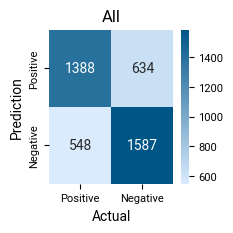

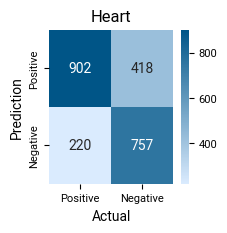

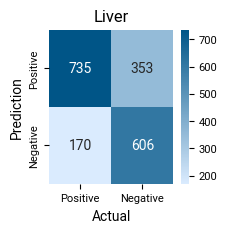

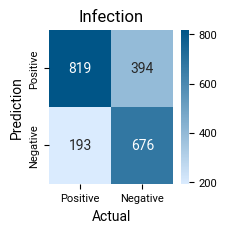

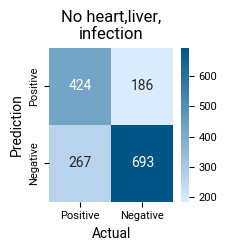

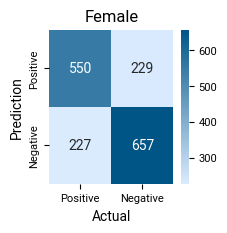

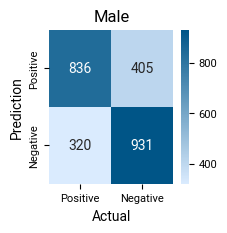

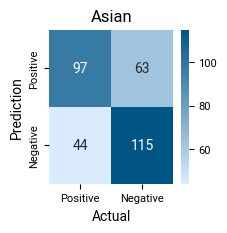

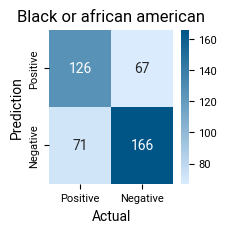

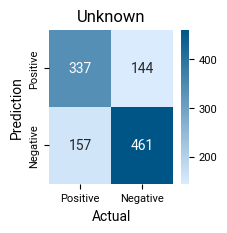

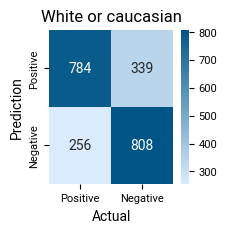

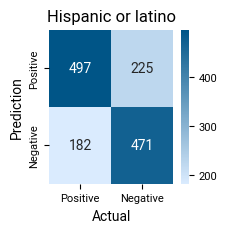

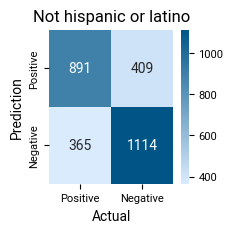

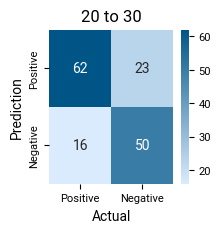

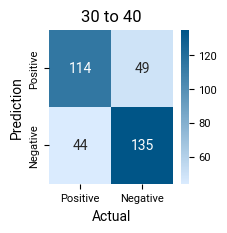

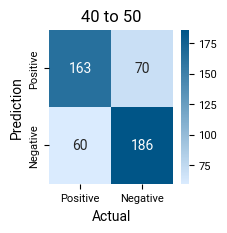

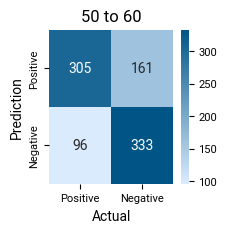

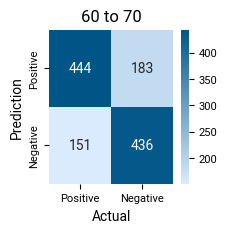

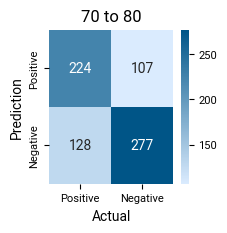

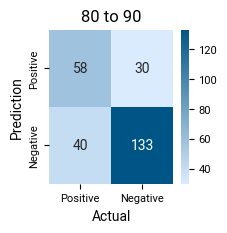

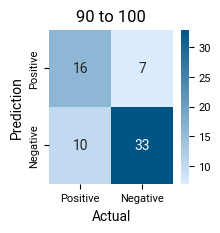

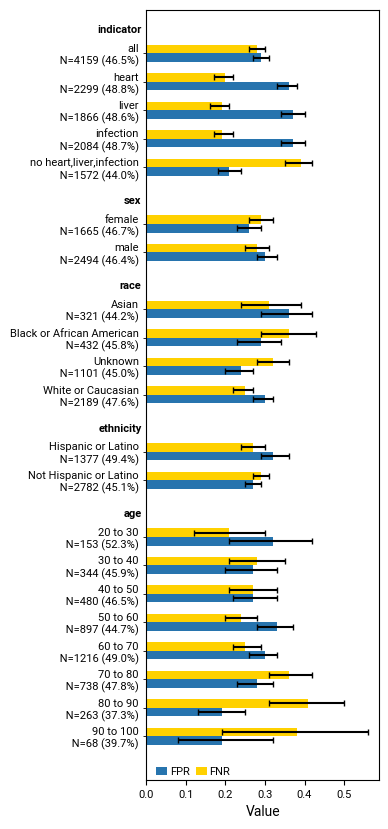

In [145]:
# bias_analysis([ucla_train], [''],
#                 ['American Indian\no
# r Alaska Native','Asian','Black or African American','Native Hawaiian or\nOther Pacific Islander','Multiple Races','Unknown','White or Caucasian',
#               'Hispanic or Latino','Not Hispanic or Latino',])

subgroup_labels = [
              "all", "heart", "liver", "infection","no heart,liver,\ninfection",
              'female','male', 
        #       'American Indian\nor Alaska Native','Native Hawaiian or\nOther Pacific Islander','Multiple Races',
              'Asian','Black or African American','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino',
              '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100'
              ]
subgroup_categories = [
              "indicator", "indicator", "indicator", "indicator","indicator",
              'sex','sex', 
        #       'race','race','race',
              'race','race','race','race',
              'ethnicity','ethnicity',
              'age','age','age','age','age','age','age','age'
              ]

bias_analysis([all_preselectall], [''], ['ucla_crrt+cedars_crrt'],
                subgroup_labels,
                subgroup_categories)

In [ ]:
report_as_is(['counts','TP','TN','FP','FN','recall','specificity'],
                [all_preselectall], [''],
                ['American Indian\nor Alaska Native','Asian','Black or African American','Native Hawaiian or\nOther Pacific Islander','Multiple Races','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino','male','female'],
                eval_cohorts=['ucla_crrt+cedars_crrt'])

# Randomness

In [187]:
CONVERSION = {
    'MEAN CORPUSCULAR VOLUME': 'Mean corpuscular volume',
    'Num Prev CRRT Treatments': 'Number of previous CRRT treatments',
    'PHOSPHORUS': "Phosphorus",
    'PH, ARTERIAL': "Arterial pH",
    'CHOLESTEROL,LDL,CALCULATED': "LDL cholesterol",
    'CODE': 'code',
    'surgery_indicator': "Surgery before CRRT",
    'TOBRAMYCIN,PEAK': 'Peak tobramycin',
    'EOSINOPHIL,FLUID': 'eosinophil',
    'VANCOMYCIN,RANDOM': "Vancomycin random level",
    'PCO2, ARTERIAL': 'Arterial PCO2',
    'PCO2,VENOUS': 'Venous PCO2',
    'PHARM_SUBCLASS_ANTIPSYCHOTICS - MISC.': "Antipsychotics",
    'PH,VENOUS': "venous pH",
    'ADAMTS13 ACTIVITY': "ADAMTS13 activity",
    'TRIGLYCERIDES,FLUID': 'Triglycerides',
    'PHARM_SUBCLASS_CEPHALOSPORINS - 1ST GENERATION': "Cephalosporins - 1st generation",
    'MONOCYTE': 'Monocyte',
    'CHOLESTEROL,FLUID': 'Cholesterol',
    'CHOLESTEROL': 'Cholesterol',
    'OSMOLALITY,URINE': "Urine osmolality",
    'EOSINOPHIL': 'Eosinophil',
    'ETHNICITY': 'Ethnicity',
    'SEX': 'Sex',
    'AGE': 'Age',
    'TROPONIN I': "troponin I",
    'Unknown': "Unknown race",
    'liver_pt_indicator': "Liver comorbidities",
    'infection_pt_indicator': "Infection comorbidities",
    'heart_pt_indicator': "Heart comorbidities",
    'MEAN CORPUSCULAR HEMOGLOBIN': "Mean corpuscular hemoglobin",
    'PHARM_SUBCLASS_MAGNESIUM': "Magnesium",
    'PHARM_SUBCLASS_ANTIPARKINSON DOPAMINERGICS': "Antiparkinson dopaminergics",
    'BILIRUBIN,TOTAL': 'Bilirubin',
    'PHARM_SUBCLASS_CEPHALOSPORINS - 3RD GENERATION': "Cephalosporins - 3rd generation",
    'PHARM_SUBCLASS_BENZODIAZEPINE ANTAGONISTS': "Bensodiazepine antagonists",
    'PHARM_SUBCLASS_BENZISOXAZOLES': "Benzisoxazoles",
    'GENTAMICIN,RANDOM': 'Gentamicin random level',
    'VANCOMYCIN,TROUGH': 'vancomycin trough',
    'IONIZED CALCIUM(NON-PATIENT)': 'Ionized calcium',
    'IGG ALBUMIN SYN': "IGG albumin synthesis",
    'ABSOLUTE PLASMA CELL CT, MANUAL': "Plasma cell count",
    'N-ACETYLTYROSINE, URINE': 'Urine N-acetyl-tyrosine',
    'HISTOPLASMA ANTIGEN RESULT': 'histoplasma antigen',
    'ALDOSTERONE,SERUM': "Aldosterone",
    'PHENYLACETIC, URINE': "Urine phenylacetic",
    'IRON BINDING CAPACITY(QST)': "Iron binding capacity",
    'ABSOLUTE BASO COUNT': 'Basophil count',
    'URIC ACID(LDQ)': "Uric acid",
    '2-METHYL,3-HYDROXYBUTYRIC, URINE': 'Urine 2-methyl,3-hydroxybutyric',
    '3-HYDROXYBUTYRIC, URINE': 'Urine 3-hydroxybutyric',
    'VALPROIC ACID': "Valproic acid",
    '3-HYDROXYGLUTARIC, URINE': 'Urine 3-hydroxyglutaric',
    '3-HYDROXYISOBUTYRIC, URINE': 'Urine 3-hydroxyisobutyric',
    '3-METHYLGLUTACONIC, URINE': 'Urine 3-methylglutaconic',
    'OCTENEDIOIC, URINE': 'urine octenedioic',
    '4-HYDROXYBUTYRIC, URINE': 'Urine 4-hydroxybutyric',
    'AMIKACIN LEVEL': "amikacin level",
    'T3,TOTAL': 'Triiodothyronine',
    'POTASSIUM-MEQ/D URINE 24 HR': "Urine potassium",
    'CD8 ABS #': "CD8 count",
    'LEUKOCYTE ALKALINE PHOSPHATASE': "Leukocyte alkaline phosphatase",
    'PHARM_SUBCLASS_PHENOTHIAZINES': "Phenothiazines",
    'PHARM_SUBCLASS_PERIPHERAL OPIOID RECEPTOR ANTAGONISTS': "Peripheral opioid receptor antagonists",
    'ALDOLASE-ALDL': "Alsolase",
    'PHARM_SUBCLASS_PERITONEAL DIALYSIS SOLUTIONS': "Peritoneal dialysis solutions",
    'TOBRAMYCIN,RANDOM':"Tobramycin random level",
    'FERRITIN':"Ferritin",
    'TOTAL PROTEIN':'Total protein',
    'UREA NITROGEN, 24 HR UR': "Urea nitrogen",
    'CD3 ABSOLUTE': "CD3 count",
    'PROTEIN,CSF': "CSF protein",
    'GAMMA GLOBULINS':"Gamma globulins",
    'PO2, ARTERIAL': "Arterial PO2",
    'LYMPHOCYTE':"Lymphocyte",
    'HEMOGLOBIN, PLASMA': "Plasma hemoglobin",
    'PHARM_SUBCLASS_PHOSPHODIESTERASE 4 (PDE4) INHIBITORS': "Phosphodiesterase 4 inhibitors",
    'ALPHA-1-ANTITRYPSIN': 'Alpha-1-antitrypsin',
    'CK, TOTAL': "Creatine kinase",
    'CPT_SECTION': "CPT section"
}
def convert_str(x_axis):
        print(x_axis)
        for i in tqdm(range(len(x_axis))):
                curr_name = x_axis[i]
                if 'dx_' in curr_name:
                        curr_name = curr_name.replace('dx_','')
                if 'pr_' in curr_name:
                        curr_name = curr_name.replace('pr_','')
                if 'RACE_' in curr_name:
                        curr_name = curr_name.replace('RACE_','')
                                
                for key, val in CONVERSION.items():
                        if key in curr_name:
                                curr_name = curr_name.replace(key, val)
                        
                if '_std' in curr_name:
                        curr_name = curr_name.replace('_std',' (SD)')
                if '_min' in curr_name:
                        curr_name = curr_name.replace('_min',' (min)')
                if '_mean' in curr_name:
                        curr_name = curr_name.replace('_mean',' (mean)')
                if '_max' in curr_name:
                        curr_name = curr_name.replace('_max',' (max)')
                if '_skew' in curr_name:
                        curr_name = curr_name.replace('_skew',' (skew)')
                if '_len' in curr_name:
                        curr_name = "Number of " + curr_name.replace('_len',' measures')
                
                curr_name = curr_name.replace('_', ' ')
                x_axis[i] = curr_name
        return x_axis
        

In [190]:
from tqdm import tqdm
def plot_randomness(run_name, filter, correction=False):
        
        if filter is None:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // rolling window: 0'")
                filter = ""
        else:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set2.colors)       
        colors = ['#00FF87', '#8237FF'] 
        df = pd.read_csv(join(exp_path, run.info.run_id, 'artifacts',f"{run.data.tags['modeln']}_test__dist_comparison_table.csv"))

        if correction:
                pthresh = 0.05/len(df)
        else:
                pthresh = 0.05
        df_fntp = df[df['Unnamed: 0']=='fn_vs_tp']
        df_fntp_true = df_fntp[(df_fntp['Reject H0']==True) & (df_fntp['p-value']<pthresh)]
        print(df_fntp_true['Reject H0'].value_counts())

        ### PLOT
        plt.figure(figsize=(3,2))
        plt.hist(df_fntp_true['Effect Size'], bins=50, range=(0,2), 
                label=f"Different between FN & TP (N={len(df_fntp_true['Effect Size'])})",
                 color=colors[0])
        # plt.hist(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_true)]['Effect Size'], bins=50, range=(0,2),
        #         label=f"Different from TN (N={len(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_true)]['Effect Size'])})",
        #          color=colors[1])
        plt.xlabel('Effect size')
        plt.ylabel('Number of features')
        plt.ylim([0,25])
        plt.legend(frameon=False, handlelength=1,handletextpad=0.25,)
        plt.savefig(f'./posthoc/randomness_fn_{run_name}_{filter}.svg', format='svg',  bbox_inches="tight")

        plt.figure(figsize=(3.5,3))
        relevant = df_fntp_true.sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        x_axis = convert_str(x_axis)
        
        p = plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=1.0,  color=colors[0])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(f'./posthoc/randomness_fn_feat_{run_name}_{filter}.svg', format='svg',  bbox_inches="tight")

        df_fptn = df[df['Unnamed: 0']=='fp_vs_tn']
        df_fptn_true = df_fptn[(df_fptn['Reject H0']==True)&(df_fptn['p-value']<pthresh)]
        print(df_fptn_true['Reject H0'].value_counts())

        ## PLOT
        plt.figure(figsize=(3,2))
        plt.hist(df_fptn_true['Effect Size'], bins=50, range=(0,2),
                label=f"Different between FP & TN (N={len(df_fptn_true['Effect Size'])})",
                color=colors[1])
        # plt.hist(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_true)]['Effect Size'], bins=50, range=(0,2),
        #         label=f"Different from TP (N={len(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_true)]['Effect Size'])})",
        #         color=colors[1])
        plt.xlabel('Effect size')
        plt.ylabel('Number of features')
        plt.ylim([0,25])
        plt.legend(frameon=False, handlelength=1,handletextpad=0.25,)
        plt.savefig(f'./posthoc/randomness_fp_{run_name}_{filter}.svg', format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()

        plt.figure(figsize=(3.755,3))
        relevant = df_fptn_true.sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        
        x_axis = convert_str(x_axis)
        print(x_axis)
        plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=1.0, color=colors[1])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(f'./posthoc/randomness_fp_feat_{run_name}_{filter}.svg', format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()


True    71
Name: Reject H0, dtype: int64


100%|██████████| 10/10 [00:00<00:00, 53430.62it/s]


True    52
Name: Reject H0, dtype: int64


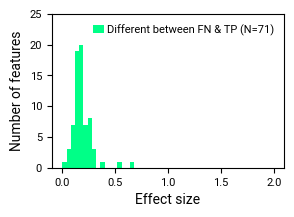

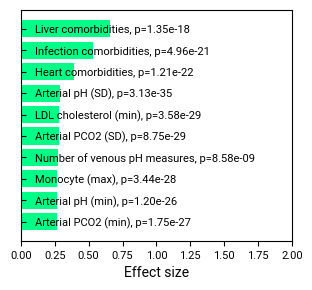

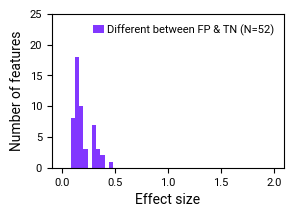

100%|██████████| 10/10 [00:00<00:00, 72315.59it/s]


['Number of previous CRRT treatments, p=1.16e-16', 'Heart comorbidities, p=4.70e-15', 'Phosphorus (mean), p=2.79e-30', 'CCS code 653, p=1.76e-27', 'CCS code 210, p=4.35e-45', 'Phosphorus (min), p=3.44e-52', 'Number of troponin I measures, p=1.28e-52', 'Age, p=3.91e-09', 'Infection comorbidities, p=2.19e-16', 'Liver comorbidities, p=2.67e-14']


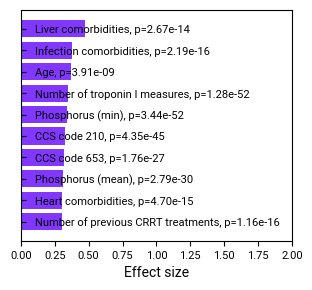

In [35]:
plot_randomness(all_preselectall, 'ucla_crrt+cedars_crrt_8_v2', correction=True)

True    17
Name: Reject H0, dtype: int64
['DP17_min, p=6.43e-09', 'N-ACETYLTYROSINE, URINE_max, p=3.99e-05', 'DP19_min, p=1.66e-06', 'DP19_max, p=9.89e-10', 'ABSOLUTE PLASMA CELL CT, MANUAL_mean, p=4.14e-08', 'IGG ALBUMIN SYN_std, p=3.85e-07', 'ABSOLUTE PLASMA CELL CT, MANUAL_max, p=4.89e-07', 'IONIZED CALCIUM(NON-PATIENT)_max, p=8.11e-06', 'IGG ALBUMIN SYN_mean, p=7.32e-07', 'IONIZED CALCIUM(NON-PATIENT)_min, p=9.23e-09']


100%|██████████| 10/10 [00:00<00:00, 73326.99it/s]


True    27
Name: Reject H0, dtype: int64


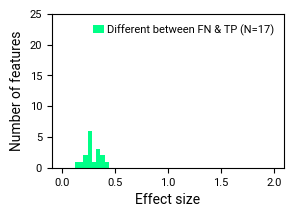

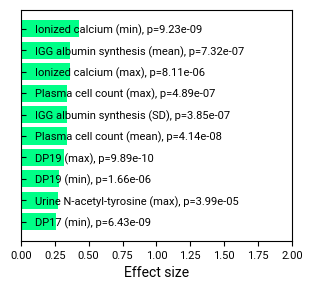

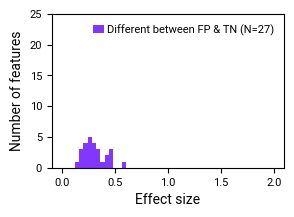

['DP19_min, p=1.44e-06', 'DP19_max, p=1.01e-07', 'IRON BINDING CAPACITY(QST)_max, p=1.95e-09', 'IONIZED CALCIUM(NON-PATIENT)_max, p=2.27e-05', 'IONIZED CALCIUM(NON-PATIENT)_min, p=5.13e-07', 'ALDOSTERONE,SERUM_len, p=2.65e-06', 'ALDOSTERONE,SERUM_mean, p=1.08e-10', 'PHENYLACETIC, URINE_min, p=2.37e-10', 'ALDOSTERONE,SERUM_std, p=6.85e-10', 'HISTOPLASMA ANTIGEN RESULT_len, p=1.09e-10']


100%|██████████| 10/10 [00:00<00:00, 76398.98it/s]

['DP19 (min), p=1.44e-06', 'DP19 (max), p=1.01e-07', 'Iron binding capacity (max), p=1.95e-09', 'Ionized calcium (max), p=2.27e-05', 'Ionized calcium (min), p=5.13e-07', 'Number of Aldosterone measures, p=2.65e-06', 'Aldosterone (mean), p=1.08e-10', 'Urine phenylacetic (min), p=2.37e-10', 'Aldosterone (SD), p=6.85e-10', 'Number of histoplasma antigen measures, p=1.09e-10']


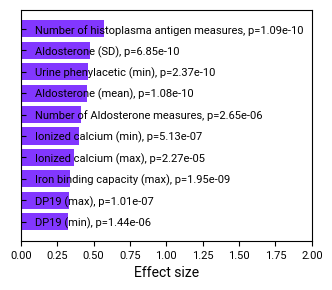

In [191]:
plot_randomness(ucla_train, 'ucla_crrt_8_v2', correction=True)
# plot_randomness(ucla_train, 'cedars_crrt_8_v2', correction=True)
# plot_randomness(cedars_train, 'cedars_crrt_8_v2', correction=True)
# plot_randomness(cedars_train, 'ucla_crrt_8_v2', correction=True)
# plot_randomness(uclapluscedars_preselectcrrt, 'ucla_crrt+cedars_crrt_8_v2', correction=True)

In [17]:

from tqdm import tqdm
def plot_randomness(run_name, filter, correction=False):
        
        if filter is None:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // rolling window: 0'")
                filter = ""
        else:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set2.colors)       
        colors = ['#00FF87', '#8237FF'] 
        df = pd.read_csv(join(exp_path, run.info.run_id, 'artifacts',f"{run.data.tags['modeln']}_test__dist_comparison_table.csv"))

        if correction:
                pthresh = 0.05/len(df)
        else:
                pthresh = 0.05
        df_fntp = df[df['Unnamed: 0']=='fn_vs_tp']
        df_fntp_true = df_fntp[(df_fntp['Reject H0']==True) & (df_fntp['p-value']<pthresh)]
        df_fntp_true_var = df_fntp_true['Unnamed: 1']
        print(df_fntp_true['Reject H0'].value_counts())

        df_fntn = df[df['Unnamed: 0']=='fn_vs_tn']
        df_fntn_shared = df_fntn[df_fntn['Unnamed: 1'].isin(df_fntp_true_var)]
        print(df_fntn_shared['Reject H0'].value_counts())
        df_fntn_shared_false = df_fntn_shared[df_fntn_shared['Reject H0']==False]['Unnamed: 1']
        df_fntn_shared_true = df_fntn_shared[(df_fntn_shared['Reject H0']==True)& (df_fntn_shared['p-value']<pthresh)]['Unnamed: 1']

        ### PLOT
        plt.figure(figsize=(3,2))
        plt.hist(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_false)]['Effect Size'], bins=50, range=(0,2), 
                label=f"Similar to TN (N={len(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_false)]['Effect Size'])})",
                 color=colors[0])
        plt.hist(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_true)]['Effect Size'], bins=50, range=(0,2),
                label=f"Different from TN (N={len(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_true)]['Effect Size'])})",
                 color=colors[1])
        plt.xlabel('Effect size')
        plt.ylabel('Number of features')
        plt.ylim([0,15])
        plt.legend(frameon=False, handlelength=1,handletextpad=0.25,)
        plt.savefig(f'./posthoc/randomness_fn_{run_name}_{filter}.svg', format='svg',  bbox_inches="tight")

        plt.figure(figsize=(3.6,3))
        relevant = df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_false)].sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        
        x_axis = convert_str(x_axis)
        
        p = plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4,  color=colors[0])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(f'./posthoc/randomness_fn_feat_{run_name}_{filter}.svg', format='svg',  bbox_inches="tight")

        df_fptn = df[df['Unnamed: 0']=='fp_vs_tn']
        df_fptn_true = df_fptn[(df_fptn['Reject H0']==True)&(df_fptn['p-value']<pthresh)]
        df_fptn_true_var = df_fptn_true['Unnamed: 1']
        print(df_fptn_true['Reject H0'].value_counts())

        df_fptp = df[df['Unnamed: 0']=='fp_vs_tp']
        df_fptp_shared = df_fptp[df_fptp['Unnamed: 1'].isin(df_fptn_true_var)]
        print(df_fptp_shared['Reject H0'].value_counts())
        df_fptp_shared_false = df_fptp_shared[df_fptp_shared['Reject H0']==False]['Unnamed: 1']
        df_fptp_shared_true = df_fptp_shared[(df_fptp_shared['Reject H0']==True)&(df_fptp_shared['p-value']<pthresh)]['Unnamed: 1']
        
        ## PLOT
        plt.figure(figsize=(3,2))
        plt.hist(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_false)]['Effect Size'], bins=50, range=(0,2),
                label=f"Similar to TP (N={len(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_false)]['Effect Size'])})",
                color=colors[0])
        plt.hist(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_true)]['Effect Size'], bins=50, range=(0,2),
                label=f"Different from TP (N={len(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_true)]['Effect Size'])})",
                color=colors[1])
        plt.xlabel('Effect size')
        plt.ylabel('Number of features')
        plt.ylim([0,15])
        plt.legend(frameon=False, handlelength=1,handletextpad=0.25,)
        plt.savefig(f'./posthoc/randomness_fp_{run_name}_{filter}.svg', format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()

        plt.figure(figsize=(3.6,3))
        relevant = df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_false)].sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        
        x_axis = convert_str(x_axis)
        print(x_axis)
        plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4, color=colors[0])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(f'./posthoc/randomness_fp_feat_{run_name}_{filter}.svg', format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()


True    214
Name: Reject H0, dtype: int64
False    141
True      73
Name: Reject H0, dtype: int64


100%|██████████| 10/10 [00:00<00:00, 79588.31it/s]


True    183
Name: Reject H0, dtype: int64
False    155
True      28
Name: Reject H0, dtype: int64


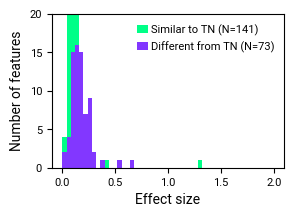

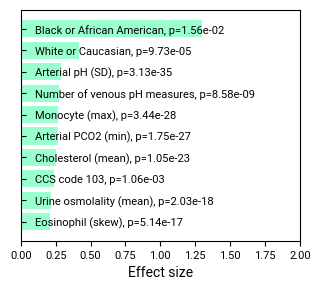

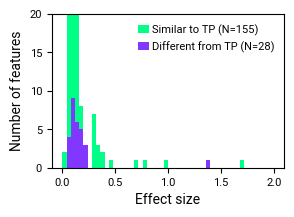

100%|██████████| 10/10 [00:00<00:00, 98922.26it/s]


['CCS code 210, p=4.35e-45', 'Phosphorus (min), p=3.44e-52', 'Number of troponin I measures, p=1.28e-52', 'Age, p=3.91e-09', 'Infection comorbidities, p=2.19e-16', 'Liver comorbidities, p=2.67e-14', 'Sex, p=2.74e-02', 'Ethnicity, p=7.30e-03', 'Unknown race, p=3.13e-03', 'CCS code 109, p=1.34e-02']


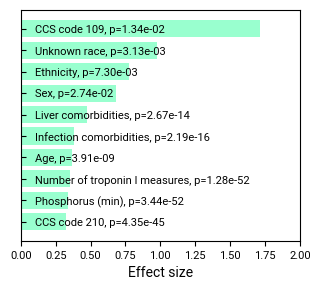

In [15]:
plot_randomness(all_preselectall, 'ucla_crrt+cedars_crrt_8_v2', correction=False)

True    71
Name: Reject H0, dtype: int64
True     37
False    34
Name: Reject H0, dtype: int64


100%|██████████| 10/10 [00:00<00:00, 51025.60it/s]


True    52
Name: Reject H0, dtype: int64
False    37
True     15
Name: Reject H0, dtype: int64


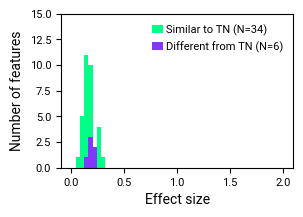

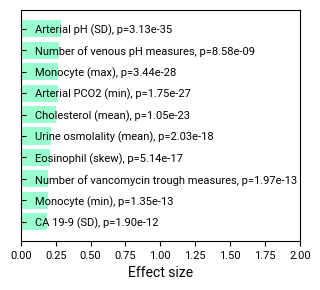

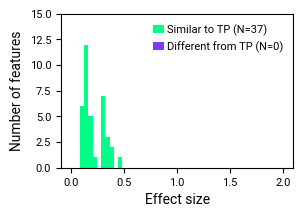

100%|██████████| 10/10 [00:00<00:00, 36345.79it/s]


['Number of previous CRRT treatments, p=1.16e-16', 'Heart comorbidities, p=4.70e-15', 'Phosphorus (mean), p=2.79e-30', 'CCS code 653, p=1.76e-27', 'CCS code 210, p=4.35e-45', 'Phosphorus (min), p=3.44e-52', 'Number of troponin I measures, p=1.28e-52', 'Age, p=3.91e-09', 'Infection comorbidities, p=2.19e-16', 'Liver comorbidities, p=2.67e-14']


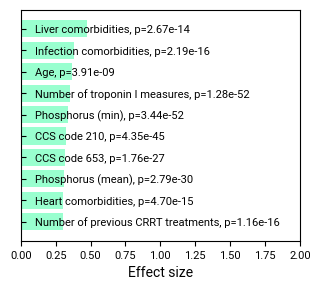

In [18]:
plot_randomness(all_preselectall, 'ucla_crrt+cedars_crrt_8_v2', correction=True)

In [22]:
from tqdm import tqdm
def plot_randomness(run_name, filter, correction=False):
        
        if filter is None:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // rolling window: 0'")
                filter = ""
        else:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set2.colors)       
        colors = ['#00FF87', '#8237FF'] 
        df = pd.read_csv(join(exp_path, '0b9c95fb5559450088871c3a721174f4', 'artifacts',f"{run.data.tags['modeln']}_test__dist_comparison_table.csv"))

        if correction:
                pthresh = 0.05/len(df)
        else:
                pthresh = 0.05
                
        df_fntp = df[df['Unnamed: 0']=='fn_vs_tp']
        df_fntp_true = df_fntp[(df_fntp['Reject H0']==True) & (df_fntp['p-value']<pthresh)]
        df_fntp_true_var = df_fntp_true['Unnamed: 1']
        print(df_fntp_true['Reject H0'].value_counts())

        df_tntp = df[df['Unnamed: 0']=='tn_vs_tp']
        df_tntp_shared = df_tntp[df_tntp['Unnamed: 1'].isin(df_fntp_true_var)]
        print(df_tntp_shared['Reject H0'].value_counts())
        df_tntp_shared_false = df_tntp_shared[df_tntp_shared['Reject H0']==False]['Unnamed: 1']
        df_tntp_shared_true = df_tntp_shared[(df_tntp_shared['Reject H0']==True)& (df_tntp_shared['p-value']<pthresh)]['Unnamed: 1']

        ### PLOT
        plt.figure(figsize=(3,2))
        plt.hist(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_tntp_shared_true)]['Effect Size'], bins=50, range=(0,2), 
                label=f"Explained (N={len(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_tntp_shared_true)]['Effect Size'])})",
                 color=colors[0])
        plt.hist(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_tntp_shared_false)]['Effect Size'], bins=50, range=(0,2),
                label=f"Not explained (N={len(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_tntp_shared_false)]['Effect Size'])})",
                 color=colors[1])
        plt.xlabel('Effect size')
        plt.ylabel('Number of features')
        plt.ylim([0,20])
        plt.legend(frameon=False, handlelength=1,handletextpad=0.25,)
        plt.savefig(f'./posthoc/randomness_fn_{run_name}_{filter}.svg', format='svg',  bbox_inches="tight")

        plt.figure(figsize=(3.5,3))
        relevant = df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_tntp_shared_true)].sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        x_axis = convert_str(x_axis)
        
        p = plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4,  color=colors[0])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(f'./posthoc/randomness_fnexplained_feat_{run_name}_{filter}.svg', format='svg',  bbox_inches="tight")
        
        plt.figure(figsize=(3.5,3))
        relevant = df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_tntp_shared_false)].sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        
        x_axis = convert_str(x_axis)
        
        p = plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4,  color=colors[1])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(f'./posthoc/randomness_fnnotexplained_feat_{run_name}_{filter}.svg', format='svg',  bbox_inches="tight")

        ######################### 
        df_fptn = df[df['Unnamed: 0']=='fp_vs_tn']
        df_fptn_true = df_fptn[(df_fptn['Reject H0']==True)&(df_fptn['p-value']<pthresh)]
        df_fptn_true_var = df_fptn_true['Unnamed: 1']
        print(df_fptn_true['Reject H0'].value_counts())

        df_tntp = df[df['Unnamed: 0']=='tn_vs_tp']
        df_tntp_shared = df_tntp[df_tntp['Unnamed: 1'].isin(df_fptn_true_var)]
        print(df_tntp_shared['Reject H0'].value_counts())
        df_tntp_shared_false = df_tntp_shared[df_tntp_shared['Reject H0']==False]['Unnamed: 1']
        df_tntp_shared_true = df_tntp_shared[(df_tntp_shared['Reject H0']==True)&(df_tntp_shared['p-value']<pthresh)]['Unnamed: 1']
        
        ## PLOT
        plt.figure(figsize=(3,2))
        plt.hist(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_tntp_shared_true)]['Effect Size'], bins=50, range=(0,2),
                label=f"Explained (N={len(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_tntp_shared_true)]['Effect Size'])})",
                color=colors[0])
        plt.hist(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_tntp_shared_false)]['Effect Size'], bins=50, range=(0,2),
                label=f"Not explained (N={len(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_tntp_shared_false)]['Effect Size'])})",
                color=colors[1])
        plt.xlabel('Effect size')
        plt.ylabel('Number of features')
        plt.ylim([0,20])
        plt.legend(frameon=False, handlelength=1,handletextpad=0.25,)
        plt.savefig(f'./posthoc/randomness_fp_{run_name}_{filter}.svg', format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()

        plt.figure(figsize=(3.5,3))
        relevant = df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_tntp_shared_true)].sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        
        x_axis = convert_str(x_axis)
        plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4, color=colors[0])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(f'./posthoc/randomness_fpexplained_feat_{run_name}_{filter}.svg', format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()
        
        plt.figure(figsize=(3.5,3))
        relevant = df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_tntp_shared_false)].sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        
        x_axis = convert_str(x_axis)
        plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4, color=colors[1])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(f'./posthoc/randomness_fpnotexplained_feat_{run_name}_{filter}.svg', format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()


True    214
Name: Reject H0, dtype: int64
True     152
False     62
Name: Reject H0, dtype: int64


100%|██████████| 10/10 [00:00<00:00, 90006.52it/s]


True    183
Name: Reject H0, dtype: int64
True     106
False     77
Name: Reject H0, dtype: int64


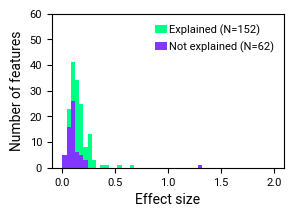

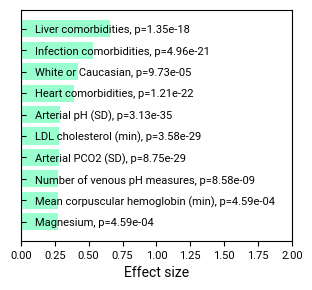

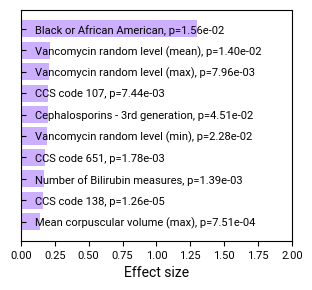

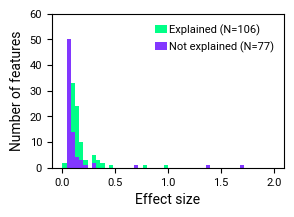

100%|██████████| 10/10 [00:00<00:00, 40524.68it/s]


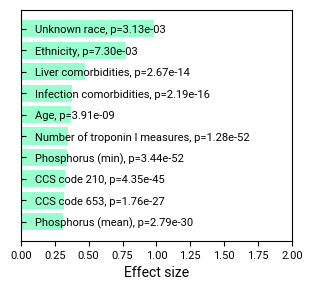

100%|██████████| 10/10 [00:00<00:00, 53498.78it/s]


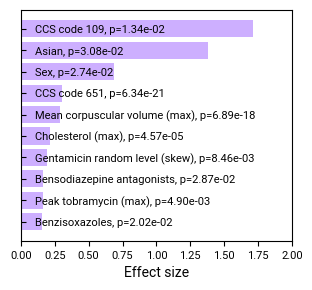

In [21]:
# plot_randomness(all_preselectall, None)
# plot_randomness(all_preselectall, 'ucla_crrt+cedars_crrt_8')
plot_randomness(all_preselectall, 'ucla_crrt+cedars_crrt_8_v2')

True    68
Name: Reject H0, dtype: int64
True     64
False     4
Name: Reject H0, dtype: int64


100%|██████████| 4/4 [00:00<00:00, 46218.23it/s]


True    50
Name: Reject H0, dtype: int64
True     47
False     3
Name: Reject H0, dtype: int64


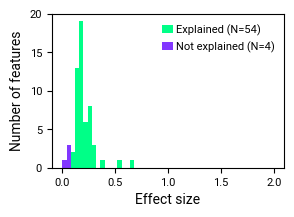

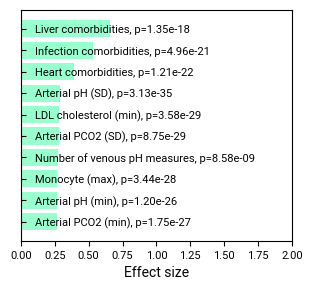

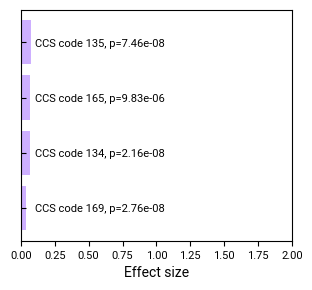

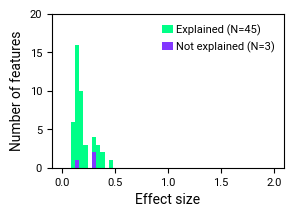

100%|██████████| 10/10 [00:00<00:00, 72440.48it/s]


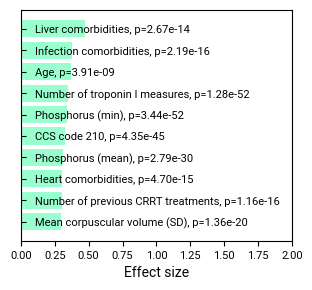

100%|██████████| 3/3 [00:00<00:00, 35444.82it/s]


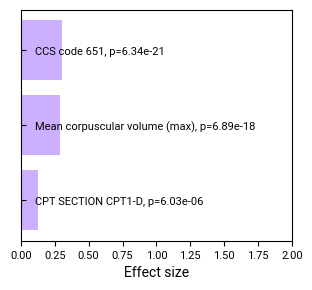

In [24]:
plot_randomness(all_preselectall, 'ucla_crrt+cedars_crrt_8_v2', correction=True)

# Error analysis

In [116]:
CONVERSION = {
    'MEAN CORPUSCULAR VOLUME': 'Mean corpuscular volume',
    'Num Prev CRRT Treatments': 'Number of previous CRRT treatments',
    'PHOSPHORUS': "Phosphorus",
    'PH, ARTERIAL': "Arterial pH",
    'CHOLESTEROL,LDL,CALCULATED': "LDL cholesterol",
    'CODE': 'code',
    'surgery_indicator': "Surgery before CRRT",
    'TOBRAMYCIN,PEAK': 'Peak tobramycin',
    'EOSINOPHIL,FLUID': 'eosinophil',
    'VANCOMYCIN,RANDOM': "Vancomycin random level",
    'PCO2, ARTERIAL': 'Arterial PCO2',
    'PCO2,VENOUS': 'Venous PCO2',
    'PHARM_SUBCLASS_ANTIPSYCHOTICS - MISC.': "Antipsychotics",
    'PH,VENOUS': "Venous pH",
    'ADAMTS13 ACTIVITY': "ADAMTS13 activity",
    'TRIGLYCERIDES,FLUID': 'Triglycerides',
    'PHARM_SUBCLASS_CEPHALOSPORINS - 1ST GENERATION': "Cephalosporins - 1st generation",
    'PHENOBARBITAL': "Phenobarbital",
    'IRON BINDING CAPACITY(QST)': "Iron binding capacity",
    'FIBRINOGEN DEGRAD PROD':"Fibrinogen degradation products",
    'GLUCOSE': "Glucose",
    'TOTAL POLYUNSATURATED ACID': "Polyunsaturated acid",
    '5-HYDROXYHEXANOIC, URINE': "Urine 5-hydroxyhexanoic",
    'IONIZED CA++,CORRECTED,ANES': "Ionized calcium",
    'VARICELLA-ZOSTER VIRUS IGM AB': "Varicella-zoster IGM antibody",
    '3-HYDROXYGLUTARIC, URINE': "Urine 3-hydroxyglutaric",
    'VALPROIC ACID': "Valproic acid",
    '% SATURATION(QST)': "Percent iron saturation",
    'ABSOLUTE BASO COUNT': "Basophil count",
    'ALBUMIN/GLOBULIN RATIO(QST)': "Albumin to globulin ratio",
    'BASE EXCESS, ARTERIAL,POC': 'Arterial base excess',
    'URIC ACID(LDQ)': "Uric acid",
    'ETHNICITY': "Ethnicity",
    'APTT 1:1 NORMAL POOL MIX': "Activated partial thromboplastin time",
    'liver_pt_indicator': "Liver comorbidities",
    'WHITE BLOOD CELL COUNT': 'White blood cell count',
     'TACROLIMUS BLOOD': "Tacrolimus blood",
     'MICROALBUMIN/CREATININE RATIO': 'Microalbumin to creatinine ratio',
     'C-REACTIVE PROTEIN': 'C-reactive protein',
    'LEUKOCYTE ALKALINE PHOSPHATASE': "Leukocyte alkaline phosphatase",
        'MONOCLONAL PROTEIN': 'Monoclonal protein',
        'INTERPRETATION IN31 GALACTOAMMAN': 'galactoamman',
        'POTASSIUM,POC': "Potassium",
        '% OF CELLS COUNTED': "Percent of cells counted",
        'PHARM_SUBCLASS_ELECTROLYTE MIXTURES': "Electrolyte mixtures",
        'FERRITIN':"Ferritin",
        'PO2, ARTERIAL': "Arterial PO2",
        'ALT (SGPT)': 'Alanine aminotransferase',
        'ABSOLUTE LYMPHOCYTE COUNT': "Lymphocyte count",
        'GAMMA GLOBULINS': "Gamma globulins",
        'VITAMIN B12': 'Vitamin B12',
        'RED BLOOD CELL COUNT': "red blood cell count"

}

def convert_str(x_axis):
        for i in tqdm(range(len(x_axis))):
                curr_name = x_axis[i]
                if 'dx_' in curr_name:
                        curr_name = curr_name.replace('dx_','')
                if 'pr_' in curr_name:
                        curr_name = curr_name.replace('pr_','')
                if 'RACE_' in curr_name:
                        curr_name = curr_name.replace('RACE_','')
                                
                for key, val in CONVERSION.items():
                        if key in curr_name:
                                curr_name = curr_name.replace(key, val)
                        
                if '_std' in curr_name:
                        curr_name = curr_name.replace('_std',' (SD)')
                if '_min' in curr_name:
                        curr_name = curr_name.replace('_min',' (min)')
                if '_mean' in curr_name:
                        curr_name = curr_name.replace('_mean',' (mean)')
                if '_max' in curr_name:
                        curr_name = curr_name.replace('_max',' (max)')
                if '_skew' in curr_name:
                        curr_name = curr_name.replace('_skew',' (skew)')
                if '_len' in curr_name:
                        curr_name = "Number of " + curr_name.replace('_len',' measures')
                
                curr_name = curr_name.replace('_', ' ')
                x_axis[i] = curr_name
        return x_axis
        

def plot_error(run_name, filter):
    if filter is None:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // rolling window: 0'")
        filter = ''
    else:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
                
    df = pd.read_csv(join(exp_path, run.info.run_id, 'artifacts','img_artifacts','error_viz', f"{run.data.tags['modeln']}_test__tree_summary_table.csv"))

    # df = pd.read_csv(join('/radraid/jeffreyfeng/CRRT_Project/mlflow/all_to_all_preselectall_tune50_v2/mlruns/383254084501025332/', '5dd07633573c46808fd1183b4172d835', 'artifacts','img_artifacts','error_viz', f"lgb_test__tree_summary_table.csv"))

    nodes_to_leaf = df['nodes_to_leaf']
    # print(nodes_to_leaf)
    
    print(nodes_to_leaf)
    nodes_to_leaf = convert_str(nodes_to_leaf)

    incorrect = df['incorrect']
    correct = df['correct']

    fig, ax = plt.subplots()
    left = np.zeros(len(nodes_to_leaf))
    ax.barh(
        nodes_to_leaf[::-1],
        incorrect[::-1],
        0.5,
        label="incorrect",
        left=left,
        color="#FF00A5",
    )
    left += incorrect[::-1]
    ax.barh(
        nodes_to_leaf[::-1],
        correct[::-1],
        0.5,
        label="correct",
        left=left,
        color="#DAEBFE",
    )
    ax.legend(frameon=False, columnspacing=0.5,handlelength=1,handletextpad=0.25,
              loc="lower right", bbox_to_anchor=(1.03, -0.01))
    ax.set_xlabel("Patient Counts")
    fig.set_size_inches(2,5)
    
    plt.savefig(f'./posthoc/error_tree_summary_{run_name}_{filter}.svg', format='svg',  bbox_inches="tight")
    plt.show()
    plt.close()
    


  0%|          | 0/10 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 10/10 [00:00<00:00, 3437.11it/s]


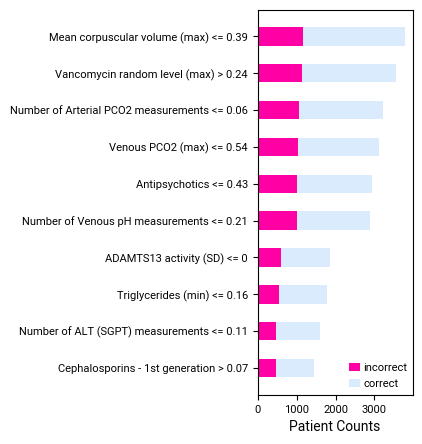

In [220]:
# plot_error(all_preselectall, None)
# plot_error(all_preselectall, 'ucla_crrt+cedars_crrt_8')
plot_error(all_preselectall, 'ucla_crrt+cedars_crrt_8_v2')

0                  PHENOBARBITAL_skew <= 0.96
1                      DQB1*06:03_min <= 0.23
2      IRON BINDING CAPACITY(QST)_max <= 0.19
3     FIBRINOGEN DEGRAD PROD (FDP)_std > 0.22
4                    GLUCOSE, CSF_min <= 0.31
5      TOTAL POLYUNSATURATED ACID_mean > 0.06
6       5-HYDROXYHEXANOIC, URINE_mean <= 0.28
7                        DRB5*02:02_len > 0.4
8     IONIZED CA++,CORRECTED,ANES_skew > 0.18
9    VARICELLA-ZOSTER VIRUS IGM AB_len > 0.19
Name: nodes_to_leaf, dtype: object


  0%|          | 0/10 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 10/10 [00:00<00:00, 3470.67it/s]


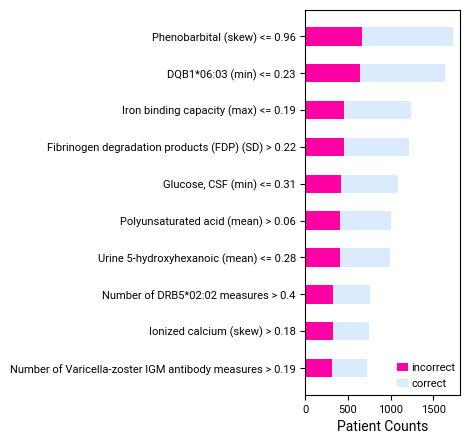

0        3-HYDROXYGLUTARIC, URINE_min <= 0.03
1                  VALPROIC ACID_mean <= 0.06
2               % SATURATION(QST)_max <= 0.43
3             ABSOLUTE BASO COUNT_mean > 0.43
4        APTT 1:1 NORMAL POOL MIX_max <= 0.26
5    ALBUMIN/GLOBULIN RATIO(QST)_skew <= 0.11
6        BASE EXCESS, ARTERIAL,POC_min > 0.18
7                 URIC ACID(LDQ)_skew <= 0.12
8                            ETHNICITY <= 0.5
9     ALBUMIN/GLOBULIN RATIO(QST)_skew > 0.06
Name: nodes_to_leaf, dtype: object


  0%|          | 0/10 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 10/10 [00:00<00:00, 4598.01it/s]


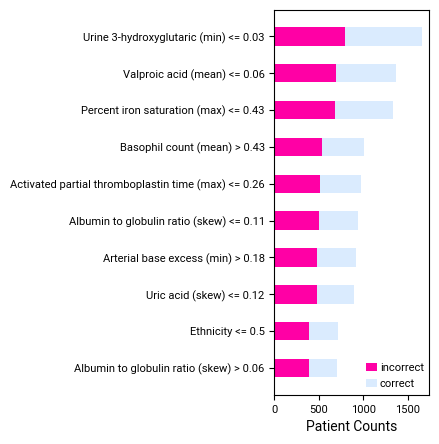

0                     liver_pt_indicator <= 0.5
1             WHITE BLOOD CELL COUNT_min > 0.53
2                  TACROLIMUS BLOOD_skew > 0.38
3     MICROALBUMIN/CREATININE RATIO_len <= 0.01
4               C-REACTIVE PROTEIN_skew <= 0.31
5                       pr_CCS_CODE_100 <= 0.22
6                         dx_CCS_CODE_2 <= 0.72
7    LEUKOCYTE ALKALINE PHOSPHATASE_max <= 0.25
8                        pr_CCS_CODE_58 <= 0.17
9               MONOCLONAL PROTEIN_mean <= 0.17
Name: nodes_to_leaf, dtype: object


  0%|          | 0/10 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 10/10 [00:00<00:00, 1568.84it/s]


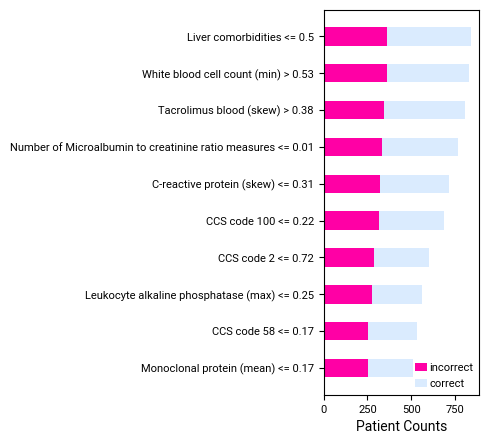

0    INTERPRETATION IN31 GALACTOAMMAN_len <= 0.06
1                 MONOCLONAL PROTEIN_mean <= 0.37
2                       POTASSIUM,POC_max <= 0.83
3      LEUKOCYTE ALKALINE PHOSPHATASE_max <= 0.25
4                               Weight_len <= 0.4
5                  % OF CELLS COUNTED_min <= 0.74
6         PHARM_SUBCLASS_ELECTROLYTE MIXTURES > 0
7                           dx_CCS_CODE_56 > 0.39
8                           FERRITIN_mean <= 0.67
9                  % OF CELLS COUNTED_min <= 0.11
Name: nodes_to_leaf, dtype: object


  0%|          | 0/10 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 10/10 [00:00<00:00, 1572.55it/s]


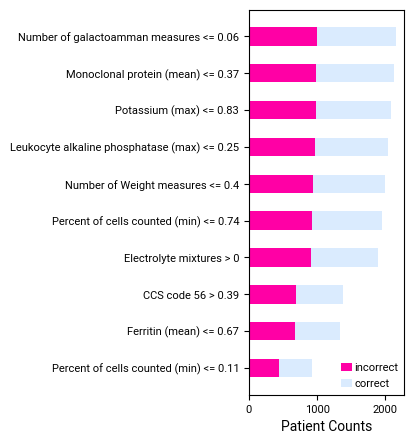

0                 PO2, ARTERIAL_mean > 0.02
1                     ALT (SGPT)_std > 0.07
2                PO2, ARTERIAL_skew <= 0.06
3    ABSOLUTE LYMPHOCYTE COUNT_skew <= 0.65
4                    dx_CCS_CODE_215 > 0.04
5                   dx_CCS_CODE_233 <= 0.31
6                GAMMA GLOBULINS_std > 0.03
7                     VITAMIN B12_max > 0.1
8          RED BLOOD CELL COUNT_len <= 0.08
9             VANCOMYCIN,RANDOM_std <= 0.03
Name: nodes_to_leaf, dtype: object


  0%|          | 0/10 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 10/10 [00:00<00:00, 3018.35it/s]


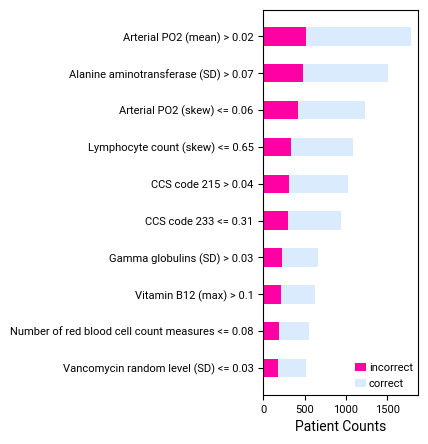

In [118]:
plot_error(ucla_train, 'ucla_crrt_8_v2')
plot_error(ucla_train, 'cedars_crrt_8_v2')
plot_error(cedars_train, 'cedars_crrt_8_v2')
plot_error(cedars_train, 'ucla_crrt_8_v2')
plot_error(uclapluscedars_preselectcrrt, 'ucla_crrt+cedars_crrt_8_v2')

# Explanations

In [210]:
from collections import defaultdict
import seaborn as sns

CONVERSION = {
    'MEAN CORPUSCULAR VOLUME': 'Mean corpuscular volume',
    'Num Prev CRRT Treatments': 'Number of previous CRRT treatments',
    'PHOSPHORUS': "Phosphorus",
    'PH, ARTERIAL': "Arterial pH",
    'CHOLESTEROL,LDL,CALCULATED': "LDL cholesterol",
    'CODE': 'code',
    'surgery_indicator': "Surgery before CRRT",
    'TOBRAMYCIN,PEAK': 'Peak tobramycin',
    'EOSINOPHIL,FLUID': 'eosinophil',
    'VANCOMYCIN,RANDOM': "Vancomycin random level",

    'PCO2, ARTERIAL': 'Arterial PCO2',
    'PCO2,VENOUS': 'Venous PCO2',
    'PHARM_SUBCLASS_ANTIPSYCHOTICS - MISC.': "Antipsychotics",
    'PH,VENOUS': "Venous pH",
    'ADAMTS13 ACTIVITY': "ADAMTS13 activity",
    'TRIGLYCERIDES,FLUID': 'Triglycerides',
    'PHARM_SUBCLASS_CEPHALOSPORINS - 1ST GENERATION': "Cephalosporins - 1st generation",
    'PHENOBARBITAL': "Phenobarbital",
    'IRON BINDING CAPACITY(QST)': "Iron binding capacity",
    'FIBRINOGEN DEGRAD PROD':"Fibrinogen degradation products",
    'GLUCOSE': "Glucose",
    'TOTAL POLYUNSATURATED ACID': "Polyunsaturated acid",
    '5-HYDROXYHEXANOIC, URINE': "Urine 5-hydroxyhexanoic",
    'IONIZED CA++,CORRECTED,ANES': "Ionized calcium",
    'VARICELLA-ZOSTER VIRUS IGM AB': "Varicella-zoster IGM antibody",
    '3-HYDROXYGLUTARIC, URINE': "Urine 3-hydroxyglutaric",
    'VALPROIC ACID': "Valproic acid",
    '% SATURATION(QST)': "Percent iron saturation",
    'ABSOLUTE BASO COUNT': "Basophil count",
    'ALBUMIN/GLOBULIN RATIO(QST)': "Albumin to globulin ratio",
    'BASE EXCESS, ARTERIAL,POC': 'Arterial base excess',
    'URIC ACID(LDQ)': "Uric acid",
    'ETHNICITY': "Ethnicity",
    'APTT 1:1 NORMAL POOL MIX': "Activated partial thromboplastin time",
    'liver_pt_indicator': "Liver comorbidities",
    'WHITE BLOOD CELL COUNT': 'White blood cell count',
     'TACROLIMUS BLOOD': "Tacrolimus blood",
     'MICROALBUMIN/CREATININE RATIO': 'Microalbumin to creatinine ratio',
     'C-REACTIVE PROTEIN': 'C-reactive protein',
    'LEUKOCYTE ALKALINE PHOSPHATASE': "Leukocyte alkaline phosphatase",
        'MONOCLONAL PROTEIN': 'Monoclonal protein',
        'INTERPRETATION IN31 GALACTOAMMAN': 'galactoamman',
        'POTASSIUM,POC': "Potassium",
        '% OF CELLS COUNTED': "Percent of cells counted",
        'PHARM_SUBCLASS_ELECTROLYTE MIXTURES': "Electrolyte mixtures",
        'FERRITIN':"Ferritin",
        'PO2, ARTERIAL': "Arterial PO2",
        'ALT (SGPT)': 'Alanine aminotransferase',
        'ABSOLUTE LYMPHOCYTE COUNT': "Lymphocyte count",
        'GAMMA GLOBULINS': "Gamma globulins",
        'VITAMIN B12': 'Vitamin B12',
        'RED BLOOD CELL COUNT': "red blood cell count",
        'HISTOPLASMA ANTIGEN RESULT':"histoplasma antigen",
        'GLYCOLIC, URINE': "urine glycolic",
        'PHENYLACETIC, URINE': "Urine phenylacetic",
        'IONIZED CALCIUM(NON-PATIENT)': "Ionized calcium",
        '2-METHYL,3-HYDROXYBUTYRIC, URINE': 'Urine 2-methyl, 3-hydroxybutyric',
        'BASE EXCESS,ECMO PREMEMBRANE': "ECMO premembrane",
        'PHARM_SUBCLASS_OPHTHALMIC IMMUNOMODULATORS': "Ophthalmic immunomodulators",
        '3-HYDROXYBUTYRIC, URINE': "Urine 3-hydroxybutyric",
        'CPT_SECTION': "CPT section",
        'UREA NITROGEN, 24 HR UR': "Urea nitrogen",
        'Unknown': "Unknown race",
        'URINE CALCIUM-MG/DL': "Urine calcium",
        'T3,TOTAL': 'Triiodothyronine',
        'PHARM_SUBCLASS_PHENOTHIAZINES': "Phenothiazines",
    'PHARM_SUBCLASS_PERIPHERAL OPIOID RECEPTOR ANTAGONISTS': "Peripheral opioid receptor antagonists",
    'ALDOLASE-ALDL': "Alsolase",
    'LYMPHOCYTE':"Lymphocyte",
    'ALPHA-1-ANTITRYPSIN': 'Alpha-1-antitrypsin',
    'PROTEIN S ANTIGEN,TOTAL': "Protein S antigen",
    'VANCOMYCIN,TROUGH': "Vancomycin trough level",
    'FREE T3': "Free triiodothyronine"
        
}

def convert_str(x_axis):
    for i in tqdm(range(len(x_axis))):
        curr_name = x_axis[i]
        if 'dx_' in curr_name:
                curr_name = curr_name.replace('dx_','')
        if 'pr_' in curr_name:
                curr_name = curr_name.replace('pr_','')
        if 'RACE_' in curr_name:
                curr_name = curr_name.replace('RACE_','')
                        
        for key, val in CONVERSION.items():
                if key in curr_name:
                        curr_name = curr_name.replace(key, val)
                
        if '_std' in curr_name:
                curr_name = curr_name.replace('_std',' (SD)')
        if '_min' in curr_name:
                curr_name = curr_name.replace('_min',' (min)')
        if '_mean' in curr_name:
                curr_name = curr_name.replace('_mean',' (mean)')
        if '_max' in curr_name:
                curr_name = curr_name.replace('_max',' (max)')
        if '_skew' in curr_name:
                curr_name = curr_name.replace('_skew',' (skew)')
        if '_len' in curr_name:
                curr_name = "Number of " + curr_name.replace('_len',' measures')
        
        curr_name = curr_name.replace('_', ' ')
        x_axis[i] = curr_name
    return x_axis
        

def reload_shap_values(array_file):
    
    with open(array_file, 'rb') as f:
        shap_arrays = pickle.load(f)
        
    shap_values = shap.Explanation(shap_arrays['values'], 
                                   base_values=shap_arrays['base_values'], 
                                   data=shap_arrays['data'], 
                                   feature_names=shap_arrays['feature_names'])
    
    shap_values.feature_names = convert_str(shap_values.feature_names[:])
            
    return shap_values, shap_arrays

def plot_swarm(shap_values, idxs=None, limit=None,tag=''):
    
    rankings = get_rankings(shap_values, idxs=idxs)[1]
    if limit is not None:
        rankings = rankings[:limit]
    
    if idxs is not None:
        shap.plots.beeswarm(shap_values[idxs, :, :][:, rankings, 1], show=False,)
    else:
        try:
            shap.plots.beeswarm(shap_values[:, rankings, 1], show=False,)
        except:
            shap.plots.beeswarm(shap_values[:, rankings], show=False,)
        
    figure = plt.gcf()
    figure.set_size_inches(5,5)
    
    plt.savefig(f'./posthoc/{tag}_explanation.svg', format='svg',  bbox_inches="tight")
    plt.show()
    plt.close()
    
    
def plot_waterfall(shap_values, idxs, label, limit=None, tag=''):
    
    # rankings = get_rankings(shap_values, idxs=idxs)[1]
    # if limit is not None:
    #     rankings = rankings[:limit]
    
    rankings = get_rankings(shap_values[[idxs[0]],:], idxs=[0])[1]
    if limit is not None:
        rankings = rankings[:limit]
        

    shap.plots.waterfall(shap_values[idxs[0]][rankings,label], show=False)
    figure = plt.gcf()
    figure.set_size_inches(5,5)
    
    plt.savefig(f'./posthoc/{tag}_explanation_example.svg', format='svg',  bbox_inches="tight")
    plt.show()
    plt.close()

def get_rankings(shap_values, idxs=None):
    
    print(shap_values.values.shape)

    if idxs is not None:
        ranking = np.absolute(shap_values.values[idxs,:,:]).mean(0)[:,1].argsort()[::-1]
    else:
        try:
            ranking = shap_values.abs.mean(0).values[:,1].argsort()[::-1]
        except:
            ranking = shap_values.abs.mean(0).values[:].argsort()[::-1]
        
    ranked_features = [shap_values.feature_names[i] for i in ranking]
    return ranked_features, ranking

def collect_rankings(shap_values, idx_list, idx_labels):
    
    table = {'all': get_rankings(shap_values)[0]}
    
    for idx_label, idxs in zip(idx_labels, idx_list):
        table[idx_label] = get_rankings(shap_values, idxs=idxs)[0]
    
    return table 

def display_rankings(table, feature_list=None, limit=None, annot=False, tag=""):
    
    if feature_list is None:
        feature_list = table['all'][:limit]
        
    rankings = defaultdict(dict)
    
    for i in range(len(feature_list)):
        rankings['ALL'][feature_list[i]] = table['all'].index(feature_list[i])+1
    
    for subgroup in table.keys():
        if subgroup == 'all':
            continue
        
        for i in range(len(feature_list)):
            rankings[subgroup.upper()][feature_list[i]] = table[subgroup].index(feature_list[i])+1
        
    sns.heatmap(pd.DataFrame(rankings),cmap=sns.cubehelix_palette(as_cmap=True),
                cbar_kws={'label': 'Feature Importance Rank'},
                annot=annot
                )
    plt.ylabel('Feature')
    
    plt.savefig(f'./posthoc/{tag}_feature_ranking.svg', format='svg',  bbox_inches="tight")
    plt.show()
    plt.close()
    
def plot_explanations(run_name, filter, limit=None):
    if filter is None:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // rolling window: 0'")
        filter = ""
    else:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
    pth = join(exp_path, run.info.run_id, 'artifacts','img_artifacts','feature_importance', f"{run.data.tags['modeln']}_test__shap_values.pkl")

    # pth = join('/radraid/jeffreyfeng/CRRT_Project/mlflow/all_to_all_preselectall_tune50_v2/mlruns/383254084501025332/', '5dd07633573c46808fd1183b4172d835', 'artifacts','img_artifacts','feature_importance', f"lgb_test__shap_values.pkl")
    shap_values, shap_arrays = reload_shap_values(pth)
    
    top_features = get_rankings(shap_values)[0]
    for i in range(limit):
        for j in range(len(shap_values.feature_names)):
            if top_features[i] == shap_values.feature_names[j]:
                shap_values.feature_names[j] = shap_values.feature_names[j] + f' [{i+1}]'
                break
    
    plot_swarm(shap_values, limit=limit, tag=f'all_{run_name}_{filter}')
    # labels = [1,0,1,0]
    # for filt, label in zip(['tp','tn','fp','fn'], labels):
    #     print(filt)
    #     plot_swarm(shap_values, shap_arrays[filt], limit=limit, tag=f'{filt}_{run_name}_{filter}')
        # plot_waterfall(shap_values, shap_arrays[filt], label, limit=limit, tag=f'{filt}_{run_name}_{filter}')
    
def plot_feature_rankings(run_name,filter,limit=None, feature_list=None, annot=False):
    if filter is None:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // rolling window: 0'")
    else:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
    pth = join(exp_path, run.info.run_id, 'artifacts','img_artifacts','feature_importance', f"{run.data.tags['modeln']}_test__shap_values.pkl")

    # pth = join('/radraid/jeffreyfeng/CRRT_Project/mlflow/all_to_all_preselectall_tune50_v2/mlruns/383254084501025332/', '5dd07633573c46808fd1183b4172d835', 'artifacts','img_artifacts','feature_importance', f"lgb_test__shap_values.pkl")
    shap_values, shap_arrays = reload_shap_values(pth)
    
    table = collect_rankings(shap_values, [shap_arrays[filt] for filt in ['tp','tn','fp','fn']], ['tp','tn','fp','fn'])
    display(pd.DataFrame(table).head(15))
    display_rankings(table, limit=limit, feature_list=feature_list, annot=annot, tag=f'{run_name}_{filter}')


all                              tp  \
0      MEAN CORPUSCULAR VOLUME_std     MEAN CORPUSCULAR VOLUME_std   
1                   PHOSPHORUS_min  CHOLESTEROL,LDL,CALCULATED_min   
2         Num Prev CRRT Treatments                  PHOSPHORUS_min   
3                  dx_CCS_CODE_650        Num Prev CRRT Treatments   
4                surgery_indicator                PH, ARTERIAL_std   
5   CHOLESTEROL,LDL,CALCULATED_min                 dx_CCS_CODE_650   
6             EOSINOPHIL,FLUID_len                 dx_CCS_CODE_113   
7                 PH, ARTERIAL_std               surgery_indicator   
8                  dx_CCS_CODE_113                PH, ARTERIAL_max   
9           VANCOMYCIN,RANDOM_mean            EOSINOPHIL,FLUID_len   
10                  ALT (SGPT)_len                  ALT (SGPT)_len   
11                PH, ARTERIAL_max             TOBRAMYCIN,PEAK_std   
12           VANCOMYCIN,RANDOM_min           OSMOLALITY,URINE_mean   
13              CPT_SECTION_CPT1-E              PCO2, ARTERIAL_min   
14             TOBRAMYCIN,PEAK_std            OSMOLALITY,URINE_std   

                                tn                              fp  \
0      MEAN CORPUSCULAR VOLUME_std        Num Prev CRRT Treatments   
1                   PHOSPHORUS_min               surgery_indicator   
2                  dx_CCS_CODE_650     MEAN CORPUSCULAR VOLUME_std   
3         Num Prev CRRT Treatments                 dx_CCS_CODE_113   
4                surgery_indicator                  PHOSPHORUS_min   
5           VANCOMYCIN,RANDOM_mean                PH, ARTERIAL_std   
6   CHOLESTEROL,LDL,CALCULATED_min                 dx_CCS_CODE_650   
7             EOSINOPHIL,FLUID_len            EOSINOPHIL,FLUID_len   
8                  dx_CCS_CODE_113              CPT_SECTION_CPT1-E   
9                 PH, ARTERIAL_std  CHOLESTEROL,LDL,CALCULATED_min   
10           VANCOMYCIN,RANDOM_min                  ALT (SGPT)_len   
11                  ALT (SGPT)_len           OSMOLALITY,URINE_mean   
12                PH, ARTERIAL_max       LACTATE DEHYDROGENASE_min   
13    MEAN CORPUSCULAR VOLUME_mean                PH, ARTERIAL_max   
14              CPT_SECTION_CPT1-E            OSMOLALITY,URINE_std   

                                fn  
0         Num Prev CRRT Treatments  
1      MEAN CORPUSCULAR VOLUME_std  
2                surgery_indicator  
3                   PHOSPHORUS_min  
4                  dx_CCS_CODE_650  
5             EOSINOPHIL,FLUID_len  
6   CHOLESTEROL,LDL,CALCULATED_min  
7                  dx_CCS_CODE_113  
8                   ALT (SGPT)_len  
9                 PH, ARTERIAL_std  
10              CPT_SECTION_CPT1-E  
11          VANCOMYCIN,RANDOM_mean  
12                    RACE_Unknown  
13                PH, ARTERIAL_max  
14            OSMOLALITY,URINE_std

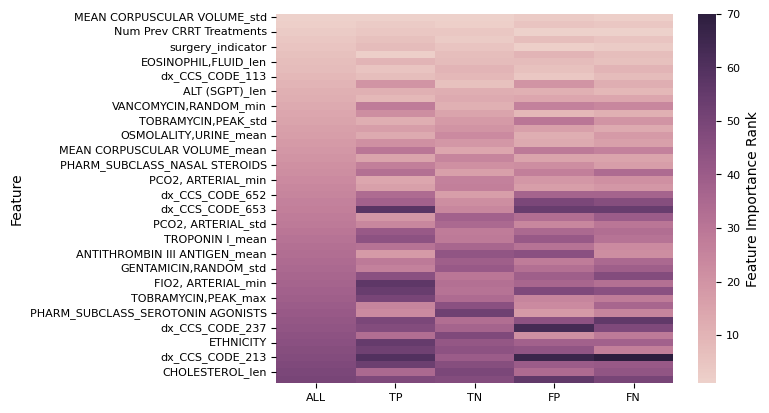

all                              tp  \
0      MEAN CORPUSCULAR VOLUME_std     MEAN CORPUSCULAR VOLUME_std   
1         Num Prev CRRT Treatments                  PHOSPHORUS_min   
2                   PHOSPHORUS_min        Num Prev CRRT Treatments   
3                 PH, ARTERIAL_std                PH, ARTERIAL_std   
4   CHOLESTEROL,LDL,CALCULATED_min  CHOLESTEROL,LDL,CALCULATED_min   
5                  dx_CCS_CODE_650                 dx_CCS_CODE_650   
6                surgery_indicator             TOBRAMYCIN,PEAK_std   
7             EOSINOPHIL,FLUID_len               surgery_indicator   
8              TOBRAMYCIN,PEAK_std                 dx_CCS_CODE_113   
9                  dx_CCS_CODE_113                  ALT (SGPT)_len   
10                  ALT (SGPT)_len            EOSINOPHIL,FLUID_len   
11           OSMOLALITY,URINE_mean           OSMOLALITY,URINE_mean   
12                PH, ARTERIAL_max                PH, ARTERIAL_max   
13            OSMOLALITY,URINE_std              PCO2, ARTERIAL_min   
14                  URIC ACID_mean            OSMOLALITY,URINE_std   

                                tn                              fp  \
0         Num Prev CRRT Treatments     MEAN CORPUSCULAR VOLUME_std   
1      MEAN CORPUSCULAR VOLUME_std                  PHOSPHORUS_min   
2                   PHOSPHORUS_min             TOBRAMYCIN,PEAK_std   
3                surgery_indicator        Num Prev CRRT Treatments   
4             EOSINOPHIL,FLUID_len                PH, ARTERIAL_std   
5                  dx_CCS_CODE_113  CHOLESTEROL,LDL,CALCULATED_min   
6   CHOLESTEROL,LDL,CALCULATED_min                 dx_CCS_CODE_650   
7                 PH, ARTERIAL_std            EOSINOPHIL,FLUID_len   
8                  dx_CCS_CODE_650                 dx_CCS_CODE_113   
9                   ALT (SGPT)_len               surgery_indicator   
10       LACTATE DEHYDROGENASE_min                  ALT (SGPT)_len   
11            OSMOLALITY,URINE_std            OSMOLALITY,URINE_std   
12   PHARM_SUBCLASS_NASAL STEROIDS           OSMOLALITY,URINE_mean   
13                  URIC ACID_mean                PH, ARTERIAL_max   
14           OSMOLALITY,URINE_mean                  URIC ACID_mean   

                                fn  
0         Num Prev CRRT Treatments  
1      MEAN CORPUSCULAR VOLUME_std  
2             EOSINOPHIL,FLUID_len  
3                   PHOSPHORUS_min  
4                surgery_indicator  
5                  dx_CCS_CODE_650  
6                  dx_CCS_CODE_113  
7   CHOLESTEROL,LDL,CALCULATED_min  
8                 PH, ARTERIAL_std  
9                   ALT (SGPT)_len  
10   PHARM_SUBCLASS_NASAL STEROIDS  
11              CPT_SECTION_CPT1-E  
12                    RACE_Unknown  
13             TOBRAMYCIN,PEAK_std  
14                PH, ARTERIAL_max

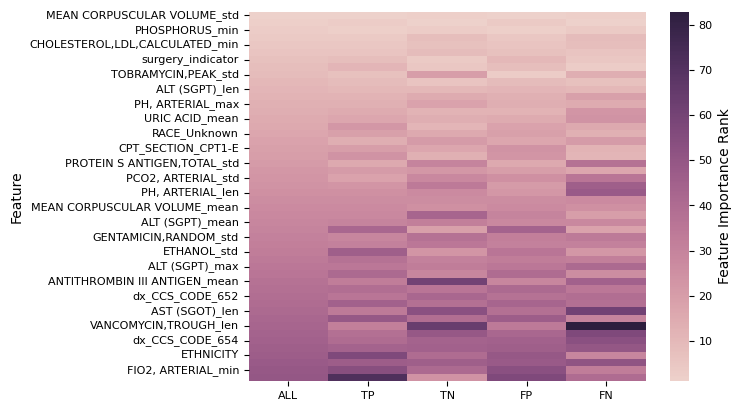

all                              tp  \
0      MEAN CORPUSCULAR VOLUME_std     MEAN CORPUSCULAR VOLUME_std   
1         Num Prev CRRT Treatments                  PHOSPHORUS_min   
2                   PHOSPHORUS_min        Num Prev CRRT Treatments   
3                  dx_CCS_CODE_650                PH, ARTERIAL_std   
4                 PH, ARTERIAL_std  CHOLESTEROL,LDL,CALCULATED_min   
5   CHOLESTEROL,LDL,CALCULATED_min                 dx_CCS_CODE_650   
6                surgery_indicator             TOBRAMYCIN,PEAK_std   
7             EOSINOPHIL,FLUID_len               surgery_indicator   
8                  dx_CCS_CODE_113                 dx_CCS_CODE_113   
9              TOBRAMYCIN,PEAK_std            EOSINOPHIL,FLUID_len   
10                  ALT (SGPT)_len                  ALT (SGPT)_len   
11                PH, ARTERIAL_max                PH, ARTERIAL_max   
12           OSMOLALITY,URINE_mean           OSMOLALITY,URINE_mean   
13          VANCOMYCIN,RANDOM_mean              PCO2, ARTERIAL_min   
14            OSMOLALITY,URINE_std            OSMOLALITY,URINE_std   

                                tn                              fp  \
0      MEAN CORPUSCULAR VOLUME_std     MEAN CORPUSCULAR VOLUME_std   
1                   PHOSPHORUS_min                  PHOSPHORUS_min   
2         Num Prev CRRT Treatments        Num Prev CRRT Treatments   
3                  dx_CCS_CODE_650                PH, ARTERIAL_std   
4                surgery_indicator             TOBRAMYCIN,PEAK_std   
5             EOSINOPHIL,FLUID_len  CHOLESTEROL,LDL,CALCULATED_min   
6   CHOLESTEROL,LDL,CALCULATED_min                 dx_CCS_CODE_650   
7                  dx_CCS_CODE_113               surgery_indicator   
8                 PH, ARTERIAL_std            EOSINOPHIL,FLUID_len   
9           VANCOMYCIN,RANDOM_mean                 dx_CCS_CODE_113   
10                  ALT (SGPT)_len                  ALT (SGPT)_len   
11       LACTATE DEHYDROGENASE_min           OSMOLALITY,URINE_mean   
12           VANCOMYCIN,RANDOM_min            OSMOLALITY,URINE_std   
13                PH, ARTERIAL_max                PH, ARTERIAL_max   
14              CPT_SECTION_CPT1-E                  URIC ACID_mean   

                                fn  
0         Num Prev CRRT Treatments  
1      MEAN CORPUSCULAR VOLUME_std  
2                surgery_indicator  
3                   PHOSPHORUS_min  
4             EOSINOPHIL,FLUID_len  
5                  dx_CCS_CODE_650  
6                  dx_CCS_CODE_113  
7   CHOLESTEROL,LDL,CALCULATED_min  
8                 PH, ARTERIAL_std  
9                   ALT (SGPT)_len  
10              CPT_SECTION_CPT1-E  
11   PHARM_SUBCLASS_NASAL STEROIDS  
12                    RACE_Unknown  
13             TOBRAMYCIN,PEAK_std  
14                PH, ARTERIAL_max

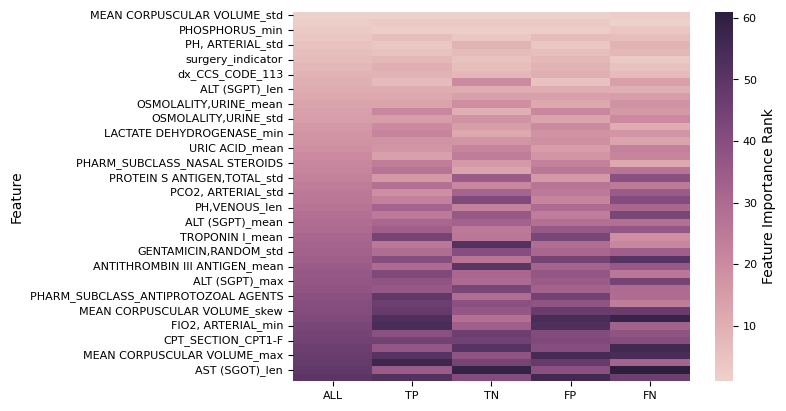

In [47]:
plot_feature_rankings(all_preselectall, None, limit=50)
plot_feature_rankings(all_preselectall, 'ucla_crrt+cedars_crrt_8', limit=50)
plot_feature_rankings(all_preselectall, 'ucla_crrt+cedars_crrt_8_v2', limit=50)

all                              tp  \
0      MEAN CORPUSCULAR VOLUME_std     MEAN CORPUSCULAR VOLUME_std   
1                   PHOSPHORUS_min  CHOLESTEROL,LDL,CALCULATED_min   
2         Num Prev CRRT Treatments                  PHOSPHORUS_min   
3                  dx_CCS_CODE_650        Num Prev CRRT Treatments   
4                surgery_indicator                PH, ARTERIAL_std   
5   CHOLESTEROL,LDL,CALCULATED_min                 dx_CCS_CODE_650   
6             EOSINOPHIL,FLUID_len                 dx_CCS_CODE_113   
7                 PH, ARTERIAL_std               surgery_indicator   
8                  dx_CCS_CODE_113                PH, ARTERIAL_max   
9           VANCOMYCIN,RANDOM_mean            EOSINOPHIL,FLUID_len   
10                  ALT (SGPT)_len                  ALT (SGPT)_len   
11                PH, ARTERIAL_max             TOBRAMYCIN,PEAK_std   
12           VANCOMYCIN,RANDOM_min           OSMOLALITY,URINE_mean   
13              CPT_SECTION_CPT1-E              PCO2, ARTERIAL_min   
14             TOBRAMYCIN,PEAK_std            OSMOLALITY,URINE_std   

                                tn                              fp  \
0      MEAN CORPUSCULAR VOLUME_std        Num Prev CRRT Treatments   
1                   PHOSPHORUS_min               surgery_indicator   
2                  dx_CCS_CODE_650     MEAN CORPUSCULAR VOLUME_std   
3         Num Prev CRRT Treatments                 dx_CCS_CODE_113   
4                surgery_indicator                  PHOSPHORUS_min   
5           VANCOMYCIN,RANDOM_mean                PH, ARTERIAL_std   
6   CHOLESTEROL,LDL,CALCULATED_min                 dx_CCS_CODE_650   
7             EOSINOPHIL,FLUID_len            EOSINOPHIL,FLUID_len   
8                  dx_CCS_CODE_113              CPT_SECTION_CPT1-E   
9                 PH, ARTERIAL_std  CHOLESTEROL,LDL,CALCULATED_min   
10           VANCOMYCIN,RANDOM_min                  ALT (SGPT)_len   
11                  ALT (SGPT)_len           OSMOLALITY,URINE_mean   
12                PH, ARTERIAL_max       LACTATE DEHYDROGENASE_min   
13    MEAN CORPUSCULAR VOLUME_mean                PH, ARTERIAL_max   
14              CPT_SECTION_CPT1-E            OSMOLALITY,URINE_std   

                                fn  
0         Num Prev CRRT Treatments  
1      MEAN CORPUSCULAR VOLUME_std  
2                surgery_indicator  
3                   PHOSPHORUS_min  
4                  dx_CCS_CODE_650  
5             EOSINOPHIL,FLUID_len  
6   CHOLESTEROL,LDL,CALCULATED_min  
7                  dx_CCS_CODE_113  
8                   ALT (SGPT)_len  
9                 PH, ARTERIAL_std  
10              CPT_SECTION_CPT1-E  
11          VANCOMYCIN,RANDOM_mean  
12                    RACE_Unknown  
13                PH, ARTERIAL_max  
14            OSMOLALITY,URINE_std

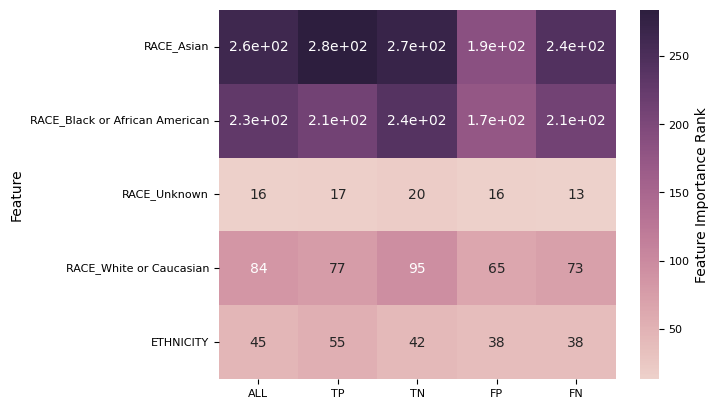

all                              tp  \
0      MEAN CORPUSCULAR VOLUME_std     MEAN CORPUSCULAR VOLUME_std   
1         Num Prev CRRT Treatments                  PHOSPHORUS_min   
2                   PHOSPHORUS_min        Num Prev CRRT Treatments   
3                 PH, ARTERIAL_std                PH, ARTERIAL_std   
4   CHOLESTEROL,LDL,CALCULATED_min  CHOLESTEROL,LDL,CALCULATED_min   
5                  dx_CCS_CODE_650                 dx_CCS_CODE_650   
6                surgery_indicator             TOBRAMYCIN,PEAK_std   
7             EOSINOPHIL,FLUID_len               surgery_indicator   
8              TOBRAMYCIN,PEAK_std                 dx_CCS_CODE_113   
9                  dx_CCS_CODE_113                  ALT (SGPT)_len   
10                  ALT (SGPT)_len            EOSINOPHIL,FLUID_len   
11           OSMOLALITY,URINE_mean           OSMOLALITY,URINE_mean   
12                PH, ARTERIAL_max                PH, ARTERIAL_max   
13            OSMOLALITY,URINE_std              PCO2, ARTERIAL_min   
14                  URIC ACID_mean            OSMOLALITY,URINE_std   

                                tn                              fp  \
0         Num Prev CRRT Treatments     MEAN CORPUSCULAR VOLUME_std   
1      MEAN CORPUSCULAR VOLUME_std                  PHOSPHORUS_min   
2                   PHOSPHORUS_min             TOBRAMYCIN,PEAK_std   
3                surgery_indicator        Num Prev CRRT Treatments   
4             EOSINOPHIL,FLUID_len                PH, ARTERIAL_std   
5                  dx_CCS_CODE_113  CHOLESTEROL,LDL,CALCULATED_min   
6   CHOLESTEROL,LDL,CALCULATED_min                 dx_CCS_CODE_650   
7                 PH, ARTERIAL_std            EOSINOPHIL,FLUID_len   
8                  dx_CCS_CODE_650                 dx_CCS_CODE_113   
9                   ALT (SGPT)_len               surgery_indicator   
10       LACTATE DEHYDROGENASE_min                  ALT (SGPT)_len   
11            OSMOLALITY,URINE_std            OSMOLALITY,URINE_std   
12   PHARM_SUBCLASS_NASAL STEROIDS           OSMOLALITY,URINE_mean   
13                  URIC ACID_mean                PH, ARTERIAL_max   
14           OSMOLALITY,URINE_mean                  URIC ACID_mean   

                                fn  
0         Num Prev CRRT Treatments  
1      MEAN CORPUSCULAR VOLUME_std  
2             EOSINOPHIL,FLUID_len  
3                   PHOSPHORUS_min  
4                surgery_indicator  
5                  dx_CCS_CODE_650  
6                  dx_CCS_CODE_113  
7   CHOLESTEROL,LDL,CALCULATED_min  
8                 PH, ARTERIAL_std  
9                   ALT (SGPT)_len  
10   PHARM_SUBCLASS_NASAL STEROIDS  
11              CPT_SECTION_CPT1-E  
12                    RACE_Unknown  
13             TOBRAMYCIN,PEAK_std  
14                PH, ARTERIAL_max

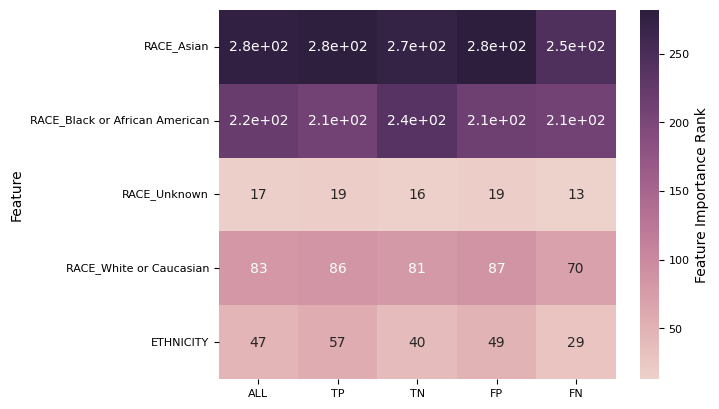

all                              tp  \
0      MEAN CORPUSCULAR VOLUME_std     MEAN CORPUSCULAR VOLUME_std   
1         Num Prev CRRT Treatments                  PHOSPHORUS_min   
2                   PHOSPHORUS_min        Num Prev CRRT Treatments   
3                  dx_CCS_CODE_650                PH, ARTERIAL_std   
4                 PH, ARTERIAL_std  CHOLESTEROL,LDL,CALCULATED_min   
5   CHOLESTEROL,LDL,CALCULATED_min                 dx_CCS_CODE_650   
6                surgery_indicator             TOBRAMYCIN,PEAK_std   
7             EOSINOPHIL,FLUID_len               surgery_indicator   
8                  dx_CCS_CODE_113                 dx_CCS_CODE_113   
9              TOBRAMYCIN,PEAK_std            EOSINOPHIL,FLUID_len   
10                  ALT (SGPT)_len                  ALT (SGPT)_len   
11                PH, ARTERIAL_max                PH, ARTERIAL_max   
12           OSMOLALITY,URINE_mean           OSMOLALITY,URINE_mean   
13          VANCOMYCIN,RANDOM_mean              PCO2, ARTERIAL_min   
14            OSMOLALITY,URINE_std            OSMOLALITY,URINE_std   

                                tn                              fp  \
0      MEAN CORPUSCULAR VOLUME_std     MEAN CORPUSCULAR VOLUME_std   
1                   PHOSPHORUS_min                  PHOSPHORUS_min   
2         Num Prev CRRT Treatments        Num Prev CRRT Treatments   
3                  dx_CCS_CODE_650                PH, ARTERIAL_std   
4                surgery_indicator             TOBRAMYCIN,PEAK_std   
5             EOSINOPHIL,FLUID_len  CHOLESTEROL,LDL,CALCULATED_min   
6   CHOLESTEROL,LDL,CALCULATED_min                 dx_CCS_CODE_650   
7                  dx_CCS_CODE_113               surgery_indicator   
8                 PH, ARTERIAL_std            EOSINOPHIL,FLUID_len   
9           VANCOMYCIN,RANDOM_mean                 dx_CCS_CODE_113   
10                  ALT (SGPT)_len                  ALT (SGPT)_len   
11       LACTATE DEHYDROGENASE_min           OSMOLALITY,URINE_mean   
12           VANCOMYCIN,RANDOM_min            OSMOLALITY,URINE_std   
13                PH, ARTERIAL_max                PH, ARTERIAL_max   
14              CPT_SECTION_CPT1-E                  URIC ACID_mean   

                                fn  
0         Num Prev CRRT Treatments  
1      MEAN CORPUSCULAR VOLUME_std  
2                surgery_indicator  
3                   PHOSPHORUS_min  
4             EOSINOPHIL,FLUID_len  
5                  dx_CCS_CODE_650  
6                  dx_CCS_CODE_113  
7   CHOLESTEROL,LDL,CALCULATED_min  
8                 PH, ARTERIAL_std  
9                   ALT (SGPT)_len  
10              CPT_SECTION_CPT1-E  
11   PHARM_SUBCLASS_NASAL STEROIDS  
12                    RACE_Unknown  
13             TOBRAMYCIN,PEAK_std  
14                PH, ARTERIAL_max

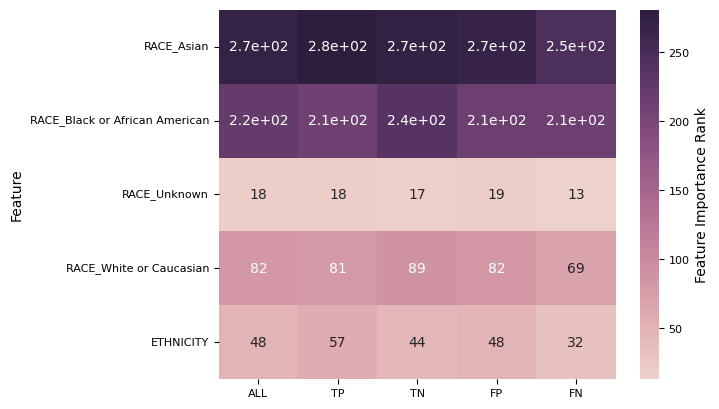

In [48]:
plot_feature_rankings(all_preselectall, None, limit=15, feature_list=['RACE_Asian',
 'RACE_Black or African American',
 'RACE_Unknown',
 'RACE_White or Caucasian',
 'ETHNICITY'],annot=True)

plot_feature_rankings(all_preselectall, 'ucla_crrt+cedars_crrt_8', limit=15, feature_list=['RACE_Asian',
 'RACE_Black or African American',
 'RACE_Unknown',
 'RACE_White or Caucasian',
 'ETHNICITY'],annot=True)

plot_feature_rankings(all_preselectall, 'ucla_crrt+cedars_crrt_8_v2', limit=15, feature_list=['RACE_Asian',
 'RACE_Black or African American',
 'RACE_Unknown',
 'RACE_White or Caucasian',
 'ETHNICITY'],annot=True)

100%|██████████| 778/778 [00:00<00:00, 254160.64it/s]


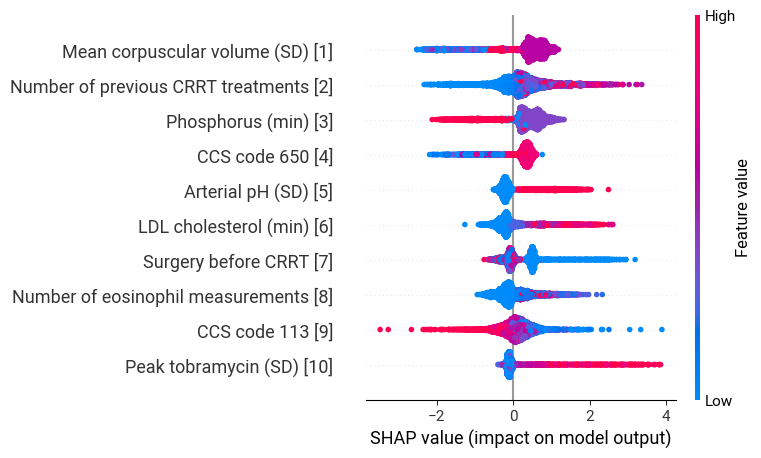

tp


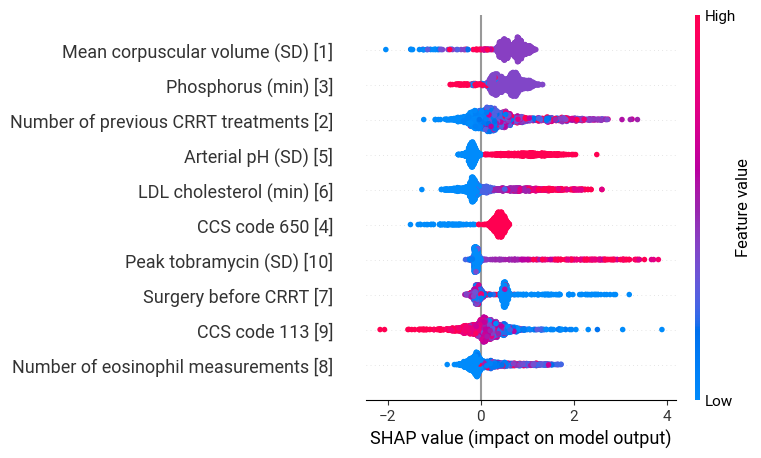

tn


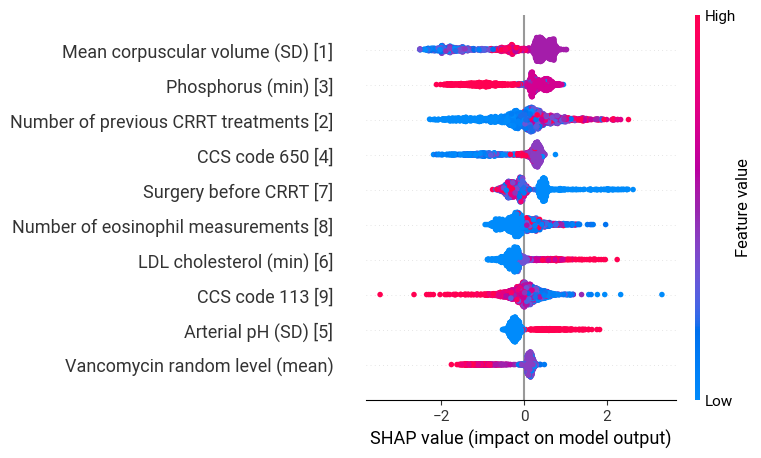

fp


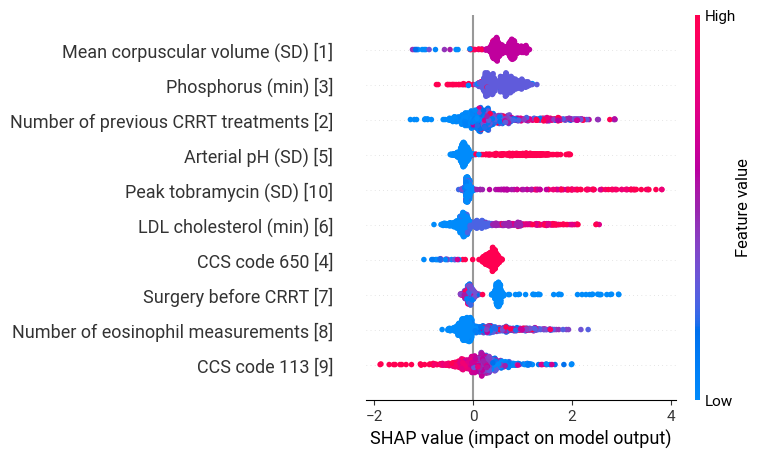

fn


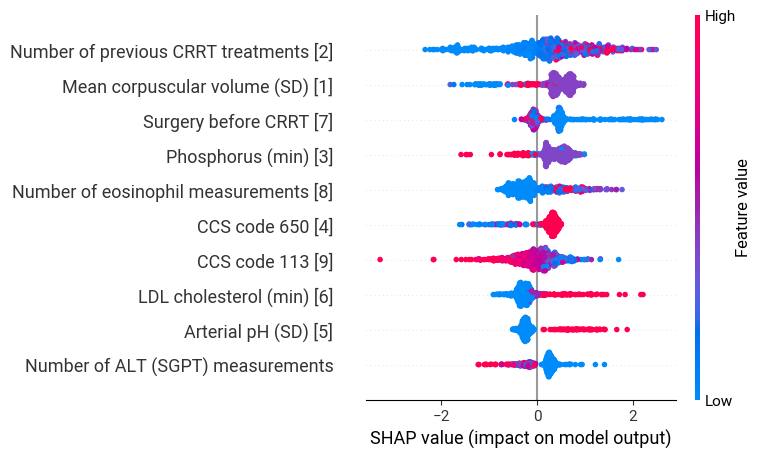

In [119]:
# plot_explanations(all_preselectall, None, limit=10)
# plot_explanations(all_preselectall, 'ucla_crrt+cedars_crrt_8', limit=10)
plot_explanations(all_preselectall, 'ucla_crrt+cedars_crrt_8_v2', limit=10)

100%|██████████| 187/187 [00:00<00:00, 137602.60it/s]


(1956, 187)
(1956, 187)


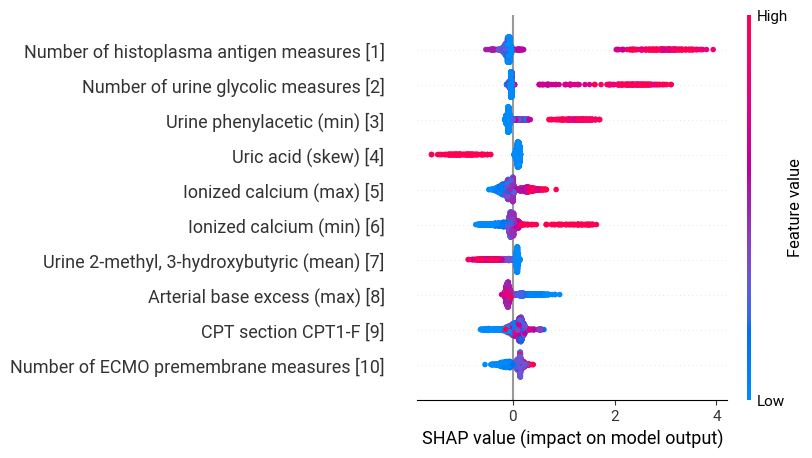

100%|██████████| 187/187 [00:00<00:00, 162792.62it/s]


(2870, 187)
(2870, 187)


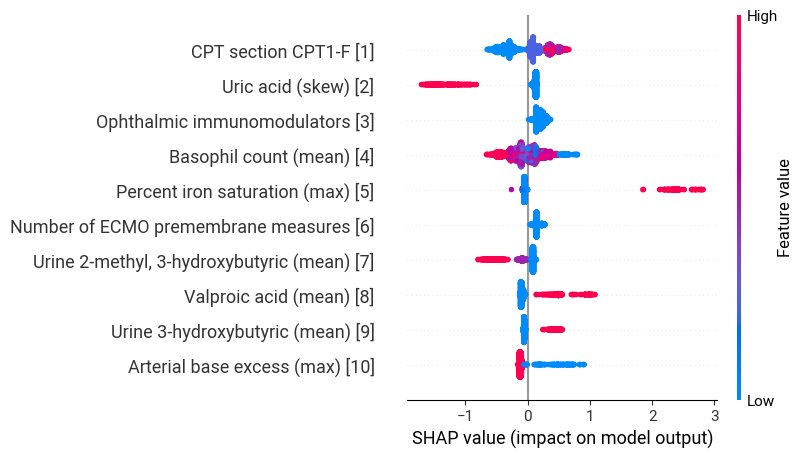

100%|██████████| 281/281 [00:00<00:00, 62462.21it/s]


(1443, 281, 2)
(1443, 281, 2)


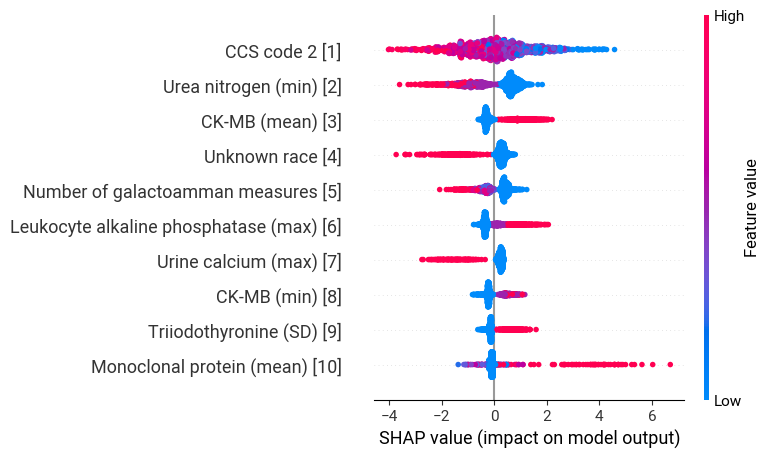

100%|██████████| 281/281 [00:00<00:00, 187645.19it/s]


(3650, 281, 2)
(3650, 281, 2)


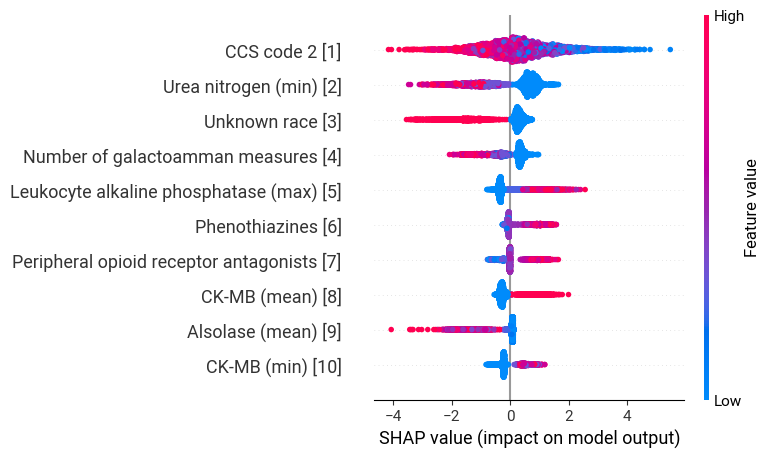

100%|██████████| 687/687 [00:00<00:00, 220212.98it/s]


(3427, 687, 2)
(3427, 687, 2)


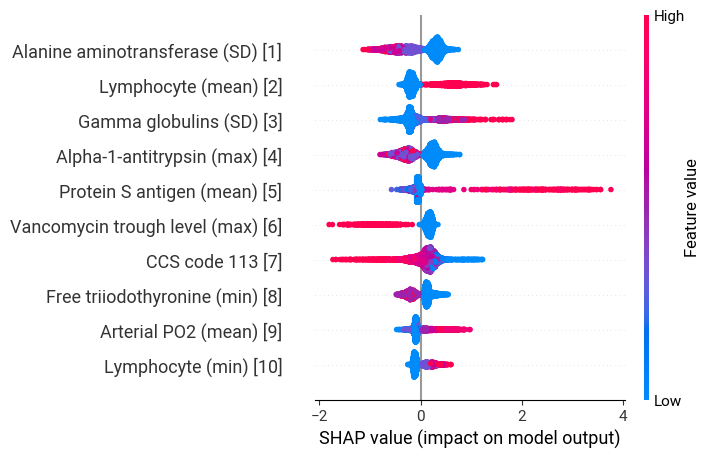

In [212]:
plot_explanations(ucla_train, 'ucla_crrt_8_v2', limit=10)
plot_explanations(ucla_train, 'cedars_crrt_8_v2', limit=10)
plot_explanations(cedars_train, 'cedars_crrt_8_v2', limit=10)
plot_explanations(cedars_train, 'ucla_crrt_8_v2', limit=10)
plot_explanations(uclapluscedars_preselectcrrt, 'ucla_crrt+cedars_crrt_8_v2', limit=10)

# Split counts

In [12]:
def get_split_count(
              run_names, filters,):
    
    table = {'train': {},
             'val': {},
             'test': {},
             'percent': {}}
    
    for run_name, filter in zip(run_names, filters):
        
        if len(filter) > 0:
            run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
        else:
            run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")

        prefix = f"{run.data.tags['modeln']}_test"
        labels_path = join(exp_path, run.info.run_id, "artifacts", run_name, "labels", f"{prefix}__{run_name}","labels.pkl")
        labels = pickle.load(open(labels_path, 'rb'))
        # test_size = len(labels.index.get_level_values('IP_PATIENT_ID').unique())
        test_size = len(labels)

        try:
            best_run = run.data.tags['best_run_id']
        except:
            best_run = run.data.tags['best_model_path'].split('/artifacts')[0].split('/')[-1]
        client_path = join(mlflow_path, run_name, 'mlruns')
        client =  mlflow.tracking.MlflowClient(f"file://{client_path}")
        best_run = client.get_run(best_run)
        
        #####################
        from data.subpopulation_utils import generate_filters
        from data.sklearn_loaders import SklearnCRRTDataModule, LOCAL_DATA_DIR

        best_model_path = join(mlflow_path,main.get_mlflow_model_uri(best_run).split('mlflow/')[-1])
        modeln = run.data.tags["modeln"]

        # split the best params into the ones that should be in model_kwargs and not
        top_level_params = {}
        model_kwargs = {}
        for param_name, param_val in best_run.data.tags.items():
            if param_name.startswith(modeln):
                # exclude the rf_ if modeln is rf
                raw_name = param_name[len(f"{args.modeln}") :]
                model_kwargs[raw_name] = param_val
            elif param_name.startswith('mlflow'):
                pass
            else:
                top_level_params[param_name] = reinit_param_from_string(args, param_name, param_val)
        model_kwargs.update(best_run.data.params)
        
        top_level_params['ucla_control_data_dir'] = '/radraid/jeffreyfeng/CRRT_Project/Data/Controls'
        top_level_params['ucla_crrt_data_dir'] = '/radraid/jeffreyfeng/CRRT_Project/Data/UCLA'
        top_level_params['cedars_crrt_data_dir'] = '/radraid/jeffreyfeng/CRRT_Project/Data/Cedars'
        top_level_params['local_log_path']= join(mlflow_path,top_level_params['local_log_path'].split('mlflow/')[-1])
        
        dargs = vars(args)
        dargs.update(
            {
                **top_level_params,
                # modeln is selected outside of optuna so it wont be in params
                "modeln": modeln,
                # model_kwargs in best_trial.params but flattened out
                # "model_kwargs": model_kwargs,
                # "best_run_id": run.info.run_id,
                "best_model_path": best_model_path,
                "stage": "eval",
                "rolling_evaluation": True,
                "reference_window": True,
                "slide_window_by": 0,
                "tune_n_trials": 0,
                
                # "pre_start_delta": {'YEARS': 0, 'MONTHS': 0, 'DAYS': 7},
                # 'time_interval': '1D',
                # "new_eval_cohort": True,
                # "max_days_on_crrt": 200,
                # "min_days_on_crrt": 8,
                # "eval_cohort": 'ucla_crrt' if filter == '' else 'cedars_crrt',
                # "train_val_cohort": 'ucla_crrt' if 'ucla_control' in args.train_val_cohort else args.train_val_cohort, # doesn't matter, so just use cedars which is fastest

                # use for explanation run
                # "plot_names": ["shap_explain", "randomness", "error_viz"],
            }
        )
        filters = generate_filters()
        filters = {
            k: v for groupname, d in filters.items() for k, v in d.items()
        }  # flatten
        data = SklearnCRRTDataModule.from_argparse_args(args, filters=generate_filters())
        (
            reference_ids,
            original_columns,
            data_transform,
        ) = data.load_data_params(join(args.best_model_path, "static_data"))

        data.setup(
            args,
            reference_ids=reference_ids,
            reference_cols=original_columns,
            data_transform=data_transform,
        )
        print(data.train[0].shape)
        print(np.unique(data.train[1],return_counts=True))
        print(data.val[0].shape)
        print(np.unique(data.val[1],return_counts=True))
        print(data.test[0].shape)
        print(np.unique(data.test[1],return_counts=True))
        with open('./index_debug.pkl', "wb") as f:
            pickle.dump(data.split_pt_ids,f)
        ##########################
        
        split_path = join(exp_path, best_run.info.run_id, "artifacts", 'static_data', "split_ids.pkl")
        splits = pickle.load(open(split_path, 'rb'))
        
        # assert test_size == len(splits['test'])
        
        table['train'][f'{run_name} {filter}']=len(splits['train'])
        table['val'][f'{run_name} {filter}']=len(splits['val'])
        table['test'][f'{run_name} {filter}']=test_size
        table['percent'][f'{run_name} {filter}']=labels.value_counts()[1]/test_size*100

    display(pd.DataFrame(table))

In [13]:
runs = [
        ucla_train,
        # ucla_train,
        # ucla_train,
        cedars_train,
        # cedars_train,
        # cedars_train,
        # uclapluscedars_train,
        # uclapluscedars_train,
        # all_train,
        uclapluscedars_preselectcrrt,
        all_preselectall
        ]
filters = [
        '',
        # 'cedars_crrt',
        # 'ucla_control',
        '',
        # 'ucla_crrt',
        # 'ucla_control',
        # '',
        # 'ucla_control',
        # '',
        '',
        ''
        ]
get_split_count(runs,filters)

In [29]:
from tqdm import tqdm
import cloudpickle

def get_feature_counts(
              run_names, filters,):
    
    table = {
            'model': {},
            'window': {},
            'impute': {},
            'feature_selection': {},
            'thresh': {},
            'raw_features': {},
             'engineered_features': {},
             'model_used_raw_features': {},
             'model_used_engineered_features': {}}
       
    for run_name, filter in tqdm(zip(run_names, filters)):
        
        if len(filter) > 0:
            run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
        else:
            run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")

        prefix = f"{run.data.tags['modeln']}_test"
        labels_path = join(exp_path, run.info.run_id, "artifacts", run_name, "labels", f"{prefix}__{run_name}","labels.pkl")
        labels = pickle.load(open(labels_path, 'rb'))
        # test_size = len(labels.index.get_level_values('IP_PATIENT_ID').unique())
        test_size = len(labels)

        try:
            best_run = run.data.tags['best_run_id']
        except:
            best_run = run.data.tags['best_model_path'].split('/artifacts')[0].split('/')[-1]
        client_path = join(mlflow_path, run_name, 'mlruns')
        client =  mlflow.tracking.MlflowClient(f"file://{client_path}")
        best_run = client.get_run(best_run)
        
        tform_path = join(exp_path, best_run.info.run_id, "artifacts", 'static_data', "data_transform.pkl")
        tform = cloudpickle.load(open(tform_path, 'rb'))
        
        col_path = join(exp_path, best_run.info.run_id, "artifacts", 'static_data', "columns.pkl")
        cols = pickle.load(open(col_path, 'rb'))
        
        selected_columns_mask = tform.__self__.named_steps[
            "feature-selection"
        ].get_support()
        selected_columns = cols[selected_columns_mask]
                
        unique_features = (
        cols.str.replace(".*_indicator", "indicator", regex=True)
        .str.replace("RACE.*", "RACE", regex=True)
        # tobacco/smoking/allergen aren't currenly in the intersection of features for all 3 cohorts, i've included it here just in case
        .str.replace(".*TOBACCO_USER.*", "TOBACCO_USER", regex=True)
        .str.replace(".*SMOKING_TOB_STATUS.*", "SMOKING_TOB_STATUS", regex=True)
        .str.replace(".*ALLERGEN_ID.*", "ALLERGEN_ID", regex=True)
        .str.replace("_(mean|min|max|std|skew|len)", "", regex=True)
        .unique()
        )
        
        unique_features_model = (
        selected_columns.str.replace(".*_indicator", "indicator", regex=True)
        .str.replace("RACE.*", "RACE", regex=True)
        # tobacco/smoking/allergen aren't currenly in the intersection of features for all 3 cohorts, i've included it here just in case
        .str.replace(".*TOBACCO_USER.*", "TOBACCO_USER", regex=True)
        .str.replace(".*SMOKING_TOB_STATUS.*", "SMOKING_TOB_STATUS", regex=True)
        .str.replace(".*ALLERGEN_ID.*", "ALLERGEN_ID", regex=True)
        .str.replace("_(mean|min|max|std|skew|len)", "", regex=True)
        .unique()
        )
                
        table['model'][f'{run_name} {filter}'] = best_run.data.tags['modeln']
        table['window'][f'{run_name} {filter}'] = best_run.data.tags['pre_start_delta']
        table['impute'][f'{run_name} {filter}'] = best_run.data.tags['impute_method']
        if best_run.data.tags['corr_thresh'] is not None:
            table['feature_selection'][f'{run_name} {filter}'] = 'corr_thresh'
            table['thresh'][f'{run_name} {filter}'] = best_run.data.tags['corr_thresh']
        else:
            table['feature_selection'][f'{run_name} {filter}'] = 'kbest'
            table['thresh'][f'{run_name} {filter}'] = best_run.data.tags['kbest']
        
        table['raw_features'][f'{run_name} {filter}']=len(unique_features)
        table['engineered_features'][f'{run_name} {filter}']=len(cols)
        table['model_used_raw_features'][f'{run_name} {filter}']=len(unique_features_model)
        table['model_used_engineered_features'][f'{run_name} {filter}']=len(selected_columns)
    
    display(pd.DataFrame(table))

In [30]:
runs = [
        ucla_train,
        # ucla_train,
        # ucla_train,
        cedars_train,
        # cedars_train,
        # cedars_train,
        uclapluscedars_train,
        # uclapluscedars_train,
        all_train,
        ucla_preselectall,
        # ucla_preselectall,
        # ucla_preselectall,
        ucla_preselectcrrt,
        # ucla_preselectcrrt,
        cedars_preselectall,
        # cedars_preselectall,
        # cedars_preselectall,
        cedars_preselectcrrt,
        # cedars_preselectcrrt,
        uclapluscedars_preselectall,
        # uclapluscedars_preselectall,
        uclapluscedars_preselectcrrt,
        all_preselectall
        ]
filters = [
        '',
        # 'cedars_crrt',
        # 'ucla_control',
        '',
        # 'ucla_crrt',
        # 'ucla_control',
        '',
        # 'ucla_control',
        '',
        "",
        # "cedars_crrt",
        # "ucla_control",
        "",
        # "cedars_crrt",
        '',
        # 'ucla_crrt',
        # 'ucla_control',
        '',
        # 'ucla_crrt',
        '',
        # 'ucla_control',
        '',
        ''
        ]
get_feature_counts(runs,filters)

0it [00:00, ?it/s]

11it [00:09,  1.18it/s]


model  \
ucla_to_ucla_tune50_v3                               xgb   
cedars_to_cedars_tune50_v3                           lgb   
uclapluscedars_to_uclapluscedars_tune50_v3           lgb   
all_to_all_tune50_v3                                 xgb   
ucla_to_ucla_preselectall_tune50_v3                  xgb   
ucla_to_ucla_preselectcrrt_tune50_v3                 xgb   
cedars_to_cedars_preselectall_tune50_v3              lgb   
cedars_to_cedars_preselectcrrt_tune50_v3             xgb   
uclapluscedars_to_uclapluscedars_preselectall_t...   lgb   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   lgb   
all_to_all_preselectall_tune50_v3                    lgb   

                                                                                   window  \
ucla_to_ucla_tune50_v3                               {'YEARS': 0, 'MONTHS': 0, 'DAYS': 5}   
cedars_to_cedars_tune50_v3                           {'YEARS': 0, 'MONTHS': 0, 'DAYS': 6}   
uclapluscedars_to_uclapluscedars_tune50_v3          {'YEARS': 0, 'MONTHS': 0, 'DAYS': 10}   
all_to_all_tune50_v3                                 {'YEARS': 0, 'MONTHS': 0, 'DAYS': 7}   
ucla_to_ucla_preselectall_tune50_v3                  {'YEARS': 0, 'MONTHS': 0, 'DAYS': 5}   
ucla_to_ucla_preselectcrrt_tune50_v3                 {'YEARS': 0, 'MONTHS': 0, 'DAYS': 5}   
cedars_to_cedars_preselectall_tune50_v3              {'YEARS': 0, 'MONTHS': 0, 'DAYS': 6}   
cedars_to_cedars_preselectcrrt_tune50_v3            {'YEARS': 0, 'MONTHS': 0, 'DAYS': 14}   
uclapluscedars_to_uclapluscedars_preselectall_t...  {'YEARS': 0, 'MONTHS': 0, 'DAYS': 10}   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  {'YEARS': 0, 'MONTHS': 0, 'DAYS': 10}   
all_to_all_preselectall_tune50_v3                   {'YEARS': 0, 'MONTHS': 0, 'DAYS': 10}   

                                                    impute feature_selection  \
ucla_to_ucla_tune50_v3                              simple       corr_thresh   
cedars_to_cedars_tune50_v3                          simple       corr_thresh   
uclapluscedars_to_uclapluscedars_tune50_v3          simple       corr_thresh   
all_to_all_tune50_v3                                simple       corr_thresh   
ucla_to_ucla_preselectall_tune50_v3                 simple       corr_thresh   
ucla_to_ucla_preselectcrrt_tune50_v3                simple       corr_thresh   
cedars_to_cedars_preselectall_tune50_v3             simple       corr_thresh   
cedars_to_cedars_preselectcrrt_tune50_v3            simple       corr_thresh   
uclapluscedars_to_uclapluscedars_preselectall_t...  simple       corr_thresh   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  simple       corr_thresh   
all_to_all_preselectall_tune50_v3                   simple       corr_thresh   

                                                   thresh  raw_features  \
ucla_to_ucla_tune50_v3                               0.08          2350   
cedars_to_cedars_tune50_v3                           0.05          1050   
uclapluscedars_to_uclapluscedars_tune50_v3           0.02          3044   
all_to_all_tune50_v3                                 0.04          3238   
ucla_to_ucla_preselectall_tune50_v3                  0.08           575   
ucla_to_ucla_preselectcrrt_tune50_v3                 0.08           651   
cedars_to_cedars_preselectall_tune50_v3              0.05           595   
cedars_to_cedars_preselectcrrt_tune50_v3            0.035           703   
uclapluscedars_to_uclapluscedars_preselectall_t...   0.02           635   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   0.02           696   
all_to_all_preselectall_tune50_v3                    0.01           635   

                                                    engineered_features  \
ucla_to_ucla_tune50_v3                                             8974   
cedars_to_cedars_tune50_v3                                         2989   
uclapluscedars_to_uclapluscedars_tune50_v3                        12379   
all_to_all_tune50_v3                               